<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/IndianCars_R1GAN3_cl128_multibg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Deep Convolutional GANs
Reference: https://arxiv.org/pdf/1511.06434.pdf

In [2]:
!nvidia-smi

Thu Sep 24 16:39:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import numpy as np
import datetime
import os, sys
from PIL import Image
from matplotlib import pyplot as plt
import glob

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline
# Set random seed for reproducibility
import random
manualSeed = 0xdeadbeef
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3735928559


In [5]:
MODEL_NAME = 'R1GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
IMAGE_DIM = (128, 128, 3)

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 28, 28).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [7]:
from google.colab import drive
drive.mount('/content/drive')
#!cp /content/drive/My\ Drive/EVA4/S2GAN/allCars.tar.gz /content
#!cp /content/drive/My\ Drive/EVA4/S2GAN/allCars_nobg.tar.gz /content
#!cp /content/drive/My\ Drive/EVA4/S2GAN/allCars_wbg.tar.gz /content
!cp /content/drive/My\ Drive/EVA4/S2GAN/allCars_multibg.tar.gz /content

#!tar -zxvf allCars.tar.gz
#!tar -zxvf allCars_nobg.tar.gz
!tar -zxvf allCars_multibg.tar.gz

!mv /content/content/allCars_nobg /content/

Mounted at /content/drive
./allCars_nobg/
./allCars_nobg/wbg_Nexon_00000052.jpg
./allCars_nobg/wbg_xuv500_00000145.jpg
./allCars_nobg/duster_00000203.jpg
./allCars_nobg/xuv500_00000289.jpg
./allCars_nobg/duster_00000055.jpg
./allCars_nobg/wbg_mixed_cars_00000065.jpg
./allCars_nobg/duster_00000248.jpg
./allCars_nobg/wbg_Harrier_00000282.jpg
./allCars_nobg/Harrier_00000068.jpg
./allCars_nobg/wbg_duster_00000059.jpg
./allCars_nobg/duster_00000042.jpg
./allCars_nobg/wbg_Nexon_00000086.jpg
./allCars_nobg/Harrier_00000104.jpg
./allCars_nobg/wbg_Nexon_00000101.jpg
./allCars_nobg/Nexon_00000175.jpg
./allCars_nobg/Harrier_00000144.jpg
./allCars_nobg/duster_00000004.jpg
./allCars_nobg/Harrier_00000160.jpg
./allCars_nobg/xuv500_00000185.jpg
./allCars_nobg/wbg_xuv500_00000345.jpg
./allCars_nobg/xuv500_00000177.jpg
./allCars_nobg/wbg_mixed_cars_00000007.jpg
./allCars_nobg/wbg_duster_00000182.jpg
./allCars_nobg/wbg_Harrier_00000112.jpg
./allCars_nobg/duster_00000215.jpg
./allCars_nobg/wbg_xuv500_000

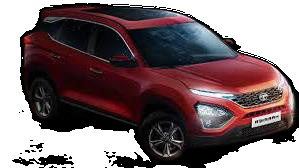

In [ ]:
from PIL import Image
Image.open("/content/content/allCars_wbg/Harrier_00000076.jpg")

In [ ]:
import shutil
import os
#os

dir_path="/content/allCars_nobg"
for file_name in glob.glob("/content/content/allCars_wbg/*"):
    base_name =  os.path.basename(file_name)
    dst_file = os.path.join(dir_path, "wbg_"+base_name)
    shutil.copy(file_name, os.path.join(dir_path,dst_file))

In [ ]:
len(glob.glob("/content/allCars_nobg/*"))

2038

In [ ]:
!tar -czvf allCars_multibg.tar.gz ./allCars_nobg

In [ ]:
!cp /content/allCars_multibg.tar.gz /content/drive/My\ Drive/EVA4/S2GAN/

In [ ]:
!ls -lrt /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan/*tar

-rw------- 1 root root 559114818 Sep 20 11:07 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128001600.pth.tar'
-rw------- 1 root root 559114818 Sep 20 11:07 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128001400.pth.tar'
-rw------- 1 root root 559114818 Sep 20 12:08 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128002000.pth.tar'
-rw------- 1 root root 559114818 Sep 20 12:45 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128002600.pth.tar'


In [8]:
import sys
sys.path.append("/content/drive/My Drive/EVA4/RekogNizer")
sys.path.append("/content/drive/My Drive/EVA4/")

In [9]:
%load_ext autoreload
%autoreload 2
from RekogNizer import ganmodelsnew

In [10]:
IMAGE_DIM = (128,128,3)

In [20]:
G_losses = []
D_losses = []
img_list = []
r1gan = ganmodelsnew.R1GAN(img_size=128,d_in_channel=IMAGE_DIM[-1],g_out_channel=IMAGE_DIM[-1],g_n_noise=256, model_prefix="r1gan_adam128")
#r1gan.load_model("/content/ckpt/r1gan_adam128002600.pth.tar")

In [59]:
r1gan.df_loss

Empty DataFrame
Columns: [Step, G_loss, D_loss, DReal_loss, DFake_loss, Grad_Penalty]
Index: []

In [ ]:
r1gan.load_model("/content/ckpt/r1gan_adamrelu128_wbg005000.pth.tar")

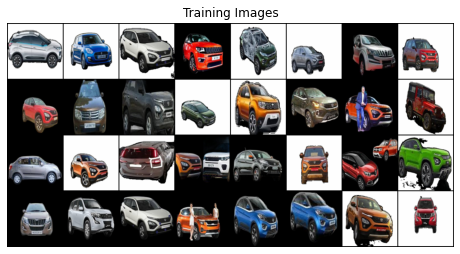

In [12]:
import torchvision.utils as vutils


class CARS(Dataset):
    '''
    CARS Dataset
    You should download this dataset from below url.
    url: https://ai.stanford.edu/~jkrause/cars/car_dataset.html
    '''
    def __init__(self, data_path, transform=None):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
        #gray_lst = [266, 1085, 2176, 3048, 3439, 3469, 3539, 4577, 4848, 5177, 5502, 5713, 6947, 7383, 7693, 7774, 8137, 8144]
        #for num in gray_lst:
        #    self.fpaths.remove(os.path.join(data_path, '{:05d}.jpg'.format(num)))
        
    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

image_size=128
transform = transforms.Compose([transforms.Resize((image_size,image_size)),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),                                
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)


#dataset = CARS(data_path='/home/yangyangii/git/cars_train', transform=transform)
batch_size=32
dataset = CARS(data_path='/content/allCars_nobg', transform=transform)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)


real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
#r1gan = R1GAN(img_size=IMAGE_DIM[0],d_in_channel=IMAGE_DIM[-1],g_out_channel=IMAGE_DIM[-1],g_n_noise=256 )
r1gan.train(data_loader, device, G_losses=G_losses, D_losses=D_losses,img_list=img_list)

In [ ]:
r1gan.train(data_loader, device, G_losses=G_losses, D_losses=D_losses,img_list=img_list,step=600,lr_schedule=True)

In [ ]:
%autoreload 2
from RekogNizer import ganutils

ganutils.create_graphs_and_samples(G_losses, D_losses, img_list, data_loader,device)
rand_z = ganutils.generate_image_sample(r1gan.G, device, size_tuple=(30,30))

In [33]:
G_losses = []
D_losses = []
img_list = []

In [34]:
r1gan.load_model("/content/ckpt/r1gan_adamrelu128_wbg010400.pth.tar")

In [ ]:
g_loss,d_loss,img_local_list = r1gan.train(data_loader, device,
                                           G_losses=G_losses,
                                           D_losses=D_losses,
                                           img_list=img_list,
                                           step=0,
                                           lr_schedule=False,
                                           model_save_prefix="r1gan_adamrelu128_wbg")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 0/200, Step: 0, D Loss: 1.3864, DReal Loss: 0.6955, DFake Loss:0.6909 G Loss: 0.6144, gp: 0.0000, Time:17:53:25
Epoch: 0/200, Step: 10, D Loss: 1.3878, DReal Loss: 1.1890, DFake Loss:0.1982 G Loss: 0.0149, gp: 0.0006, Time:17:53:41
Epoch: 0/200, Step: 20, D Loss: 0.8584, DReal Loss: 0.3671, DFake Loss:0.4789 G Loss: 1.5529, gp: 0.0124, Time:17:53:57
Epoch: 0/200, Step: 30, D Loss: 4.8179, DReal Loss: 0.0233, DFake Loss:4.7930 G Loss: 0.7937, gp: 0.0015, Time:17:54:13
Epoch: 0/200, Step: 40, D Loss: 0.6556, DReal Loss: 0.3654, DFake Loss:0.2844 G Loss: 1.5229, gp: 0.0059, Time:17:54:29
Epoch: 0/200, Step: 50, D Loss: 0.8847, DReal Loss: 0.3513, DFake Loss:0.5052 G Loss: 3.7082, gp: 0.0282, Time:17:54:45
Epoch: 0/200, Step: 60, D Loss: 0.2532, DReal Loss: 0.1795, DFake Loss:0.0373 G Loss: 1.4162, gp: 0.0363, Time:17:55:01



Epoch: 1/200, Step: 70, D Loss: 0.8898, DReal Loss: 0.4075, DFake Loss:0.4636 G Loss: 0.8871, gp: 0.0188, Time:17:55:19
Epoch: 1/200, Step: 80, D Loss: 0.5445, DReal Loss: 0.2588, DFake Loss:0.2533 G Loss: 1.6417, gp: 0.0324, Time:17:55:35
Epoch: 1/200, Step: 90, D Loss: 2.5507, DReal Loss: 0.9541, DFake Loss:1.5918 G Loss: 0.8729, gp: 0.0047, Time:17:55:51
Epoch: 1/200, Step: 100, D Loss: 1.2106, DReal Loss: 0.6244, DFake Loss:0.5857 G Loss: 0.8399, gp: 0.0004, Time:17:56:07
Epoch: 1/200, Step: 110, D Loss: 1.1994, DReal Loss: 0.2091, DFake Loss:0.9877 G Loss: 1.9162, gp: 0.0025, Time:17:56:23
Epoch: 1/200, Step: 120, D Loss: 0.9510, DReal Loss: 0.1035, DFake Loss:0.8084 G Loss: 5.1426, gp: 0.0391, Time:17:56:39



Epoch: 2/200, Step: 130, D Loss: 0.5925, DReal Loss: 0.2758, DFake Loss:0.3051 G Loss: 3.2117, gp: 0.0116, Time:17:56:56
Epoch: 2/200, Step: 140, D Loss: 1.9962, DReal Loss: 0.0085, DFake Loss:1.9700 G Loss: 2.8292, gp: 0.0178, Time:17:57:12
Epoch: 2/200, Step: 150, D Loss: 0.9576, DReal Loss: 0.2470, DFake Loss:0.6902 G Loss: 2.7956, gp: 0.0204, Time:17:57:28
Epoch: 2/200, Step: 160, D Loss: 2.7639, DReal Loss: 0.0094, DFake Loss:2.7257 G Loss: 1.3659, gp: 0.0288, Time:17:57:44
Epoch: 2/200, Step: 170, D Loss: 1.3570, DReal Loss: 1.2119, DFake Loss:0.1129 G Loss: 1.4567, gp: 0.0322, Time:17:58:00
Epoch: 2/200, Step: 180, D Loss: 0.1036, DReal Loss: 0.0367, DFake Loss:0.0409 G Loss: 4.2700, gp: 0.0259, Time:17:58:16



Epoch: 3/200, Step: 190, D Loss: 0.9660, DReal Loss: 0.8802, DFake Loss:0.0386 G Loss: 3.5607, gp: 0.0473, Time:17:58:33
Epoch: 3/200, Step: 200, D Loss: 0.0746, DReal Loss: 0.0633, DFake Loss:0.0006 G Loss: 7.9997, gp: 0.0106, Time:17:58:51
Epoch: 3/200, Step: 210, D Loss: 0.8210, DReal Loss: 0.1544, DFake Loss:0.6263 G Loss: 1.2614, gp: 0.0402, Time:17:59:07
Epoch: 3/200, Step: 220, D Loss: 1.3263, DReal Loss: 0.0156, DFake Loss:1.2703 G Loss: 3.9065, gp: 0.0404, Time:17:59:23
Epoch: 3/200, Step: 230, D Loss: 0.3339, DReal Loss: 0.2759, DFake Loss:0.0248 G Loss: 2.6708, gp: 0.0333, Time:17:59:39
Epoch: 3/200, Step: 240, D Loss: 0.1313, DReal Loss: 0.0592, DFake Loss:0.0076 G Loss: 4.4989, gp: 0.0645, Time:17:59:55
Epoch: 3/200, Step: 250, D Loss: 0.4771, DReal Loss: 0.1688, DFake Loss:0.2980 G Loss: 2.2776, gp: 0.0104, Time:18:00:11



Epoch: 4/200, Step: 260, D Loss: 0.3443, DReal Loss: 0.0830, DFake Loss:0.2421 G Loss: 5.6627, gp: 0.0192, Time:18:00:28
Epoch: 4/200, Step: 270, D Loss: 0.6150, DReal Loss: 0.3678, DFake Loss:0.1366 G Loss: 4.4232, gp: 0.1106, Time:18:00:44
Epoch: 4/200, Step: 280, D Loss: 0.7972, DReal Loss: 0.4415, DFake Loss:0.3484 G Loss: 1.4583, gp: 0.0073, Time:18:01:00
Epoch: 4/200, Step: 290, D Loss: 0.0680, DReal Loss: 0.0261, DFake Loss:0.0028 G Loss: 5.7380, gp: 0.0390, Time:18:01:16
Epoch: 4/200, Step: 300, D Loss: 1.1611, DReal Loss: 0.5969, DFake Loss:0.5574 G Loss: 0.7586, gp: 0.0068, Time:18:01:32
Epoch: 4/200, Step: 310, D Loss: 0.7035, DReal Loss: 0.2918, DFake Loss:0.3974 G Loss: 1.3906, gp: 0.0143, Time:18:01:48



Epoch: 5/200, Step: 320, D Loss: 0.3930, DReal Loss: 0.2338, DFake Loss:0.1108 G Loss: 2.0676, gp: 0.0484, Time:18:02:05
Epoch: 5/200, Step: 330, D Loss: 0.0725, DReal Loss: 0.0043, DFake Loss:0.0355 G Loss: 4.7295, gp: 0.0326, Time:18:02:21
Epoch: 5/200, Step: 340, D Loss: 0.4451, DReal Loss: 0.1820, DFake Loss:0.1938 G Loss: 2.0004, gp: 0.0693, Time:18:02:37
Epoch: 5/200, Step: 350, D Loss: 0.1504, DReal Loss: 0.0930, DFake Loss:0.0385 G Loss: 3.5224, gp: 0.0189, Time:18:02:53
Epoch: 5/200, Step: 360, D Loss: 1.4807, DReal Loss: 1.2371, DFake Loss:0.2272 G Loss: 0.9805, gp: 0.0163, Time:18:03:09
Epoch: 5/200, Step: 370, D Loss: 0.7841, DReal Loss: 0.2895, DFake Loss:0.4843 G Loss: 2.5987, gp: 0.0102, Time:18:03:25



Epoch: 6/200, Step: 380, D Loss: 0.4945, DReal Loss: 0.3815, DFake Loss:0.0944 G Loss: 1.9079, gp: 0.0186, Time:18:03:43
Epoch: 6/200, Step: 390, D Loss: 0.3420, DReal Loss: 0.0465, DFake Loss:0.2424 G Loss: 4.1570, gp: 0.0531, Time:18:03:59
Epoch: 6/200, Step: 400, D Loss: 1.0405, DReal Loss: 0.5773, DFake Loss:0.4513 G Loss: 1.1445, gp: 0.0119, Time:18:04:17
Epoch: 6/200, Step: 410, D Loss: 0.6958, DReal Loss: 0.2229, DFake Loss:0.4578 G Loss: 1.6480, gp: 0.0151, Time:18:04:33
Epoch: 6/200, Step: 420, D Loss: 0.5193, DReal Loss: 0.3173, DFake Loss:0.1857 G Loss: 2.6386, gp: 0.0163, Time:18:04:49
Epoch: 6/200, Step: 430, D Loss: 0.8586, DReal Loss: 0.4388, DFake Loss:0.3942 G Loss: 1.3045, gp: 0.0256, Time:18:05:05
Epoch: 6/200, Step: 440, D Loss: 0.6863, DReal Loss: 0.4140, DFake Loss:0.2602 G Loss: 1.9980, gp: 0.0121, Time:18:05:21



Epoch: 7/200, Step: 450, D Loss: 1.8026, DReal Loss: 0.6925, DFake Loss:0.8987 G Loss: 1.4303, gp: 0.2114, Time:18:05:38
Epoch: 7/200, Step: 460, D Loss: 0.8290, DReal Loss: 0.4742, DFake Loss:0.3439 G Loss: 1.9820, gp: 0.0110, Time:18:05:54
Epoch: 7/200, Step: 470, D Loss: 0.6103, DReal Loss: 0.2826, DFake Loss:0.1358 G Loss: 3.0465, gp: 0.1919, Time:18:06:10
Epoch: 7/200, Step: 480, D Loss: 0.7164, DReal Loss: 0.3735, DFake Loss:0.3176 G Loss: 1.8377, gp: 0.0253, Time:18:06:26
Epoch: 7/200, Step: 490, D Loss: 1.9266, DReal Loss: 1.5558, DFake Loss:0.1949 G Loss: 1.4581, gp: 0.1759, Time:18:06:42
Epoch: 7/200, Step: 500, D Loss: 0.7262, DReal Loss: 0.2683, DFake Loss:0.4214 G Loss: 2.2409, gp: 0.0365, Time:18:06:58



Epoch: 8/200, Step: 510, D Loss: 0.5280, DReal Loss: 0.2838, DFake Loss:0.2222 G Loss: 2.2685, gp: 0.0221, Time:18:07:15
Epoch: 8/200, Step: 520, D Loss: 0.3882, DReal Loss: 0.2815, DFake Loss:0.0606 G Loss: 2.9415, gp: 0.0460, Time:18:07:31
Epoch: 8/200, Step: 530, D Loss: 0.4294, DReal Loss: 0.1949, DFake Loss:0.2128 G Loss: 3.0778, gp: 0.0217, Time:18:07:47
Epoch: 8/200, Step: 540, D Loss: 0.5316, DReal Loss: 0.1007, DFake Loss:0.4085 G Loss: 4.1290, gp: 0.0223, Time:18:08:03
Epoch: 8/200, Step: 550, D Loss: 0.5454, DReal Loss: 0.1566, DFake Loss:0.1659 G Loss: 3.7213, gp: 0.2229, Time:18:08:19
Epoch: 8/200, Step: 560, D Loss: 1.2241, DReal Loss: 0.7484, DFake Loss:0.4689 G Loss: 0.9942, gp: 0.0069, Time:18:08:35



Epoch: 9/200, Step: 570, D Loss: 1.1677, DReal Loss: 0.3600, DFake Loss:0.8022 G Loss: 1.3973, gp: 0.0055, Time:18:08:53
Epoch: 9/200, Step: 580, D Loss: 0.6750, DReal Loss: 0.3078, DFake Loss:0.2692 G Loss: 1.6187, gp: 0.0980, Time:18:09:09
Epoch: 9/200, Step: 590, D Loss: 0.8549, DReal Loss: 0.0965, DFake Loss:0.7434 G Loss: 1.3647, gp: 0.0150, Time:18:09:25
Epoch: 9/200, Step: 600, D Loss: 1.4113, DReal Loss: 0.7967, DFake Loss:0.2938 G Loss: 1.3611, gp: 0.3208, Time:18:09:42
Epoch: 9/200, Step: 610, D Loss: 0.2839, DReal Loss: 0.2227, DFake Loss:0.0501 G Loss: 3.2105, gp: 0.0111, Time:18:09:59
Epoch: 9/200, Step: 620, D Loss: 0.6838, DReal Loss: 0.3471, DFake Loss:0.3022 G Loss: 2.3662, gp: 0.0344, Time:18:10:15



Epoch: 10/200, Step: 630, D Loss: 0.7270, DReal Loss: 0.5141, DFake Loss:0.1918 G Loss: 1.8358, gp: 0.0212, Time:18:10:32
Epoch: 10/200, Step: 640, D Loss: 0.8504, DReal Loss: 0.0153, DFake Loss:0.7592 G Loss: 5.6762, gp: 0.0759, Time:18:10:48
Epoch: 10/200, Step: 650, D Loss: 0.0829, DReal Loss: 0.0307, DFake Loss:0.0194 G Loss: 4.3164, gp: 0.0328, Time:18:11:04
Epoch: 10/200, Step: 660, D Loss: 0.7848, DReal Loss: 0.4257, DFake Loss:0.3088 G Loss: 1.5253, gp: 0.0503, Time:18:11:20
Epoch: 10/200, Step: 670, D Loss: 0.3108, DReal Loss: 0.1705, DFake Loss:0.0970 G Loss: 2.5325, gp: 0.0433, Time:18:11:36
Epoch: 10/200, Step: 680, D Loss: 0.6011, DReal Loss: 0.1275, DFake Loss:0.3645 G Loss: 3.5763, gp: 0.1092, Time:18:11:52
Epoch: 10/200, Step: 690, D Loss: 0.0508, DReal Loss: 0.0108, DFake Loss:0.0170 G Loss: 4.3730, gp: 0.0230, Time:18:12:08



Epoch: 11/200, Step: 700, D Loss: 0.0248, DReal Loss: 0.0056, DFake Loss:0.0049 G Loss: 5.6272, gp: 0.0143, Time:18:12:25
Epoch: 11/200, Step: 710, D Loss: 0.5822, DReal Loss: 0.1570, DFake Loss:0.4167 G Loss: 3.1460, gp: 0.0085, Time:18:12:41
Epoch: 11/200, Step: 720, D Loss: 0.5122, DReal Loss: 0.1358, DFake Loss:0.3667 G Loss: 3.0927, gp: 0.0096, Time:18:12:57
Epoch: 11/200, Step: 730, D Loss: 0.2185, DReal Loss: 0.1077, DFake Loss:0.0955 G Loss: 2.8251, gp: 0.0152, Time:18:13:13
Epoch: 11/200, Step: 740, D Loss: 0.6565, DReal Loss: 0.1987, DFake Loss:0.4350 G Loss: 1.4005, gp: 0.0228, Time:18:13:29
Epoch: 11/200, Step: 750, D Loss: 0.6101, DReal Loss: 0.3074, DFake Loss:0.2684 G Loss: 1.9219, gp: 0.0343, Time:18:13:45



Epoch: 12/200, Step: 760, D Loss: 0.2022, DReal Loss: 0.1147, DFake Loss:0.0623 G Loss: 3.1040, gp: 0.0252, Time:18:14:03
Epoch: 12/200, Step: 770, D Loss: 0.5340, DReal Loss: 0.2389, DFake Loss:0.2871 G Loss: 1.9049, gp: 0.0081, Time:18:14:19
Epoch: 12/200, Step: 780, D Loss: 0.7570, DReal Loss: 0.2991, DFake Loss:0.2449 G Loss: 2.4045, gp: 0.2130, Time:18:14:35
Epoch: 12/200, Step: 790, D Loss: 0.2432, DReal Loss: 0.1018, DFake Loss:0.1244 G Loss: 3.5559, gp: 0.0169, Time:18:14:51
Epoch: 12/200, Step: 800, D Loss: 2.5217, DReal Loss: 2.1185, DFake Loss:0.0298 G Loss: 2.8781, gp: 0.3734, Time:18:15:09
Epoch: 12/200, Step: 810, D Loss: 0.1497, DReal Loss: 0.0541, DFake Loss:0.0668 G Loss: 4.3837, gp: 0.0288, Time:18:15:25



Epoch: 13/200, Step: 820, D Loss: 1.4969, DReal Loss: 0.6580, DFake Loss:0.6841 G Loss: 1.3517, gp: 0.1547, Time:18:15:42
Epoch: 13/200, Step: 830, D Loss: 0.7215, DReal Loss: 0.2144, DFake Loss:0.4836 G Loss: 2.2457, gp: 0.0236, Time:18:15:58
Epoch: 13/200, Step: 840, D Loss: 0.7134, DReal Loss: 0.1811, DFake Loss:0.4576 G Loss: 1.7171, gp: 0.0746, Time:18:16:14
Epoch: 13/200, Step: 850, D Loss: 0.7741, DReal Loss: 0.5233, DFake Loss:0.2304 G Loss: 1.8001, gp: 0.0204, Time:18:16:30
Epoch: 13/200, Step: 860, D Loss: 0.7535, DReal Loss: 0.2796, DFake Loss:0.4485 G Loss: 1.3795, gp: 0.0254, Time:18:16:46
Epoch: 13/200, Step: 870, D Loss: 0.6528, DReal Loss: 0.3718, DFake Loss:0.2386 G Loss: 1.9966, gp: 0.0424, Time:18:17:02
Epoch: 13/200, Step: 880, D Loss: 0.8110, DReal Loss: 0.1056, DFake Loss:0.6766 G Loss: 2.9101, gp: 0.0287, Time:18:17:18



Epoch: 14/200, Step: 890, D Loss: 1.0389, DReal Loss: 0.3479, DFake Loss:0.6669 G Loss: 1.0156, gp: 0.0241, Time:18:17:35
Epoch: 14/200, Step: 900, D Loss: 1.3386, DReal Loss: 0.2129, DFake Loss:0.7217 G Loss: 2.8346, gp: 0.4040, Time:18:17:51
Epoch: 14/200, Step: 910, D Loss: 0.7263, DReal Loss: 0.1963, DFake Loss:0.4709 G Loss: 2.0836, gp: 0.0592, Time:18:18:07
Epoch: 14/200, Step: 920, D Loss: 1.1563, DReal Loss: 0.5950, DFake Loss:0.5297 G Loss: 1.2124, gp: 0.0316, Time:18:18:23
Epoch: 14/200, Step: 930, D Loss: 1.0586, DReal Loss: 0.6293, DFake Loss:0.4169 G Loss: 1.2724, gp: 0.0124, Time:18:18:39
Epoch: 14/200, Step: 940, D Loss: 1.2977, DReal Loss: 0.1963, DFake Loss:1.0524 G Loss: 4.1407, gp: 0.0491, Time:18:18:55



Epoch: 15/200, Step: 950, D Loss: 1.1137, DReal Loss: 0.6176, DFake Loss:0.4901 G Loss: 0.9717, gp: 0.0060, Time:18:19:12
Epoch: 15/200, Step: 960, D Loss: 0.9327, DReal Loss: 0.4514, DFake Loss:0.4734 G Loss: 1.2101, gp: 0.0080, Time:18:19:28
Epoch: 15/200, Step: 970, D Loss: 1.1732, DReal Loss: 0.8425, DFake Loss:0.3038 G Loss: 1.1677, gp: 0.0269, Time:18:19:44
Epoch: 15/200, Step: 980, D Loss: 0.9099, DReal Loss: 0.3412, DFake Loss:0.4994 G Loss: 2.7038, gp: 0.0693, Time:18:20:00
Epoch: 15/200, Step: 990, D Loss: 0.9872, DReal Loss: 0.4791, DFake Loss:0.4616 G Loss: 1.1604, gp: 0.0465, Time:18:20:16
Epoch: 15/200, Step: 1000, D Loss: 1.0335, DReal Loss: 0.5255, DFake Loss:0.4504 G Loss: 1.1467, gp: 0.0576, Time:18:20:34



Epoch: 16/200, Step: 1010, D Loss: 1.0406, DReal Loss: 0.4154, DFake Loss:0.6020 G Loss: 1.3537, gp: 0.0232, Time:18:20:52
Epoch: 16/200, Step: 1020, D Loss: 2.3200, DReal Loss: 1.9107, DFake Loss:0.3495 G Loss: 0.7156, gp: 0.0598, Time:18:21:08
Epoch: 16/200, Step: 1030, D Loss: 1.4469, DReal Loss: 0.9570, DFake Loss:0.4530 G Loss: 1.1966, gp: 0.0369, Time:18:21:24
Epoch: 16/200, Step: 1040, D Loss: 1.0823, DReal Loss: 0.5439, DFake Loss:0.4972 G Loss: 1.1653, gp: 0.0412, Time:18:21:40
Epoch: 16/200, Step: 1050, D Loss: 1.3759, DReal Loss: 0.6615, DFake Loss:0.6665 G Loss: 1.2884, gp: 0.0479, Time:18:21:56
Epoch: 16/200, Step: 1060, D Loss: 1.0006, DReal Loss: 0.4122, DFake Loss:0.5289 G Loss: 1.5695, gp: 0.0595, Time:18:22:12
Epoch: 16/200, Step: 1070, D Loss: 1.1592, DReal Loss: 0.4423, DFake Loss:0.6867 G Loss: 4.0898, gp: 0.0303, Time:18:22:28



Epoch: 17/200, Step: 1080, D Loss: 0.7099, DReal Loss: 0.3786, DFake Loss:0.2962 G Loss: 1.8641, gp: 0.0351, Time:18:22:45
Epoch: 17/200, Step: 1090, D Loss: 1.1560, DReal Loss: 1.0038, DFake Loss:0.0739 G Loss: 2.1396, gp: 0.0783, Time:18:23:01
Epoch: 17/200, Step: 1100, D Loss: 0.7857, DReal Loss: 0.3530, DFake Loss:0.3894 G Loss: 1.8001, gp: 0.0433, Time:18:23:17
Epoch: 17/200, Step: 1110, D Loss: 0.6152, DReal Loss: 0.3363, DFake Loss:0.2440 G Loss: 2.1819, gp: 0.0349, Time:18:23:33
Epoch: 17/200, Step: 1120, D Loss: 0.8075, DReal Loss: 0.1401, DFake Loss:0.5911 G Loss: 3.0972, gp: 0.0763, Time:18:23:49
Epoch: 17/200, Step: 1130, D Loss: 0.4764, DReal Loss: 0.2988, DFake Loss:0.1379 G Loss: 2.4483, gp: 0.0397, Time:18:24:05



Epoch: 18/200, Step: 1140, D Loss: 1.1461, DReal Loss: 1.0373, DFake Loss:0.0356 G Loss: 2.4638, gp: 0.0732, Time:18:24:22
Epoch: 18/200, Step: 1150, D Loss: 0.7489, DReal Loss: 0.3588, DFake Loss:0.3418 G Loss: 2.5629, gp: 0.0484, Time:18:24:38
Epoch: 18/200, Step: 1160, D Loss: 0.9214, DReal Loss: 0.4899, DFake Loss:0.4219 G Loss: 1.4347, gp: 0.0096, Time:18:24:54
Epoch: 18/200, Step: 1170, D Loss: 0.8444, DReal Loss: 0.4088, DFake Loss:0.4096 G Loss: 1.5751, gp: 0.0261, Time:18:25:10
Epoch: 18/200, Step: 1180, D Loss: 0.8433, DReal Loss: 0.4875, DFake Loss:0.2858 G Loss: 1.4576, gp: 0.0700, Time:18:25:26
Epoch: 18/200, Step: 1190, D Loss: 0.9801, DReal Loss: 0.4230, DFake Loss:0.5113 G Loss: 1.8161, gp: 0.0458, Time:18:25:43



Epoch: 19/200, Step: 1200, D Loss: 0.5742, DReal Loss: 0.1100, DFake Loss:0.4102 G Loss: 2.3260, gp: 0.0541, Time:18:26:02
Epoch: 19/200, Step: 1210, D Loss: 1.4034, DReal Loss: 0.0109, DFake Loss:1.3393 G Loss: 4.8636, gp: 0.0532, Time:18:26:18
Epoch: 19/200, Step: 1220, D Loss: 0.9158, DReal Loss: 0.5411, DFake Loss:0.2533 G Loss: 1.8831, gp: 0.1214, Time:18:26:34
Epoch: 19/200, Step: 1230, D Loss: 0.9249, DReal Loss: 0.3828, DFake Loss:0.3290 G Loss: 2.5546, gp: 0.2131, Time:18:26:50
Epoch: 19/200, Step: 1240, D Loss: 0.5103, DReal Loss: 0.2906, DFake Loss:0.1707 G Loss: 2.1744, gp: 0.0490, Time:18:27:06
Epoch: 19/200, Step: 1250, D Loss: 1.7138, DReal Loss: 1.2908, DFake Loss:0.2282 G Loss: 0.9180, gp: 0.1948, Time:18:27:22



Epoch: 20/200, Step: 1260, D Loss: 0.5960, DReal Loss: 0.2320, DFake Loss:0.3247 G Loss: 1.9580, gp: 0.0393, Time:18:27:39
Epoch: 20/200, Step: 1270, D Loss: 0.9896, DReal Loss: 0.4413, DFake Loss:0.4398 G Loss: 1.8017, gp: 0.1085, Time:18:27:56
Epoch: 20/200, Step: 1280, D Loss: 0.7962, DReal Loss: 0.3252, DFake Loss:0.4267 G Loss: 1.8331, gp: 0.0443, Time:18:28:12
Epoch: 20/200, Step: 1290, D Loss: 0.7287, DReal Loss: 0.3431, DFake Loss:0.3152 G Loss: 1.5686, gp: 0.0704, Time:18:28:28
Epoch: 20/200, Step: 1300, D Loss: 0.7957, DReal Loss: 0.2715, DFake Loss:0.4565 G Loss: 1.4934, gp: 0.0676, Time:18:28:44
Epoch: 20/200, Step: 1310, D Loss: 0.5876, DReal Loss: 0.3444, DFake Loss:0.1734 G Loss: 2.5738, gp: 0.0699, Time:18:29:00
Epoch: 20/200, Step: 1320, D Loss: 0.8912, DReal Loss: 0.4731, DFake Loss:0.3624 G Loss: 1.1968, gp: 0.0556, Time:18:29:16



Epoch: 21/200, Step: 1330, D Loss: 0.8076, DReal Loss: 0.6242, DFake Loss:0.0917 G Loss: 2.1325, gp: 0.0917, Time:18:29:33
Epoch: 21/200, Step: 1340, D Loss: 0.8727, DReal Loss: 0.4357, DFake Loss:0.3660 G Loss: 1.5961, gp: 0.0711, Time:18:29:49
Epoch: 21/200, Step: 1350, D Loss: 0.9518, DReal Loss: 0.2635, DFake Loss:0.6267 G Loss: 2.2056, gp: 0.0616, Time:18:30:05
Epoch: 21/200, Step: 1360, D Loss: 1.2252, DReal Loss: 0.6979, DFake Loss:0.2658 G Loss: 0.6098, gp: 0.2614, Time:18:30:21
Epoch: 21/200, Step: 1370, D Loss: 0.8946, DReal Loss: 0.6090, DFake Loss:0.2151 G Loss: 1.2110, gp: 0.0704, Time:18:30:37
Epoch: 21/200, Step: 1380, D Loss: 1.2855, DReal Loss: 0.9185, DFake Loss:0.2465 G Loss: 1.0240, gp: 0.1206, Time:18:30:53



Epoch: 22/200, Step: 1390, D Loss: 0.9283, DReal Loss: 0.3158, DFake Loss:0.5035 G Loss: 3.7459, gp: 0.1090, Time:18:31:10
Epoch: 22/200, Step: 1400, D Loss: 0.9744, DReal Loss: 0.4249, DFake Loss:0.5087 G Loss: 1.8996, gp: 0.0407, Time:18:31:28
Epoch: 22/200, Step: 1410, D Loss: 0.9133, DReal Loss: 0.4541, DFake Loss:0.3926 G Loss: 1.5607, gp: 0.0666, Time:18:31:44
Epoch: 22/200, Step: 1420, D Loss: 0.8454, DReal Loss: 0.3975, DFake Loss:0.3791 G Loss: 1.4675, gp: 0.0689, Time:18:32:00
Epoch: 22/200, Step: 1430, D Loss: 1.3079, DReal Loss: 0.5960, DFake Loss:0.6585 G Loss: 1.8333, gp: 0.0535, Time:18:32:16
Epoch: 22/200, Step: 1440, D Loss: 0.7330, DReal Loss: 0.3627, DFake Loss:0.3034 G Loss: 1.5917, gp: 0.0669, Time:18:32:32



Epoch: 23/200, Step: 1450, D Loss: 0.7997, DReal Loss: 0.4142, DFake Loss:0.3281 G Loss: 1.5000, gp: 0.0574, Time:18:32:50
Epoch: 23/200, Step: 1460, D Loss: 1.0285, DReal Loss: 0.5368, DFake Loss:0.4340 G Loss: 1.8858, gp: 0.0576, Time:18:33:06
Epoch: 23/200, Step: 1470, D Loss: 1.0169, DReal Loss: 0.7315, DFake Loss:0.1599 G Loss: 1.5823, gp: 0.1255, Time:18:33:22
Epoch: 23/200, Step: 1480, D Loss: 1.0848, DReal Loss: 0.1079, DFake Loss:0.9150 G Loss: 1.3622, gp: 0.0618, Time:18:33:38
Epoch: 23/200, Step: 1490, D Loss: 0.8326, DReal Loss: 0.1664, DFake Loss:0.5913 G Loss: 2.7162, gp: 0.0750, Time:18:33:54
Epoch: 23/200, Step: 1500, D Loss: 0.8237, DReal Loss: 0.1796, DFake Loss:0.5385 G Loss: 2.4802, gp: 0.1057, Time:18:34:10
Epoch: 23/200, Step: 1510, D Loss: 0.8047, DReal Loss: 0.3335, DFake Loss:0.3447 G Loss: 2.0213, gp: 0.1264, Time:18:34:26



Epoch: 24/200, Step: 1520, D Loss: 0.9338, DReal Loss: 0.4287, DFake Loss:0.4745 G Loss: 1.3277, gp: 0.0305, Time:18:34:43
Epoch: 24/200, Step: 1530, D Loss: 0.9017, DReal Loss: 0.4748, DFake Loss:0.3307 G Loss: 1.8373, gp: 0.0961, Time:18:34:59
Epoch: 24/200, Step: 1540, D Loss: 0.9276, DReal Loss: 0.1109, DFake Loss:0.7555 G Loss: 2.4125, gp: 0.0613, Time:18:35:15
Epoch: 24/200, Step: 1550, D Loss: 0.6134, DReal Loss: 0.2245, DFake Loss:0.3040 G Loss: 2.9278, gp: 0.0849, Time:18:35:31
Epoch: 24/200, Step: 1560, D Loss: 0.9375, DReal Loss: 0.2313, DFake Loss:0.6144 G Loss: 3.6129, gp: 0.0919, Time:18:35:47
Epoch: 24/200, Step: 1570, D Loss: 0.4191, DReal Loss: 0.0769, DFake Loss:0.2685 G Loss: 2.7393, gp: 0.0737, Time:18:36:03



Epoch: 25/200, Step: 1580, D Loss: 0.3385, DReal Loss: 0.0896, DFake Loss:0.1684 G Loss: 4.0519, gp: 0.0806, Time:18:36:21
Epoch: 25/200, Step: 1590, D Loss: 1.2527, DReal Loss: 0.6931, DFake Loss:0.5493 G Loss: 1.1038, gp: 0.0103, Time:18:36:37
Epoch: 25/200, Step: 1600, D Loss: 0.8246, DReal Loss: 0.3326, DFake Loss:0.4657 G Loss: 1.4382, gp: 0.0262, Time:18:36:55
Epoch: 25/200, Step: 1610, D Loss: 1.2398, DReal Loss: 0.7081, DFake Loss:0.5030 G Loss: 0.8174, gp: 0.0287, Time:18:37:11
Epoch: 25/200, Step: 1620, D Loss: 0.8961, DReal Loss: 0.5386, DFake Loss:0.2710 G Loss: 0.8481, gp: 0.0866, Time:18:37:27
Epoch: 25/200, Step: 1630, D Loss: 1.0104, DReal Loss: 0.5775, DFake Loss:0.4090 G Loss: 1.0723, gp: 0.0238, Time:18:37:43



Epoch: 26/200, Step: 1640, D Loss: 0.9957, DReal Loss: 0.4023, DFake Loss:0.5330 G Loss: 2.0748, gp: 0.0603, Time:18:38:00
Epoch: 26/200, Step: 1650, D Loss: 0.8928, DReal Loss: 0.4116, DFake Loss:0.4387 G Loss: 1.3025, gp: 0.0426, Time:18:38:16
Epoch: 26/200, Step: 1660, D Loss: 0.8361, DReal Loss: 0.3833, DFake Loss:0.4015 G Loss: 1.5021, gp: 0.0514, Time:18:38:32
Epoch: 26/200, Step: 1670, D Loss: 0.7848, DReal Loss: 0.2372, DFake Loss:0.4762 G Loss: 1.1860, gp: 0.0714, Time:18:38:48
Epoch: 26/200, Step: 1680, D Loss: 0.8304, DReal Loss: 0.3960, DFake Loss:0.3578 G Loss: 1.5726, gp: 0.0766, Time:18:39:04
Epoch: 26/200, Step: 1690, D Loss: 0.8693, DReal Loss: 0.3239, DFake Loss:0.4858 G Loss: 1.5973, gp: 0.0596, Time:18:39:20
Epoch: 26/200, Step: 1700, D Loss: 0.8478, DReal Loss: 0.6101, DFake Loss:0.1314 G Loss: 1.4875, gp: 0.1064, Time:18:39:36



Epoch: 27/200, Step: 1710, D Loss: 1.5097, DReal Loss: 0.1185, DFake Loss:1.2133 G Loss: 3.3415, gp: 0.1779, Time:18:39:54
Epoch: 27/200, Step: 1720, D Loss: 1.0372, DReal Loss: 0.2556, DFake Loss:0.7120 G Loss: 1.9081, gp: 0.0695, Time:18:40:10
Epoch: 27/200, Step: 1730, D Loss: 1.1519, DReal Loss: 0.3447, DFake Loss:0.7494 G Loss: 2.2023, gp: 0.0578, Time:18:40:26
Epoch: 27/200, Step: 1740, D Loss: 1.0462, DReal Loss: 0.4297, DFake Loss:0.5069 G Loss: 2.1451, gp: 0.1096, Time:18:40:42
Epoch: 27/200, Step: 1750, D Loss: 1.0266, DReal Loss: 0.8139, DFake Loss:0.1241 G Loss: 1.7857, gp: 0.0886, Time:18:40:58
Epoch: 27/200, Step: 1760, D Loss: 0.6891, DReal Loss: 0.2583, DFake Loss:0.3337 G Loss: 3.0549, gp: 0.0971, Time:18:41:14



Epoch: 28/200, Step: 1770, D Loss: 0.9320, DReal Loss: 0.3983, DFake Loss:0.5072 G Loss: 1.5886, gp: 0.0266, Time:18:41:32
Epoch: 28/200, Step: 1780, D Loss: 0.8386, DReal Loss: 0.3801, DFake Loss:0.3682 G Loss: 1.6781, gp: 0.0902, Time:18:41:48
Epoch: 28/200, Step: 1790, D Loss: 0.8889, DReal Loss: 0.6244, DFake Loss:0.1798 G Loss: 1.3927, gp: 0.0848, Time:18:42:04
Epoch: 28/200, Step: 1800, D Loss: 0.9907, DReal Loss: 0.4994, DFake Loss:0.4562 G Loss: 1.4595, gp: 0.0351, Time:18:42:22
Epoch: 28/200, Step: 1810, D Loss: 0.8670, DReal Loss: 0.2844, DFake Loss:0.5178 G Loss: 1.4451, gp: 0.0648, Time:18:42:38
Epoch: 28/200, Step: 1820, D Loss: 1.0401, DReal Loss: 0.6258, DFake Loss:0.3465 G Loss: 1.1989, gp: 0.0678, Time:18:42:54



Epoch: 29/200, Step: 1830, D Loss: 0.9059, DReal Loss: 0.2617, DFake Loss:0.5808 G Loss: 1.3859, gp: 0.0634, Time:18:43:11
Epoch: 29/200, Step: 1840, D Loss: 0.8985, DReal Loss: 0.2692, DFake Loss:0.5567 G Loss: 1.8037, gp: 0.0726, Time:18:43:27
Epoch: 29/200, Step: 1850, D Loss: 0.8906, DReal Loss: 0.2733, DFake Loss:0.4908 G Loss: 2.1684, gp: 0.1265, Time:18:43:43
Epoch: 29/200, Step: 1860, D Loss: 1.2908, DReal Loss: 0.9955, DFake Loss:0.1716 G Loss: 1.1830, gp: 0.1237, Time:18:43:59
Epoch: 29/200, Step: 1870, D Loss: 0.9745, DReal Loss: 0.5620, DFake Loss:0.2662 G Loss: 2.1623, gp: 0.1464, Time:18:44:15
Epoch: 29/200, Step: 1880, D Loss: 0.9030, DReal Loss: 0.3230, DFake Loss:0.4659 G Loss: 2.5128, gp: 0.1140, Time:18:44:31



Epoch: 30/200, Step: 1890, D Loss: 0.9322, DReal Loss: 0.2522, DFake Loss:0.5874 G Loss: 2.8150, gp: 0.0926, Time:18:44:49
Epoch: 30/200, Step: 1900, D Loss: 0.8927, DReal Loss: 0.4431, DFake Loss:0.3813 G Loss: 1.9333, gp: 0.0682, Time:18:45:05
Epoch: 30/200, Step: 1910, D Loss: 0.8312, DReal Loss: 0.2982, DFake Loss:0.4154 G Loss: 1.7985, gp: 0.1176, Time:18:45:21
Epoch: 30/200, Step: 1920, D Loss: 1.0085, DReal Loss: 0.4702, DFake Loss:0.4876 G Loss: 1.4788, gp: 0.0507, Time:18:45:37
Epoch: 30/200, Step: 1930, D Loss: 0.9603, DReal Loss: 0.6658, DFake Loss:0.1893 G Loss: 1.2832, gp: 0.1053, Time:18:45:53
Epoch: 30/200, Step: 1940, D Loss: 0.9342, DReal Loss: 0.2523, DFake Loss:0.5215 G Loss: 2.1766, gp: 0.1605, Time:18:46:09
Epoch: 30/200, Step: 1950, D Loss: 0.9072, DReal Loss: 0.4022, DFake Loss:0.3996 G Loss: 1.7969, gp: 0.1054, Time:18:46:25



Epoch: 31/200, Step: 1960, D Loss: 0.9221, DReal Loss: 0.5147, DFake Loss:0.3111 G Loss: 1.3916, gp: 0.0964, Time:18:46:42
Epoch: 31/200, Step: 1970, D Loss: 1.0035, DReal Loss: 0.4752, DFake Loss:0.4445 G Loss: 1.4242, gp: 0.0837, Time:18:46:58
Epoch: 31/200, Step: 1980, D Loss: 1.2834, DReal Loss: 0.8062, DFake Loss:0.4375 G Loss: 1.3339, gp: 0.0398, Time:18:47:14
Epoch: 31/200, Step: 1990, D Loss: 1.0825, DReal Loss: 0.4124, DFake Loss:0.6032 G Loss: 0.9402, gp: 0.0669, Time:18:47:30
Epoch: 31/200, Step: 2000, D Loss: 1.0057, DReal Loss: 0.6243, DFake Loss:0.2768 G Loss: 1.6931, gp: 0.1047, Time:18:47:48
Epoch: 31/200, Step: 2010, D Loss: 1.0739, DReal Loss: 0.6553, DFake Loss:0.2852 G Loss: 1.2356, gp: 0.1334, Time:18:48:04



Epoch: 32/200, Step: 2020, D Loss: 0.8336, DReal Loss: 0.3389, DFake Loss:0.3982 G Loss: 1.6185, gp: 0.0964, Time:18:48:22
Epoch: 32/200, Step: 2030, D Loss: 1.0202, DReal Loss: 0.4935, DFake Loss:0.4560 G Loss: 1.1705, gp: 0.0707, Time:18:48:38
Epoch: 32/200, Step: 2040, D Loss: 0.9915, DReal Loss: 0.4671, DFake Loss:0.4132 G Loss: 1.8498, gp: 0.1111, Time:18:48:54
Epoch: 32/200, Step: 2050, D Loss: 0.8381, DReal Loss: 0.2786, DFake Loss:0.4439 G Loss: 1.5251, gp: 0.1156, Time:18:49:10
Epoch: 32/200, Step: 2060, D Loss: 0.9512, DReal Loss: 0.4884, DFake Loss:0.3714 G Loss: 1.6102, gp: 0.0915, Time:18:49:26
Epoch: 32/200, Step: 2070, D Loss: 0.7986, DReal Loss: 0.3810, DFake Loss:0.3213 G Loss: 1.3888, gp: 0.0964, Time:18:49:42



Epoch: 33/200, Step: 2080, D Loss: 1.0987, DReal Loss: 0.5244, DFake Loss:0.4994 G Loss: 1.4776, gp: 0.0750, Time:18:49:59
Epoch: 33/200, Step: 2090, D Loss: 0.9244, DReal Loss: 0.4485, DFake Loss:0.4134 G Loss: 1.4525, gp: 0.0626, Time:18:50:15
Epoch: 33/200, Step: 2100, D Loss: 0.9454, DReal Loss: 0.6160, DFake Loss:0.2059 G Loss: 1.2452, gp: 0.1235, Time:18:50:31
Epoch: 33/200, Step: 2110, D Loss: 0.9908, DReal Loss: 0.3508, DFake Loss:0.5441 G Loss: 1.2738, gp: 0.0959, Time:18:50:48
Epoch: 33/200, Step: 2120, D Loss: 0.9836, DReal Loss: 0.3277, DFake Loss:0.5295 G Loss: 2.1097, gp: 0.1264, Time:18:51:04
Epoch: 33/200, Step: 2130, D Loss: 0.6485, DReal Loss: 0.3444, DFake Loss:0.1903 G Loss: 1.1765, gp: 0.1138, Time:18:51:20
Epoch: 33/200, Step: 2140, D Loss: 0.8101, DReal Loss: 0.3170, DFake Loss:0.3828 G Loss: 1.7561, gp: 0.1103, Time:18:51:35



Epoch: 34/200, Step: 2150, D Loss: 1.1096, DReal Loss: 0.5116, DFake Loss:0.4389 G Loss: 1.5230, gp: 0.1591, Time:18:51:53
Epoch: 34/200, Step: 2160, D Loss: 0.9545, DReal Loss: 0.2582, DFake Loss:0.4806 G Loss: 2.0499, gp: 0.2157, Time:18:52:09
Epoch: 34/200, Step: 2170, D Loss: 1.0144, DReal Loss: 0.3724, DFake Loss:0.6160 G Loss: 1.1244, gp: 0.0261, Time:18:52:26
Epoch: 34/200, Step: 2180, D Loss: 1.1626, DReal Loss: 0.5318, DFake Loss:0.5719 G Loss: 1.2225, gp: 0.0589, Time:18:52:42
Epoch: 34/200, Step: 2190, D Loss: 1.2173, DReal Loss: 0.2158, DFake Loss:0.9367 G Loss: 1.9916, gp: 0.0648, Time:18:52:58
Epoch: 34/200, Step: 2200, D Loss: 1.1684, DReal Loss: 0.8206, DFake Loss:0.2723 G Loss: 0.8877, gp: 0.0755, Time:18:53:15



Epoch: 35/200, Step: 2210, D Loss: 0.9665, DReal Loss: 0.3895, DFake Loss:0.4686 G Loss: 1.9232, gp: 0.1084, Time:18:53:34
Epoch: 35/200, Step: 2220, D Loss: 1.4780, DReal Loss: 1.2651, DFake Loss:0.1135 G Loss: 0.6843, gp: 0.0994, Time:18:53:50
Epoch: 35/200, Step: 2230, D Loss: 1.0562, DReal Loss: 0.4827, DFake Loss:0.4839 G Loss: 1.4966, gp: 0.0896, Time:18:54:06
Epoch: 35/200, Step: 2240, D Loss: 0.9444, DReal Loss: 0.6182, DFake Loss:0.2430 G Loss: 1.1105, gp: 0.0833, Time:18:54:22
Epoch: 35/200, Step: 2250, D Loss: 0.8775, DReal Loss: 0.3932, DFake Loss:0.3699 G Loss: 1.7609, gp: 0.1144, Time:18:54:38
Epoch: 35/200, Step: 2260, D Loss: 0.9847, DReal Loss: 0.5053, DFake Loss:0.3673 G Loss: 1.4860, gp: 0.1121, Time:18:54:54



Epoch: 36/200, Step: 2270, D Loss: 0.8297, DReal Loss: 0.4540, DFake Loss:0.2620 G Loss: 1.4937, gp: 0.1137, Time:18:55:11
Epoch: 36/200, Step: 2280, D Loss: 1.0987, DReal Loss: 0.6797, DFake Loss:0.3594 G Loss: 1.3764, gp: 0.0596, Time:18:55:27
Epoch: 36/200, Step: 2290, D Loss: 0.9958, DReal Loss: 0.4561, DFake Loss:0.4325 G Loss: 1.7859, gp: 0.1073, Time:18:55:43
Epoch: 36/200, Step: 2300, D Loss: 0.9093, DReal Loss: 0.2758, DFake Loss:0.5099 G Loss: 1.8783, gp: 0.1236, Time:18:55:59
Epoch: 36/200, Step: 2310, D Loss: 0.8791, DReal Loss: 0.2845, DFake Loss:0.4795 G Loss: 1.9763, gp: 0.1150, Time:18:56:15
Epoch: 36/200, Step: 2320, D Loss: 1.0195, DReal Loss: 0.5062, DFake Loss:0.3816 G Loss: 1.4235, gp: 0.1317, Time:18:56:31
Epoch: 36/200, Step: 2330, D Loss: 1.1451, DReal Loss: 0.1918, DFake Loss:0.7782 G Loss: 2.7755, gp: 0.1751, Time:18:56:47



Epoch: 37/200, Step: 2340, D Loss: 1.2028, DReal Loss: 0.5794, DFake Loss:0.5135 G Loss: 1.5147, gp: 0.1099, Time:18:57:05
Epoch: 37/200, Step: 2350, D Loss: 1.1315, DReal Loss: 0.7254, DFake Loss:0.2894 G Loss: 1.0230, gp: 0.1167, Time:18:57:21
Epoch: 37/200, Step: 2360, D Loss: 0.8957, DReal Loss: 0.3458, DFake Loss:0.4163 G Loss: 1.8472, gp: 0.1336, Time:18:57:37
Epoch: 37/200, Step: 2370, D Loss: 0.9064, DReal Loss: 0.4755, DFake Loss:0.3576 G Loss: 1.2327, gp: 0.0732, Time:18:57:53
Epoch: 37/200, Step: 2380, D Loss: 1.1970, DReal Loss: 0.3179, DFake Loss:0.7474 G Loss: 2.1400, gp: 0.1318, Time:18:58:09
Epoch: 37/200, Step: 2390, D Loss: 1.0281, DReal Loss: 0.5568, DFake Loss:0.3276 G Loss: 1.3888, gp: 0.1437, Time:18:58:25



Epoch: 38/200, Step: 2400, D Loss: 0.9922, DReal Loss: 0.4226, DFake Loss:0.4309 G Loss: 1.5516, gp: 0.1387, Time:18:58:45
Epoch: 38/200, Step: 2410, D Loss: 0.8650, DReal Loss: 0.3219, DFake Loss:0.3949 G Loss: 1.7549, gp: 0.1482, Time:18:59:01
Epoch: 38/200, Step: 2420, D Loss: 1.0280, DReal Loss: 0.4594, DFake Loss:0.5081 G Loss: 1.3158, gp: 0.0604, Time:18:59:17
Epoch: 38/200, Step: 2430, D Loss: 1.0754, DReal Loss: 0.5183, DFake Loss:0.4799 G Loss: 1.6055, gp: 0.0772, Time:18:59:33
Epoch: 38/200, Step: 2440, D Loss: 0.9505, DReal Loss: 0.4542, DFake Loss:0.3708 G Loss: 1.2379, gp: 0.1256, Time:18:59:49
Epoch: 38/200, Step: 2450, D Loss: 0.9325, DReal Loss: 0.5204, DFake Loss:0.3073 G Loss: 1.4142, gp: 0.1048, Time:19:00:05



Epoch: 39/200, Step: 2460, D Loss: 0.9370, DReal Loss: 0.1866, DFake Loss:0.6211 G Loss: 2.1704, gp: 0.1293, Time:19:00:23
Epoch: 39/200, Step: 2470, D Loss: 2.0336, DReal Loss: 1.8289, DFake Loss:0.0649 G Loss: 0.5840, gp: 0.1397, Time:19:00:39
Epoch: 39/200, Step: 2480, D Loss: 0.9118, DReal Loss: 0.4537, DFake Loss:0.3830 G Loss: 1.7039, gp: 0.0751, Time:19:00:55
Epoch: 39/200, Step: 2490, D Loss: 1.0408, DReal Loss: 0.6684, DFake Loss:0.2683 G Loss: 1.3154, gp: 0.1042, Time:19:01:11
Epoch: 39/200, Step: 2500, D Loss: 1.1141, DReal Loss: 0.6689, DFake Loss:0.3191 G Loss: 1.6370, gp: 0.1262, Time:19:01:27
Epoch: 39/200, Step: 2510, D Loss: 0.9767, DReal Loss: 0.4405, DFake Loss:0.4463 G Loss: 1.5084, gp: 0.0899, Time:19:01:43



Epoch: 40/200, Step: 2520, D Loss: 0.9634, DReal Loss: 0.5194, DFake Loss:0.3698 G Loss: 1.4661, gp: 0.0742, Time:19:02:00
Epoch: 40/200, Step: 2530, D Loss: 0.9736, DReal Loss: 0.3059, DFake Loss:0.5613 G Loss: 1.1416, gp: 0.1064, Time:19:02:16
Epoch: 40/200, Step: 2540, D Loss: 1.0506, DReal Loss: 0.3937, DFake Loss:0.5179 G Loss: 1.7473, gp: 0.1391, Time:19:02:32
Epoch: 40/200, Step: 2550, D Loss: 0.7337, DReal Loss: 0.3169, DFake Loss:0.3035 G Loss: 1.6370, gp: 0.1133, Time:19:02:48
Epoch: 40/200, Step: 2560, D Loss: 0.9258, DReal Loss: 0.3555, DFake Loss:0.4814 G Loss: 1.2287, gp: 0.0888, Time:19:03:04
Epoch: 40/200, Step: 2570, D Loss: 0.9471, DReal Loss: 0.1849, DFake Loss:0.6366 G Loss: 2.6205, gp: 0.1255, Time:19:03:20
Epoch: 40/200, Step: 2580, D Loss: 1.1458, DReal Loss: 0.8408, DFake Loss:0.1934 G Loss: 0.8677, gp: 0.1116, Time:19:03:36



Epoch: 41/200, Step: 2590, D Loss: 0.8509, DReal Loss: 0.4624, DFake Loss:0.2661 G Loss: 1.4382, gp: 0.1224, Time:19:03:54
Epoch: 41/200, Step: 2600, D Loss: 0.9301, DReal Loss: 0.2834, DFake Loss:0.5223 G Loss: 2.0942, gp: 0.1244, Time:19:04:12
Epoch: 41/200, Step: 2610, D Loss: 1.0547, DReal Loss: 0.2676, DFake Loss:0.6203 G Loss: 2.7381, gp: 0.1668, Time:19:04:28
Epoch: 41/200, Step: 2620, D Loss: 0.8516, DReal Loss: 0.3485, DFake Loss:0.4166 G Loss: 1.2581, gp: 0.0865, Time:19:04:44
Epoch: 41/200, Step: 2630, D Loss: 1.3644, DReal Loss: 1.0732, DFake Loss:0.1389 G Loss: 0.8814, gp: 0.1522, Time:19:05:00
Epoch: 41/200, Step: 2640, D Loss: 0.9215, DReal Loss: 0.5195, DFake Loss:0.3012 G Loss: 1.5550, gp: 0.1008, Time:19:05:16



Epoch: 42/200, Step: 2650, D Loss: 0.8668, DReal Loss: 0.3700, DFake Loss:0.3766 G Loss: 1.6600, gp: 0.1203, Time:19:05:34
Epoch: 42/200, Step: 2660, D Loss: 0.8612, DReal Loss: 0.4121, DFake Loss:0.3108 G Loss: 1.3210, gp: 0.1383, Time:19:05:50
Epoch: 42/200, Step: 2670, D Loss: 0.9700, DReal Loss: 0.2180, DFake Loss:0.6484 G Loss: 1.9654, gp: 0.1037, Time:19:06:06
Epoch: 42/200, Step: 2680, D Loss: 0.9640, DReal Loss: 0.3992, DFake Loss:0.4663 G Loss: 1.4116, gp: 0.0985, Time:19:06:22
Epoch: 42/200, Step: 2690, D Loss: 0.9002, DReal Loss: 0.4241, DFake Loss:0.3483 G Loss: 1.4367, gp: 0.1278, Time:19:06:38
Epoch: 42/200, Step: 2700, D Loss: 0.9738, DReal Loss: 0.3932, DFake Loss:0.4791 G Loss: 1.4295, gp: 0.1016, Time:19:06:54



Epoch: 43/200, Step: 2710, D Loss: 0.8360, DReal Loss: 0.3839, DFake Loss:0.3212 G Loss: 1.6416, gp: 0.1308, Time:19:07:12
Epoch: 43/200, Step: 2720, D Loss: 0.9468, DReal Loss: 0.3418, DFake Loss:0.4763 G Loss: 1.6375, gp: 0.1287, Time:19:07:28
Epoch: 43/200, Step: 2730, D Loss: 0.8820, DReal Loss: 0.3356, DFake Loss:0.4123 G Loss: 2.2681, gp: 0.1341, Time:19:07:44
Epoch: 43/200, Step: 2740, D Loss: 0.9432, DReal Loss: 0.5511, DFake Loss:0.2280 G Loss: 1.1046, gp: 0.1640, Time:19:08:00
Epoch: 43/200, Step: 2750, D Loss: 0.9062, DReal Loss: 0.5419, DFake Loss:0.2448 G Loss: 1.2575, gp: 0.1194, Time:19:08:16
Epoch: 43/200, Step: 2760, D Loss: 1.1157, DReal Loss: 0.7032, DFake Loss:0.2908 G Loss: 1.1896, gp: 0.1216, Time:19:08:32
Epoch: 43/200, Step: 2770, D Loss: 0.9576, DReal Loss: 0.4455, DFake Loss:0.4208 G Loss: 1.8482, gp: 0.0914, Time:19:08:48



Epoch: 44/200, Step: 2780, D Loss: 1.0385, DReal Loss: 0.3839, DFake Loss:0.5183 G Loss: 2.4633, gp: 0.1362, Time:19:09:05
Epoch: 44/200, Step: 2790, D Loss: 0.9795, DReal Loss: 0.3706, DFake Loss:0.4717 G Loss: 1.7192, gp: 0.1372, Time:19:09:22
Epoch: 44/200, Step: 2800, D Loss: 1.2709, DReal Loss: 0.8603, DFake Loss:0.3238 G Loss: 0.9653, gp: 0.0868, Time:19:09:40
Epoch: 44/200, Step: 2810, D Loss: 0.9625, DReal Loss: 0.3109, DFake Loss:0.5383 G Loss: 1.5532, gp: 0.1133, Time:19:09:56
Epoch: 44/200, Step: 2820, D Loss: 0.9949, DReal Loss: 0.2119, DFake Loss:0.6436 G Loss: 2.0327, gp: 0.1395, Time:19:10:12
Epoch: 44/200, Step: 2830, D Loss: 1.2257, DReal Loss: 0.9634, DFake Loss:0.1488 G Loss: 0.7610, gp: 0.1135, Time:19:10:28



Epoch: 45/200, Step: 2840, D Loss: 1.0129, DReal Loss: 0.5991, DFake Loss:0.2790 G Loss: 0.8801, gp: 0.1348, Time:19:10:46
Epoch: 45/200, Step: 2850, D Loss: 1.0387, DReal Loss: 0.3382, DFake Loss:0.5526 G Loss: 1.9465, gp: 0.1479, Time:19:11:02
Epoch: 45/200, Step: 2860, D Loss: 0.9037, DReal Loss: 0.4529, DFake Loss:0.3736 G Loss: 1.3918, gp: 0.0772, Time:19:11:18
Epoch: 45/200, Step: 2870, D Loss: 0.9586, DReal Loss: 0.5446, DFake Loss:0.2631 G Loss: 1.2925, gp: 0.1508, Time:19:11:34
Epoch: 45/200, Step: 2880, D Loss: 0.9793, DReal Loss: 0.3625, DFake Loss:0.4815 G Loss: 1.5529, gp: 0.1353, Time:19:11:50
Epoch: 45/200, Step: 2890, D Loss: 0.7884, DReal Loss: 0.4210, DFake Loss:0.2218 G Loss: 1.5282, gp: 0.1455, Time:19:12:06



Epoch: 46/200, Step: 2900, D Loss: 1.0900, DReal Loss: 0.8184, DFake Loss:0.2329 G Loss: 1.2460, gp: 0.0387, Time:19:12:23
Epoch: 46/200, Step: 2910, D Loss: 0.9434, DReal Loss: 0.3768, DFake Loss:0.4696 G Loss: 1.5254, gp: 0.0969, Time:19:12:39
Epoch: 46/200, Step: 2920, D Loss: 0.8960, DReal Loss: 0.4777, DFake Loss:0.3052 G Loss: 1.3633, gp: 0.1131, Time:19:12:55
Epoch: 46/200, Step: 2930, D Loss: 0.8084, DReal Loss: 0.3041, DFake Loss:0.3339 G Loss: 1.5156, gp: 0.1704, Time:19:13:11
Epoch: 46/200, Step: 2940, D Loss: 0.8272, DReal Loss: 0.3538, DFake Loss:0.3629 G Loss: 1.5349, gp: 0.1106, Time:19:13:27
Epoch: 46/200, Step: 2950, D Loss: 0.8665, DReal Loss: 0.3824, DFake Loss:0.3953 G Loss: 1.6805, gp: 0.0889, Time:19:13:43
Epoch: 46/200, Step: 2960, D Loss: 1.2557, DReal Loss: 0.9509, DFake Loss:0.2076 G Loss: 1.3700, gp: 0.0972, Time:19:13:59



Epoch: 47/200, Step: 2970, D Loss: 0.7362, DReal Loss: 0.2837, DFake Loss:0.2930 G Loss: 2.1210, gp: 0.1596, Time:19:14:17
Epoch: 47/200, Step: 2980, D Loss: 0.7059, DReal Loss: 0.3309, DFake Loss:0.2145 G Loss: 1.4151, gp: 0.1606, Time:19:14:33
Epoch: 47/200, Step: 2990, D Loss: 0.7637, DReal Loss: 0.1718, DFake Loss:0.4301 G Loss: 1.9750, gp: 0.1617, Time:19:14:49
Epoch: 47/200, Step: 3000, D Loss: 0.9117, DReal Loss: 0.4098, DFake Loss:0.4004 G Loss: 1.3217, gp: 0.1016, Time:19:15:07
Epoch: 47/200, Step: 3010, D Loss: 0.8025, DReal Loss: 0.4267, DFake Loss:0.2416 G Loss: 1.6983, gp: 0.1342, Time:19:15:23
Epoch: 47/200, Step: 3020, D Loss: 0.8377, DReal Loss: 0.3205, DFake Loss:0.4134 G Loss: 1.2872, gp: 0.1038, Time:19:15:39



Epoch: 48/200, Step: 3030, D Loss: 0.7622, DReal Loss: 0.4388, DFake Loss:0.2524 G Loss: 1.6844, gp: 0.0711, Time:19:15:57
Epoch: 48/200, Step: 3040, D Loss: 0.9302, DReal Loss: 0.4419, DFake Loss:0.3716 G Loss: 1.4630, gp: 0.1168, Time:19:16:13
Epoch: 48/200, Step: 3050, D Loss: 0.9495, DReal Loss: 0.4771, DFake Loss:0.3455 G Loss: 1.5389, gp: 0.1269, Time:19:16:29
Epoch: 48/200, Step: 3060, D Loss: 0.8853, DReal Loss: 0.2768, DFake Loss:0.4616 G Loss: 1.9597, gp: 0.1469, Time:19:16:45
Epoch: 48/200, Step: 3070, D Loss: 0.8348, DReal Loss: 0.3156, DFake Loss:0.3703 G Loss: 1.9141, gp: 0.1488, Time:19:17:01
Epoch: 48/200, Step: 3080, D Loss: 0.8069, DReal Loss: 0.3974, DFake Loss:0.2265 G Loss: 1.6307, gp: 0.1830, Time:19:17:17



Epoch: 49/200, Step: 3090, D Loss: 1.0423, DReal Loss: 0.5591, DFake Loss:0.3985 G Loss: 1.3831, gp: 0.0847, Time:19:17:35
Epoch: 49/200, Step: 3100, D Loss: 0.7937, DReal Loss: 0.4012, DFake Loss:0.3090 G Loss: 1.2996, gp: 0.0835, Time:19:17:51
Epoch: 49/200, Step: 3110, D Loss: 1.2436, DReal Loss: 0.6297, DFake Loss:0.4290 G Loss: 1.0736, gp: 0.1849, Time:19:18:07
Epoch: 49/200, Step: 3120, D Loss: 0.8223, DReal Loss: 0.3438, DFake Loss:0.3066 G Loss: 1.4868, gp: 0.1719, Time:19:18:23
Epoch: 49/200, Step: 3130, D Loss: 0.9248, DReal Loss: 0.3123, DFake Loss:0.4729 G Loss: 1.6685, gp: 0.1395, Time:19:18:39
Epoch: 49/200, Step: 3140, D Loss: 1.0830, DReal Loss: 0.6912, DFake Loss:0.3523 G Loss: 1.1746, gp: 0.0396, Time:19:18:55



Epoch: 50/200, Step: 3150, D Loss: 1.0558, DReal Loss: 0.6059, DFake Loss:0.3358 G Loss: 1.1597, gp: 0.1142, Time:19:19:13
Epoch: 50/200, Step: 3160, D Loss: 0.8146, DReal Loss: 0.3127, DFake Loss:0.3453 G Loss: 1.5366, gp: 0.1565, Time:19:19:29
Epoch: 50/200, Step: 3170, D Loss: 1.0671, DReal Loss: 0.3158, DFake Loss:0.5642 G Loss: 2.2078, gp: 0.1871, Time:19:19:45
Epoch: 50/200, Step: 3180, D Loss: 0.9798, DReal Loss: 0.3329, DFake Loss:0.5006 G Loss: 1.9671, gp: 0.1464, Time:19:20:01
Epoch: 50/200, Step: 3190, D Loss: 1.0650, DReal Loss: 0.2158, DFake Loss:0.6834 G Loss: 2.9154, gp: 0.1658, Time:19:20:17
Epoch: 50/200, Step: 3200, D Loss: 1.0045, DReal Loss: 0.6592, DFake Loss:0.2205 G Loss: 1.4631, gp: 0.1248, Time:19:20:35
Epoch: 50/200, Step: 3210, D Loss: 1.0759, DReal Loss: 0.7459, DFake Loss:0.1650 G Loss: 0.7006, gp: 0.1650, Time:19:20:51



Epoch: 51/200, Step: 3220, D Loss: 0.9199, DReal Loss: 0.4216, DFake Loss:0.3520 G Loss: 1.8307, gp: 0.1462, Time:19:21:09
Epoch: 51/200, Step: 3230, D Loss: 0.7919, DReal Loss: 0.2386, DFake Loss:0.3909 G Loss: 1.9140, gp: 0.1624, Time:19:21:25
Epoch: 51/200, Step: 3240, D Loss: 0.8412, DReal Loss: 0.2475, DFake Loss:0.4378 G Loss: 1.7533, gp: 0.1560, Time:19:21:41
Epoch: 51/200, Step: 3250, D Loss: 0.7842, DReal Loss: 0.4089, DFake Loss:0.2246 G Loss: 1.9350, gp: 0.1507, Time:19:21:57
Epoch: 51/200, Step: 3260, D Loss: 0.8040, DReal Loss: 0.3787, DFake Loss:0.2612 G Loss: 1.4225, gp: 0.1641, Time:19:22:13
Epoch: 51/200, Step: 3270, D Loss: 0.8838, DReal Loss: 0.4378, DFake Loss:0.3286 G Loss: 1.3941, gp: 0.1174, Time:19:22:29



Epoch: 52/200, Step: 3280, D Loss: 0.8289, DReal Loss: 0.3472, DFake Loss:0.3394 G Loss: 1.5077, gp: 0.1423, Time:19:22:47
Epoch: 52/200, Step: 3290, D Loss: 0.9411, DReal Loss: 0.2344, DFake Loss:0.5673 G Loss: 2.1952, gp: 0.1393, Time:19:23:03
Epoch: 52/200, Step: 3300, D Loss: 0.8428, DReal Loss: 0.2563, DFake Loss:0.4396 G Loss: 1.7286, gp: 0.1469, Time:19:23:19
Epoch: 52/200, Step: 3310, D Loss: 0.8306, DReal Loss: 0.1930, DFake Loss:0.5226 G Loss: 1.4695, gp: 0.1150, Time:19:23:35
Epoch: 52/200, Step: 3320, D Loss: 0.8988, DReal Loss: 0.2170, DFake Loss:0.5185 G Loss: 1.8589, gp: 0.1632, Time:19:23:51
Epoch: 52/200, Step: 3330, D Loss: 0.8512, DReal Loss: 0.4437, DFake Loss:0.3205 G Loss: 1.2291, gp: 0.0871, Time:19:24:07



Epoch: 53/200, Step: 3340, D Loss: 0.7683, DReal Loss: 0.2433, DFake Loss:0.3672 G Loss: 1.8682, gp: 0.1578, Time:19:24:25
Epoch: 53/200, Step: 3350, D Loss: 0.8047, DReal Loss: 0.3144, DFake Loss:0.3452 G Loss: 1.6308, gp: 0.1451, Time:19:24:41
Epoch: 53/200, Step: 3360, D Loss: 0.8686, DReal Loss: 0.4258, DFake Loss:0.2615 G Loss: 1.5783, gp: 0.1812, Time:19:24:57
Epoch: 53/200, Step: 3370, D Loss: 0.8926, DReal Loss: 0.3158, DFake Loss:0.4522 G Loss: 1.7877, gp: 0.1246, Time:19:25:13
Epoch: 53/200, Step: 3380, D Loss: 0.8423, DReal Loss: 0.5378, DFake Loss:0.1359 G Loss: 1.1195, gp: 0.1687, Time:19:25:29
Epoch: 53/200, Step: 3390, D Loss: 0.8154, DReal Loss: 0.2204, DFake Loss:0.4094 G Loss: 2.4784, gp: 0.1856, Time:19:25:45
Epoch: 53/200, Step: 3400, D Loss: 0.9601, DReal Loss: 0.1981, DFake Loss:0.5868 G Loss: 2.7283, gp: 0.1753, Time:19:26:03



Epoch: 54/200, Step: 3410, D Loss: 0.8329, DReal Loss: 0.3647, DFake Loss:0.3028 G Loss: 1.2951, gp: 0.1654, Time:19:26:21
Epoch: 54/200, Step: 3420, D Loss: 0.9015, DReal Loss: 0.2754, DFake Loss:0.4683 G Loss: 1.6065, gp: 0.1578, Time:19:26:37
Epoch: 54/200, Step: 3430, D Loss: 1.0278, DReal Loss: 0.7299, DFake Loss:0.1229 G Loss: 0.8140, gp: 0.1750, Time:19:26:53
Epoch: 54/200, Step: 3440, D Loss: 0.7525, DReal Loss: 0.2305, DFake Loss:0.3537 G Loss: 1.8191, gp: 0.1683, Time:19:27:09
Epoch: 54/200, Step: 3450, D Loss: 0.8175, DReal Loss: 0.3983, DFake Loss:0.2632 G Loss: 1.2691, gp: 0.1560, Time:19:27:25
Epoch: 54/200, Step: 3460, D Loss: 0.7655, DReal Loss: 0.3116, DFake Loss:0.3248 G Loss: 1.9397, gp: 0.1290, Time:19:27:41



Epoch: 55/200, Step: 3470, D Loss: 0.9040, DReal Loss: 0.2027, DFake Loss:0.5349 G Loss: 2.4454, gp: 0.1663, Time:19:27:59
Epoch: 55/200, Step: 3480, D Loss: 0.8418, DReal Loss: 0.3520, DFake Loss:0.3732 G Loss: 1.4565, gp: 0.1166, Time:19:28:15
Epoch: 55/200, Step: 3490, D Loss: 0.8824, DReal Loss: 0.1948, DFake Loss:0.5127 G Loss: 2.8229, gp: 0.1749, Time:19:28:31
Epoch: 55/200, Step: 3500, D Loss: 0.9158, DReal Loss: 0.5313, DFake Loss:0.1856 G Loss: 0.9687, gp: 0.1989, Time:19:28:47
Epoch: 55/200, Step: 3510, D Loss: 0.7784, DReal Loss: 0.3230, DFake Loss:0.2537 G Loss: 1.6479, gp: 0.2017, Time:19:29:03
Epoch: 55/200, Step: 3520, D Loss: 0.7553, DReal Loss: 0.3758, DFake Loss:0.2586 G Loss: 1.8126, gp: 0.1209, Time:19:29:19



Epoch: 56/200, Step: 3530, D Loss: 0.8156, DReal Loss: 0.2538, DFake Loss:0.4060 G Loss: 1.9325, gp: 0.1558, Time:19:29:37
Epoch: 56/200, Step: 3540, D Loss: 0.7663, DReal Loss: 0.3606, DFake Loss:0.2663 G Loss: 1.9524, gp: 0.1394, Time:19:29:53
Epoch: 56/200, Step: 3550, D Loss: 1.1050, DReal Loss: 0.8212, DFake Loss:0.0941 G Loss: 0.9886, gp: 0.1897, Time:19:30:09
Epoch: 56/200, Step: 3560, D Loss: 0.8471, DReal Loss: 0.2168, DFake Loss:0.4830 G Loss: 1.6022, gp: 0.1472, Time:19:30:25
Epoch: 56/200, Step: 3570, D Loss: 0.8476, DReal Loss: 0.3971, DFake Loss:0.2539 G Loss: 1.6568, gp: 0.1966, Time:19:30:41
Epoch: 56/200, Step: 3580, D Loss: 0.7889, DReal Loss: 0.2325, DFake Loss:0.4129 G Loss: 1.6672, gp: 0.1435, Time:19:30:57
Epoch: 56/200, Step: 3590, D Loss: 0.8023, DReal Loss: 0.2378, DFake Loss:0.3944 G Loss: 1.9309, gp: 0.1701, Time:19:31:13



Epoch: 57/200, Step: 3600, D Loss: 1.0261, DReal Loss: 0.3454, DFake Loss:0.4948 G Loss: 2.2251, gp: 0.1860, Time:19:31:33
Epoch: 57/200, Step: 3610, D Loss: 0.7502, DReal Loss: 0.1861, DFake Loss:0.3788 G Loss: 2.4296, gp: 0.1853, Time:19:31:49
Epoch: 57/200, Step: 3620, D Loss: 1.1480, DReal Loss: 0.9039, DFake Loss:0.1303 G Loss: 1.4865, gp: 0.1137, Time:19:32:05
Epoch: 57/200, Step: 3630, D Loss: 0.7988, DReal Loss: 0.3859, DFake Loss:0.2922 G Loss: 1.0838, gp: 0.1207, Time:19:32:21
Epoch: 57/200, Step: 3640, D Loss: 0.8799, DReal Loss: 0.4980, DFake Loss:0.2159 G Loss: 1.4157, gp: 0.1660, Time:19:32:37
Epoch: 57/200, Step: 3650, D Loss: 0.9553, DReal Loss: 0.2168, DFake Loss:0.5926 G Loss: 1.6735, gp: 0.1459, Time:19:32:53



Epoch: 58/200, Step: 3660, D Loss: 0.8625, DReal Loss: 0.4195, DFake Loss:0.2898 G Loss: 1.6415, gp: 0.1532, Time:19:33:11
Epoch: 58/200, Step: 3670, D Loss: 0.8179, DReal Loss: 0.3215, DFake Loss:0.3292 G Loss: 1.8606, gp: 0.1672, Time:19:33:27
Epoch: 58/200, Step: 3680, D Loss: 0.8534, DReal Loss: 0.3977, DFake Loss:0.3059 G Loss: 1.6947, gp: 0.1498, Time:19:33:43
Epoch: 58/200, Step: 3690, D Loss: 0.7460, DReal Loss: 0.2431, DFake Loss:0.3351 G Loss: 1.9101, gp: 0.1677, Time:19:33:59
Epoch: 58/200, Step: 3700, D Loss: 0.7439, DReal Loss: 0.3797, DFake Loss:0.2260 G Loss: 1.9801, gp: 0.1381, Time:19:34:15
Epoch: 58/200, Step: 3710, D Loss: 0.7771, DReal Loss: 0.3567, DFake Loss:0.2861 G Loss: 1.6623, gp: 0.1343, Time:19:34:31



Epoch: 59/200, Step: 3720, D Loss: 0.8178, DReal Loss: 0.3595, DFake Loss:0.3547 G Loss: 1.2346, gp: 0.1036, Time:19:34:49
Epoch: 59/200, Step: 3730, D Loss: 0.7945, DReal Loss: 0.4339, DFake Loss:0.1874 G Loss: 1.5155, gp: 0.1732, Time:19:35:05
Epoch: 59/200, Step: 3740, D Loss: 0.8708, DReal Loss: 0.3048, DFake Loss:0.4519 G Loss: 1.9641, gp: 0.1140, Time:19:35:21
Epoch: 59/200, Step: 3750, D Loss: 0.9271, DReal Loss: 0.5730, DFake Loss:0.1811 G Loss: 1.6329, gp: 0.1730, Time:19:35:37
Epoch: 59/200, Step: 3760, D Loss: 1.0272, DReal Loss: 0.7182, DFake Loss:0.1027 G Loss: 0.8813, gp: 0.2063, Time:19:35:53
Epoch: 59/200, Step: 3770, D Loss: 0.8050, DReal Loss: 0.2640, DFake Loss:0.3760 G Loss: 2.1550, gp: 0.1651, Time:19:36:09



Epoch: 60/200, Step: 3780, D Loss: 0.7960, DReal Loss: 0.1994, DFake Loss:0.4260 G Loss: 2.3466, gp: 0.1706, Time:19:36:27
Epoch: 60/200, Step: 3790, D Loss: 0.8086, DReal Loss: 0.3104, DFake Loss:0.3329 G Loss: 1.8972, gp: 0.1653, Time:19:36:43
Epoch: 60/200, Step: 3800, D Loss: 0.8617, DReal Loss: 0.3496, DFake Loss:0.3833 G Loss: 1.6323, gp: 0.1288, Time:19:37:01
Epoch: 60/200, Step: 3810, D Loss: 0.7943, DReal Loss: 0.3850, DFake Loss:0.2263 G Loss: 1.4478, gp: 0.1830, Time:19:37:17
Epoch: 60/200, Step: 3820, D Loss: 0.9108, DReal Loss: 0.3626, DFake Loss:0.4506 G Loss: 1.1607, gp: 0.0977, Time:19:37:33
Epoch: 60/200, Step: 3830, D Loss: 0.8211, DReal Loss: 0.3231, DFake Loss:0.3533 G Loss: 1.9515, gp: 0.1448, Time:19:37:49
Epoch: 60/200, Step: 3840, D Loss: 0.8043, DReal Loss: 0.3123, DFake Loss:0.3449 G Loss: 1.6529, gp: 0.1470, Time:19:38:05



Epoch: 61/200, Step: 3850, D Loss: 0.9382, DReal Loss: 0.1187, DFake Loss:0.6764 G Loss: 2.0643, gp: 0.1430, Time:19:38:23
Epoch: 61/200, Step: 3860, D Loss: 0.6911, DReal Loss: 0.2980, DFake Loss:0.2035 G Loss: 1.7097, gp: 0.1896, Time:19:38:39
Epoch: 61/200, Step: 3870, D Loss: 0.9198, DReal Loss: 0.4266, DFake Loss:0.3422 G Loss: 1.3643, gp: 0.1510, Time:19:38:55
Epoch: 61/200, Step: 3880, D Loss: 0.8246, DReal Loss: 0.2818, DFake Loss:0.3567 G Loss: 2.1727, gp: 0.1862, Time:19:39:11
Epoch: 61/200, Step: 3890, D Loss: 1.1620, DReal Loss: 0.8399, DFake Loss:0.2446 G Loss: 1.2323, gp: 0.0775, Time:19:39:27
Epoch: 61/200, Step: 3900, D Loss: 0.8679, DReal Loss: 0.4634, DFake Loss:0.2609 G Loss: 1.6268, gp: 0.1436, Time:19:39:43



Epoch: 62/200, Step: 3910, D Loss: 0.8232, DReal Loss: 0.4070, DFake Loss:0.2151 G Loss: 1.6087, gp: 0.2012, Time:19:40:01
Epoch: 62/200, Step: 3920, D Loss: 0.7573, DReal Loss: 0.2516, DFake Loss:0.3039 G Loss: 1.7167, gp: 0.2018, Time:19:40:17
Epoch: 62/200, Step: 3930, D Loss: 0.7851, DReal Loss: 0.3128, DFake Loss:0.3473 G Loss: 1.5372, gp: 0.1250, Time:19:40:33
Epoch: 62/200, Step: 3940, D Loss: 0.9048, DReal Loss: 0.2119, DFake Loss:0.5023 G Loss: 2.7083, gp: 0.1906, Time:19:40:49
Epoch: 62/200, Step: 3950, D Loss: 0.8038, DReal Loss: 0.2763, DFake Loss:0.3967 G Loss: 1.7501, gp: 0.1308, Time:19:41:06
Epoch: 62/200, Step: 3960, D Loss: 0.8728, DReal Loss: 0.1674, DFake Loss:0.5468 G Loss: 2.2883, gp: 0.1586, Time:19:41:22



Epoch: 63/200, Step: 3970, D Loss: 0.8013, DReal Loss: 0.3387, DFake Loss:0.3527 G Loss: 1.4679, gp: 0.1099, Time:19:41:40
Epoch: 63/200, Step: 3980, D Loss: 1.0998, DReal Loss: 0.1812, DFake Loss:0.8372 G Loss: 1.4191, gp: 0.0814, Time:19:41:56
Epoch: 63/200, Step: 3990, D Loss: 0.8454, DReal Loss: 0.2620, DFake Loss:0.4262 G Loss: 1.9550, gp: 0.1572, Time:19:42:12
Epoch: 63/200, Step: 4000, D Loss: 0.7537, DReal Loss: 0.3754, DFake Loss:0.1945 G Loss: 1.6279, gp: 0.1837, Time:19:42:30
Epoch: 63/200, Step: 4010, D Loss: 0.7916, DReal Loss: 0.3840, DFake Loss:0.1948 G Loss: 1.3732, gp: 0.2128, Time:19:42:46
Epoch: 63/200, Step: 4020, D Loss: 1.0225, DReal Loss: 0.0987, DFake Loss:0.7622 G Loss: 2.2271, gp: 0.1616, Time:19:43:02
Epoch: 63/200, Step: 4030, D Loss: 0.9736, DReal Loss: 0.4570, DFake Loss:0.4063 G Loss: 1.4180, gp: 0.1103, Time:19:43:18



Epoch: 64/200, Step: 4040, D Loss: 0.6291, DReal Loss: 0.2760, DFake Loss:0.1724 G Loss: 2.3763, gp: 0.1807, Time:19:43:36
Epoch: 64/200, Step: 4050, D Loss: 0.6914, DReal Loss: 0.2316, DFake Loss:0.2879 G Loss: 1.9912, gp: 0.1718, Time:19:43:52
Epoch: 64/200, Step: 4060, D Loss: 0.7521, DReal Loss: 0.2572, DFake Loss:0.3035 G Loss: 2.2275, gp: 0.1913, Time:19:44:08
Epoch: 64/200, Step: 4070, D Loss: 0.9488, DReal Loss: 0.5933, DFake Loss:0.1991 G Loss: 1.8839, gp: 0.1563, Time:19:44:24
Epoch: 64/200, Step: 4080, D Loss: 0.8110, DReal Loss: 0.3756, DFake Loss:0.2491 G Loss: 1.7404, gp: 0.1862, Time:19:44:40
Epoch: 64/200, Step: 4090, D Loss: 0.7837, DReal Loss: 0.3254, DFake Loss:0.3080 G Loss: 1.6190, gp: 0.1503, Time:19:44:56



Epoch: 65/200, Step: 4100, D Loss: 0.8886, DReal Loss: 0.1478, DFake Loss:0.5595 G Loss: 3.5812, gp: 0.1814, Time:19:45:13
Epoch: 65/200, Step: 4110, D Loss: 0.8292, DReal Loss: 0.2977, DFake Loss:0.4213 G Loss: 1.6280, gp: 0.1102, Time:19:45:29
Epoch: 65/200, Step: 4120, D Loss: 0.8595, DReal Loss: 0.4869, DFake Loss:0.2514 G Loss: 1.4371, gp: 0.1211, Time:19:45:45
Epoch: 65/200, Step: 4130, D Loss: 0.7680, DReal Loss: 0.2433, DFake Loss:0.3725 G Loss: 1.4367, gp: 0.1521, Time:19:46:01
Epoch: 65/200, Step: 4140, D Loss: 0.7766, DReal Loss: 0.1869, DFake Loss:0.3787 G Loss: 2.3897, gp: 0.2110, Time:19:46:17
Epoch: 65/200, Step: 4150, D Loss: 0.8333, DReal Loss: 0.2480, DFake Loss:0.4667 G Loss: 1.1058, gp: 0.1186, Time:19:46:33



Epoch: 66/200, Step: 4160, D Loss: 0.7014, DReal Loss: 0.2785, DFake Loss:0.2629 G Loss: 2.3940, gp: 0.1600, Time:19:46:51
Epoch: 66/200, Step: 4170, D Loss: 0.6039, DReal Loss: 0.1940, DFake Loss:0.2267 G Loss: 2.2133, gp: 0.1832, Time:19:47:07
Epoch: 66/200, Step: 4180, D Loss: 0.7580, DReal Loss: 0.3562, DFake Loss:0.2072 G Loss: 1.7682, gp: 0.1946, Time:19:47:23
Epoch: 66/200, Step: 4190, D Loss: 0.7941, DReal Loss: 0.3199, DFake Loss:0.3152 G Loss: 1.5866, gp: 0.1590, Time:19:47:39
Epoch: 66/200, Step: 4200, D Loss: 0.8993, DReal Loss: 0.4525, DFake Loss:0.2728 G Loss: 1.5857, gp: 0.1741, Time:19:47:57
Epoch: 66/200, Step: 4210, D Loss: 0.7666, DReal Loss: 0.2476, DFake Loss:0.3437 G Loss: 2.4042, gp: 0.1754, Time:19:48:13
Epoch: 66/200, Step: 4220, D Loss: 0.6806, DReal Loss: 0.1259, DFake Loss:0.3814 G Loss: 2.4266, gp: 0.1733, Time:19:48:29



Epoch: 67/200, Step: 4230, D Loss: 0.6825, DReal Loss: 0.2075, DFake Loss:0.3148 G Loss: 2.1795, gp: 0.1602, Time:19:48:47
Epoch: 67/200, Step: 4240, D Loss: 1.3098, DReal Loss: 0.1034, DFake Loss:1.0352 G Loss: 2.6673, gp: 0.1712, Time:19:49:03
Epoch: 67/200, Step: 4250, D Loss: 0.7947, DReal Loss: 0.4017, DFake Loss:0.2028 G Loss: 1.2674, gp: 0.1902, Time:19:49:19
Epoch: 67/200, Step: 4260, D Loss: 0.6833, DReal Loss: 0.3081, DFake Loss:0.1603 G Loss: 1.2597, gp: 0.2149, Time:19:49:35
Epoch: 67/200, Step: 4270, D Loss: 0.7927, DReal Loss: 0.2950, DFake Loss:0.3408 G Loss: 1.7293, gp: 0.1569, Time:19:49:51
Epoch: 67/200, Step: 4280, D Loss: 0.7785, DReal Loss: 0.4497, DFake Loss:0.1478 G Loss: 1.5373, gp: 0.1810, Time:19:50:07



Epoch: 68/200, Step: 4290, D Loss: 0.8917, DReal Loss: 0.5712, DFake Loss:0.1297 G Loss: 0.7574, gp: 0.1907, Time:19:50:25
Epoch: 68/200, Step: 4300, D Loss: 0.7013, DReal Loss: 0.3271, DFake Loss:0.2167 G Loss: 1.9008, gp: 0.1575, Time:19:50:41
Epoch: 68/200, Step: 4310, D Loss: 1.6425, DReal Loss: 1.4843, DFake Loss:0.1190 G Loss: 1.0568, gp: 0.0392, Time:19:50:57
Epoch: 68/200, Step: 4320, D Loss: 0.9651, DReal Loss: 0.6219, DFake Loss:0.1784 G Loss: 0.9865, gp: 0.1648, Time:19:51:13
Epoch: 68/200, Step: 4330, D Loss: 0.7559, DReal Loss: 0.3608, DFake Loss:0.2211 G Loss: 1.6530, gp: 0.1740, Time:19:51:29
Epoch: 68/200, Step: 4340, D Loss: 0.7505, DReal Loss: 0.2536, DFake Loss:0.3306 G Loss: 1.9067, gp: 0.1663, Time:19:51:45



Epoch: 69/200, Step: 4350, D Loss: 0.9317, DReal Loss: 0.1341, DFake Loss:0.6004 G Loss: 3.3890, gp: 0.1971, Time:19:52:03
Epoch: 69/200, Step: 4360, D Loss: 0.8613, DReal Loss: 0.5343, DFake Loss:0.1446 G Loss: 1.3810, gp: 0.1823, Time:19:52:19
Epoch: 69/200, Step: 4370, D Loss: 0.7317, DReal Loss: 0.3814, DFake Loss:0.1674 G Loss: 1.5975, gp: 0.1828, Time:19:52:35
Epoch: 69/200, Step: 4380, D Loss: 0.8076, DReal Loss: 0.4838, DFake Loss:0.1215 G Loss: 1.4076, gp: 0.2023, Time:19:52:51
Epoch: 69/200, Step: 4390, D Loss: 0.7755, DReal Loss: 0.3328, DFake Loss:0.2383 G Loss: 1.9240, gp: 0.2044, Time:19:53:07
Epoch: 69/200, Step: 4400, D Loss: 0.7436, DReal Loss: 0.3384, DFake Loss:0.2154 G Loss: 1.1738, gp: 0.1897, Time:19:53:25



Epoch: 70/200, Step: 4410, D Loss: 0.6686, DReal Loss: 0.2394, DFake Loss:0.2558 G Loss: 2.0448, gp: 0.1734, Time:19:53:43
Epoch: 70/200, Step: 4420, D Loss: 1.1516, DReal Loss: 0.3289, DFake Loss:0.7842 G Loss: 1.0703, gp: 0.0385, Time:19:53:59
Epoch: 70/200, Step: 4430, D Loss: 0.4955, DReal Loss: 0.2213, DFake Loss:0.1668 G Loss: 2.7270, gp: 0.1073, Time:19:54:15
Epoch: 70/200, Step: 4440, D Loss: 0.8705, DReal Loss: 0.3599, DFake Loss:0.4473 G Loss: 1.4418, gp: 0.0632, Time:19:54:31
Epoch: 70/200, Step: 4450, D Loss: 1.0345, DReal Loss: 0.7318, DFake Loss:0.1603 G Loss: 0.9242, gp: 0.1425, Time:19:54:47
Epoch: 70/200, Step: 4460, D Loss: 0.8531, DReal Loss: 0.2127, DFake Loss:0.4632 G Loss: 1.9871, gp: 0.1773, Time:19:55:03
Epoch: 70/200, Step: 4470, D Loss: 0.9127, DReal Loss: 0.3098, DFake Loss:0.5068 G Loss: 1.4911, gp: 0.0961, Time:19:55:19



Epoch: 71/200, Step: 4480, D Loss: 0.7677, DReal Loss: 0.3305, DFake Loss:0.2495 G Loss: 1.4732, gp: 0.1877, Time:19:55:37
Epoch: 71/200, Step: 4490, D Loss: 0.7502, DReal Loss: 0.2604, DFake Loss:0.3172 G Loss: 2.3368, gp: 0.1726, Time:19:55:53
Epoch: 71/200, Step: 4500, D Loss: 0.8224, DReal Loss: 0.2235, DFake Loss:0.3788 G Loss: 2.3589, gp: 0.2201, Time:19:56:09
Epoch: 71/200, Step: 4510, D Loss: 0.7054, DReal Loss: 0.2792, DFake Loss:0.2466 G Loss: 1.6346, gp: 0.1797, Time:19:56:25
Epoch: 71/200, Step: 4520, D Loss: 0.9185, DReal Loss: 0.6191, DFake Loss:0.2122 G Loss: 1.7863, gp: 0.0872, Time:19:56:41
Epoch: 71/200, Step: 4530, D Loss: 0.6884, DReal Loss: 0.1809, DFake Loss:0.3260 G Loss: 2.4298, gp: 0.1815, Time:19:56:57



Epoch: 72/200, Step: 4540, D Loss: 0.7665, DReal Loss: 0.1046, DFake Loss:0.4884 G Loss: 1.9798, gp: 0.1735, Time:19:57:15
Epoch: 72/200, Step: 4550, D Loss: 0.7599, DReal Loss: 0.3032, DFake Loss:0.2699 G Loss: 1.7700, gp: 0.1867, Time:19:57:31
Epoch: 72/200, Step: 4560, D Loss: 1.1913, DReal Loss: 0.9728, DFake Loss:0.1417 G Loss: 1.0477, gp: 0.0767, Time:19:57:47
Epoch: 72/200, Step: 4570, D Loss: 0.8378, DReal Loss: 0.4691, DFake Loss:0.1951 G Loss: 1.4269, gp: 0.1736, Time:19:58:03
Epoch: 72/200, Step: 4580, D Loss: 0.6939, DReal Loss: 0.1857, DFake Loss:0.3410 G Loss: 1.3096, gp: 0.1672, Time:19:58:19
Epoch: 72/200, Step: 4590, D Loss: 0.7153, DReal Loss: 0.3154, DFake Loss:0.2296 G Loss: 1.2665, gp: 0.1702, Time:19:58:35



Epoch: 73/200, Step: 4600, D Loss: 0.6464, DReal Loss: 0.2191, DFake Loss:0.3030 G Loss: 1.9754, gp: 0.1244, Time:19:58:56
Epoch: 73/200, Step: 4610, D Loss: 0.8879, DReal Loss: 0.0995, DFake Loss:0.5880 G Loss: 2.1267, gp: 0.2005, Time:19:59:12
Epoch: 73/200, Step: 4620, D Loss: 0.6496, DReal Loss: 0.2199, DFake Loss:0.2282 G Loss: 2.1098, gp: 0.2014, Time:19:59:28
Epoch: 73/200, Step: 4630, D Loss: 0.8009, DReal Loss: 0.1735, DFake Loss:0.4450 G Loss: 2.3225, gp: 0.1825, Time:19:59:44
Epoch: 73/200, Step: 4640, D Loss: 0.7190, DReal Loss: 0.2963, DFake Loss:0.2421 G Loss: 2.0977, gp: 0.1806, Time:20:00:00
Epoch: 73/200, Step: 4650, D Loss: 0.7844, DReal Loss: 0.4319, DFake Loss:0.1908 G Loss: 1.6000, gp: 0.1617, Time:20:00:16
Epoch: 73/200, Step: 4660, D Loss: 0.7446, DReal Loss: 0.2097, DFake Loss:0.3407 G Loss: 2.2035, gp: 0.1942, Time:20:00:32



Epoch: 74/200, Step: 4670, D Loss: 0.7958, DReal Loss: 0.4924, DFake Loss:0.1517 G Loss: 1.7699, gp: 0.1517, Time:20:00:50
Epoch: 74/200, Step: 4680, D Loss: 0.7709, DReal Loss: 0.2519, DFake Loss:0.3335 G Loss: 2.6555, gp: 0.1855, Time:20:01:06
Epoch: 74/200, Step: 4690, D Loss: 0.7449, DReal Loss: 0.3094, DFake Loss:0.2329 G Loss: 2.0330, gp: 0.2026, Time:20:01:22
Epoch: 74/200, Step: 4700, D Loss: 0.7151, DReal Loss: 0.4088, DFake Loss:0.1771 G Loss: 2.0846, gp: 0.1292, Time:20:01:38
Epoch: 74/200, Step: 4710, D Loss: 0.7360, DReal Loss: 0.2456, DFake Loss:0.2909 G Loss: 2.0013, gp: 0.1995, Time:20:01:54
Epoch: 74/200, Step: 4720, D Loss: 0.6822, DReal Loss: 0.3071, DFake Loss:0.1979 G Loss: 1.8527, gp: 0.1772, Time:20:02:10



Epoch: 75/200, Step: 4730, D Loss: 0.7921, DReal Loss: 0.4218, DFake Loss:0.1879 G Loss: 1.3438, gp: 0.1824, Time:20:02:28
Epoch: 75/200, Step: 4740, D Loss: 0.8296, DReal Loss: 0.1074, DFake Loss:0.5402 G Loss: 3.3107, gp: 0.1820, Time:20:02:44
Epoch: 75/200, Step: 4750, D Loss: 0.6147, DReal Loss: 0.0959, DFake Loss:0.3255 G Loss: 2.2942, gp: 0.1933, Time:20:03:00
Epoch: 75/200, Step: 4760, D Loss: 0.7515, DReal Loss: 0.3456, DFake Loss:0.2432 G Loss: 1.4426, gp: 0.1627, Time:20:03:16
Epoch: 75/200, Step: 4770, D Loss: 0.7745, DReal Loss: 0.1859, DFake Loss:0.4189 G Loss: 1.9282, gp: 0.1697, Time:20:03:32
Epoch: 75/200, Step: 4780, D Loss: 0.7087, DReal Loss: 0.2050, DFake Loss:0.2945 G Loss: 2.3138, gp: 0.2092, Time:20:03:48



Epoch: 76/200, Step: 4790, D Loss: 0.9964, DReal Loss: 0.6764, DFake Loss:0.2639 G Loss: 1.1797, gp: 0.0560, Time:20:04:06
Epoch: 76/200, Step: 4800, D Loss: 0.8136, DReal Loss: 0.2273, DFake Loss:0.4168 G Loss: 2.5626, gp: 0.1695, Time:20:04:24
Epoch: 76/200, Step: 4810, D Loss: 0.7597, DReal Loss: 0.4577, DFake Loss:0.1658 G Loss: 1.7311, gp: 0.1362, Time:20:04:40
Epoch: 76/200, Step: 4820, D Loss: 0.6701, DReal Loss: 0.1649, DFake Loss:0.3165 G Loss: 2.6257, gp: 0.1887, Time:20:04:56
Epoch: 76/200, Step: 4830, D Loss: 0.7051, DReal Loss: 0.2261, DFake Loss:0.2794 G Loss: 2.5222, gp: 0.1996, Time:20:05:12
Epoch: 76/200, Step: 4840, D Loss: 0.7369, DReal Loss: 0.2081, DFake Loss:0.3268 G Loss: 2.8861, gp: 0.2020, Time:20:05:28
Epoch: 76/200, Step: 4850, D Loss: 0.6798, DReal Loss: 0.2602, DFake Loss:0.2472 G Loss: 2.0546, gp: 0.1723, Time:20:05:44



Epoch: 77/200, Step: 4860, D Loss: 0.8283, DReal Loss: 0.4999, DFake Loss:0.1856 G Loss: 1.7630, gp: 0.1429, Time:20:06:02
Epoch: 77/200, Step: 4870, D Loss: 0.6348, DReal Loss: 0.1104, DFake Loss:0.3048 G Loss: 2.2692, gp: 0.2195, Time:20:06:18
Epoch: 77/200, Step: 4880, D Loss: 0.5908, DReal Loss: 0.1934, DFake Loss:0.2245 G Loss: 2.4142, gp: 0.1728, Time:20:06:34
Epoch: 77/200, Step: 4890, D Loss: 0.7339, DReal Loss: 0.3119, DFake Loss:0.2583 G Loss: 1.6606, gp: 0.1637, Time:20:06:50
Epoch: 77/200, Step: 4900, D Loss: 0.7387, DReal Loss: 0.2778, DFake Loss:0.2534 G Loss: 1.8641, gp: 0.2075, Time:20:07:06
Epoch: 77/200, Step: 4910, D Loss: 1.2192, DReal Loss: 1.0096, DFake Loss:0.1612 G Loss: 0.7300, gp: 0.0484, Time:20:07:22



Epoch: 78/200, Step: 4920, D Loss: 0.9021, DReal Loss: 0.2851, DFake Loss:0.5001 G Loss: 1.8947, gp: 0.1169, Time:20:07:40
Epoch: 78/200, Step: 4930, D Loss: 0.9137, DReal Loss: 0.5915, DFake Loss:0.1436 G Loss: 0.9072, gp: 0.1786, Time:20:07:56
Epoch: 78/200, Step: 4940, D Loss: 0.6420, DReal Loss: 0.2202, DFake Loss:0.2800 G Loss: 1.4196, gp: 0.1418, Time:20:08:12
Epoch: 78/200, Step: 4950, D Loss: 0.6815, DReal Loss: 0.1919, DFake Loss:0.3199 G Loss: 2.6149, gp: 0.1696, Time:20:08:28
Epoch: 78/200, Step: 4960, D Loss: 0.6281, DReal Loss: 0.2459, DFake Loss:0.2397 G Loss: 2.1829, gp: 0.1425, Time:20:08:44
Epoch: 78/200, Step: 4970, D Loss: 1.5427, DReal Loss: 1.3729, DFake Loss:0.0969 G Loss: 1.0776, gp: 0.0729, Time:20:09:00



Epoch: 79/200, Step: 4980, D Loss: 1.5237, DReal Loss: 0.0348, DFake Loss:1.3115 G Loss: 2.3338, gp: 0.1775, Time:20:09:19
Epoch: 79/200, Step: 4990, D Loss: 0.9705, DReal Loss: 0.6696, DFake Loss:0.0911 G Loss: 0.9028, gp: 0.2098, Time:20:09:35
Epoch: 79/200, Step: 5000, D Loss: 0.6831, DReal Loss: 0.1895, DFake Loss:0.3109 G Loss: 2.2345, gp: 0.1828, Time:20:09:53
Epoch: 79/200, Step: 5010, D Loss: 0.7045, DReal Loss: 0.1976, DFake Loss:0.3187 G Loss: 2.6324, gp: 0.1882, Time:20:10:09
Epoch: 79/200, Step: 5020, D Loss: 0.6458, DReal Loss: 0.1058, DFake Loss:0.3416 G Loss: 2.4605, gp: 0.1984, Time:20:10:25
Epoch: 79/200, Step: 5030, D Loss: 0.7503, DReal Loss: 0.0622, DFake Loss:0.5094 G Loss: 2.4173, gp: 0.1787, Time:20:10:41



Epoch: 80/200, Step: 5040, D Loss: 0.7215, DReal Loss: 0.3886, DFake Loss:0.1153 G Loss: 1.0569, gp: 0.2177, Time:20:10:59
Epoch: 80/200, Step: 5050, D Loss: 0.6807, DReal Loss: 0.3423, DFake Loss:0.1864 G Loss: 1.7113, gp: 0.1520, Time:20:11:15
Epoch: 80/200, Step: 5060, D Loss: 0.6354, DReal Loss: 0.3456, DFake Loss:0.1627 G Loss: 1.8817, gp: 0.1271, Time:20:11:31
Epoch: 80/200, Step: 5070, D Loss: 0.6025, DReal Loss: 0.1453, DFake Loss:0.2426 G Loss: 2.6527, gp: 0.2146, Time:20:11:48
Epoch: 80/200, Step: 5080, D Loss: 0.6205, DReal Loss: 0.1959, DFake Loss:0.2476 G Loss: 2.4540, gp: 0.1769, Time:20:12:04
Epoch: 80/200, Step: 5090, D Loss: 0.8454, DReal Loss: 0.1385, DFake Loss:0.5006 G Loss: 2.5886, gp: 0.2063, Time:20:12:20
Epoch: 80/200, Step: 5100, D Loss: 0.8314, DReal Loss: 0.1461, DFake Loss:0.5006 G Loss: 1.9713, gp: 0.1847, Time:20:12:36



Epoch: 81/200, Step: 5110, D Loss: 0.6565, DReal Loss: 0.2335, DFake Loss:0.2227 G Loss: 2.0691, gp: 0.2003, Time:20:12:54
Epoch: 81/200, Step: 5120, D Loss: 0.7041, DReal Loss: 0.2319, DFake Loss:0.2756 G Loss: 2.7094, gp: 0.1967, Time:20:13:10
Epoch: 81/200, Step: 5130, D Loss: 0.6401, DReal Loss: 0.3090, DFake Loss:0.1366 G Loss: 1.4395, gp: 0.1946, Time:20:13:26
Epoch: 81/200, Step: 5140, D Loss: 0.6851, DReal Loss: 0.3226, DFake Loss:0.1683 G Loss: 1.8299, gp: 0.1941, Time:20:13:42
Epoch: 81/200, Step: 5150, D Loss: 0.7332, DReal Loss: 0.1508, DFake Loss:0.3959 G Loss: 2.7052, gp: 0.1865, Time:20:13:58
Epoch: 81/200, Step: 5160, D Loss: 0.6302, DReal Loss: 0.1520, DFake Loss:0.3255 G Loss: 1.7463, gp: 0.1527, Time:20:14:14



Epoch: 82/200, Step: 5170, D Loss: 0.7289, DReal Loss: 0.3298, DFake Loss:0.2135 G Loss: 2.0032, gp: 0.1856, Time:20:14:32
Epoch: 82/200, Step: 5180, D Loss: 0.7469, DReal Loss: 0.3395, DFake Loss:0.1849 G Loss: 1.8227, gp: 0.2225, Time:20:14:48
Epoch: 82/200, Step: 5190, D Loss: 0.6772, DReal Loss: 0.2523, DFake Loss:0.2841 G Loss: 1.5632, gp: 0.1408, Time:20:15:04
Epoch: 82/200, Step: 5200, D Loss: 0.7587, DReal Loss: 0.2924, DFake Loss:0.2932 G Loss: 1.9201, gp: 0.1731, Time:20:15:23
Epoch: 82/200, Step: 5210, D Loss: 0.6725, DReal Loss: 0.1664, DFake Loss:0.3631 G Loss: 2.2610, gp: 0.1430, Time:20:15:39
Epoch: 82/200, Step: 5220, D Loss: 0.7259, DReal Loss: 0.2393, DFake Loss:0.2854 G Loss: 2.4187, gp: 0.2012, Time:20:15:55



Epoch: 83/200, Step: 5230, D Loss: 0.7037, DReal Loss: 0.3856, DFake Loss:0.1318 G Loss: 1.9119, gp: 0.1863, Time:20:16:13
Epoch: 83/200, Step: 5240, D Loss: 0.7925, DReal Loss: 0.4668, DFake Loss:0.1382 G Loss: 1.6332, gp: 0.1876, Time:20:16:29
Epoch: 83/200, Step: 5250, D Loss: 0.8583, DReal Loss: 0.1692, DFake Loss:0.5318 G Loss: 2.2326, gp: 0.1574, Time:20:16:45
Epoch: 83/200, Step: 5260, D Loss: 0.6548, DReal Loss: 0.1853, DFake Loss:0.2737 G Loss: 2.6243, gp: 0.1959, Time:20:17:01
Epoch: 83/200, Step: 5270, D Loss: 0.6918, DReal Loss: 0.1396, DFake Loss:0.3469 G Loss: 3.0498, gp: 0.2053, Time:20:17:17
Epoch: 83/200, Step: 5280, D Loss: 0.7432, DReal Loss: 0.0738, DFake Loss:0.4622 G Loss: 2.9592, gp: 0.2072, Time:20:17:33
Epoch: 83/200, Step: 5290, D Loss: 0.7601, DReal Loss: 0.1812, DFake Loss:0.3930 G Loss: 3.3010, gp: 0.1859, Time:20:17:49



Epoch: 84/200, Step: 5300, D Loss: 0.7928, DReal Loss: 0.4671, DFake Loss:0.1215 G Loss: 1.2830, gp: 0.2042, Time:20:18:07
Epoch: 84/200, Step: 5310, D Loss: 0.7992, DReal Loss: 0.1448, DFake Loss:0.4979 G Loss: 2.0598, gp: 0.1564, Time:20:18:23
Epoch: 84/200, Step: 5320, D Loss: 0.6944, DReal Loss: 0.3059, DFake Loss:0.2029 G Loss: 1.8996, gp: 0.1855, Time:20:18:39
Epoch: 84/200, Step: 5330, D Loss: 0.7288, DReal Loss: 0.3090, DFake Loss:0.2698 G Loss: 1.7351, gp: 0.1499, Time:20:18:55
Epoch: 84/200, Step: 5340, D Loss: 0.7155, DReal Loss: 0.2613, DFake Loss:0.2671 G Loss: 2.5767, gp: 0.1871, Time:20:19:11
Epoch: 84/200, Step: 5350, D Loss: 0.5871, DReal Loss: 0.1334, DFake Loss:0.2751 G Loss: 2.0687, gp: 0.1786, Time:20:19:27



Epoch: 85/200, Step: 5360, D Loss: 0.6056, DReal Loss: 0.1676, DFake Loss:0.2286 G Loss: 2.7526, gp: 0.2093, Time:20:19:46
Epoch: 85/200, Step: 5370, D Loss: 0.6155, DReal Loss: 0.2824, DFake Loss:0.1309 G Loss: 1.5676, gp: 0.2022, Time:20:20:02
Epoch: 85/200, Step: 5380, D Loss: 0.7241, DReal Loss: 0.2547, DFake Loss:0.2673 G Loss: 1.9586, gp: 0.2021, Time:20:20:18
Epoch: 85/200, Step: 5390, D Loss: 0.7551, DReal Loss: 0.0946, DFake Loss:0.4269 G Loss: 3.5376, gp: 0.2336, Time:20:20:34


RuntimeError: ignored

In [68]:
r1gan.load_model("/content/ckpt/r1gan_adamrelu128_wbg005200.pth.tar")

In [69]:
g_loss,_,_ = r1gan.train(data_loader, device,
                                           G_losses=G_losses,
                                           D_losses=D_losses,
                                           img_list=img_list,
                                           step=5400,
                                           max_epochs=50,
                                           lr_schedule=False,
                                           model_save_prefix="r1gan_adamrelu128_wbg")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 0/50, Step: 5400, D Loss: 0.7146, DReal Loss: 0.2494, DFake Loss:0.2838 G Loss: 2.4712, gp: 0.1815, Time:08:09:40
Epoch: 0/50, Step: 5410, D Loss: 0.7393, DReal Loss: 0.3608, DFake Loss:0.1907 G Loss: 2.1060, gp: 0.1878, Time:08:09:56
Epoch: 0/50, Step: 5420, D Loss: 0.6770, DReal Loss: 0.2001, DFake Loss:0.2692 G Loss: 2.4509, gp: 0.2077, Time:08:10:12
Epoch: 0/50, Step: 5430, D Loss: 2.7991, DReal Loss: 2.7037, DFake Loss:0.0902 G Loss: 0.6736, gp: 0.0052, Time:08:10:28
Epoch: 0/50, Step: 5440, D Loss: 2.4802, DReal Loss: 2.3500, DFake Loss:0.1274 G Loss: 0.0000, gp: 0.0028, Time:08:10:44
Epoch: 0/50, Step: 5450, D Loss: 16.0229, DReal Loss: 0.0000, DFake Loss:16.0212 G Loss: 0.7409, gp: 0.0017, Time:08:11:00
Epoch: 0/50, Step: 5460, D Loss: 0.6041, DReal Loss: 0.3756, DFake Loss:0.2129 G Loss: 1.3251, gp: 0.0156, Time:08:11:16



Epoch: 1/50, Step: 5470, D Loss: 1.5718, DReal Loss: 1.1051, DFake Loss:0.4597 G Loss: 0.5752, gp: 0.0070, Time:08:11:33
Epoch: 1/50, Step: 5480, D Loss: 0.8113, DReal Loss: 0.7136, DFake Loss:0.0915 G Loss: 1.1156, gp: 0.0062, Time:08:11:49
Epoch: 1/50, Step: 5490, D Loss: 0.6647, DReal Loss: 0.1082, DFake Loss:0.5404 G Loss: 3.7087, gp: 0.0160, Time:08:12:05
Epoch: 1/50, Step: 5500, D Loss: 0.3843, DReal Loss: 0.0342, DFake Loss:0.3257 G Loss: 3.4111, gp: 0.0244, Time:08:12:21
Epoch: 1/50, Step: 5510, D Loss: 0.8006, DReal Loss: 0.1537, DFake Loss:0.6299 G Loss: 2.3605, gp: 0.0170, Time:08:12:37
Epoch: 1/50, Step: 5520, D Loss: 0.8616, DReal Loss: 0.6908, DFake Loss:0.1213 G Loss: 0.2005, gp: 0.0495, Time:08:12:53



Epoch: 2/50, Step: 5530, D Loss: 1.1221, DReal Loss: 0.8116, DFake Loss:0.2770 G Loss: 1.3171, gp: 0.0335, Time:08:13:10
Epoch: 2/50, Step: 5540, D Loss: 0.4639, DReal Loss: 0.1201, DFake Loss:0.2987 G Loss: 2.5636, gp: 0.0451, Time:08:13:26
Epoch: 2/50, Step: 5550, D Loss: 0.1778, DReal Loss: 0.0499, DFake Loss:0.0561 G Loss: 4.3722, gp: 0.0718, Time:08:13:42
Epoch: 2/50, Step: 5560, D Loss: 0.4049, DReal Loss: 0.1699, DFake Loss:0.1522 G Loss: 3.5162, gp: 0.0828, Time:08:13:58
Epoch: 2/50, Step: 5570, D Loss: 0.6685, DReal Loss: 0.5133, DFake Loss:0.0517 G Loss: 4.2824, gp: 0.1035, Time:08:14:14
Epoch: 2/50, Step: 5580, D Loss: 0.2603, DReal Loss: 0.1335, DFake Loss:0.0402 G Loss: 3.9526, gp: 0.0865, Time:08:14:30



Epoch: 3/50, Step: 5590, D Loss: 0.2271, DReal Loss: 0.1027, DFake Loss:0.0291 G Loss: 4.0819, gp: 0.0953, Time:08:14:47
Epoch: 3/50, Step: 5600, D Loss: 0.0919, DReal Loss: 0.0234, DFake Loss:0.0035 G Loss: 5.5838, gp: 0.0649, Time:08:15:05
Epoch: 3/50, Step: 5610, D Loss: 0.5424, DReal Loss: 0.0154, DFake Loss:0.4732 G Loss: 5.5182, gp: 0.0538, Time:08:15:21
Epoch: 3/50, Step: 5620, D Loss: 0.0459, DReal Loss: 0.0062, DFake Loss:0.0040 G Loss: 5.4444, gp: 0.0357, Time:08:15:37
Epoch: 3/50, Step: 5630, D Loss: 0.0763, DReal Loss: 0.0262, DFake Loss:0.0218 G Loss: 4.9954, gp: 0.0283, Time:08:15:53
Epoch: 3/50, Step: 5640, D Loss: 0.0690, DReal Loss: 0.0085, DFake Loss:0.0216 G Loss: 4.7954, gp: 0.0389, Time:08:16:09
Epoch: 3/50, Step: 5650, D Loss: 0.0825, DReal Loss: 0.0271, DFake Loss:0.0088 G Loss: 4.3855, gp: 0.0466, Time:08:16:25



Epoch: 4/50, Step: 5660, D Loss: 0.0716, DReal Loss: 0.0132, DFake Loss:0.0182 G Loss: 6.0200, gp: 0.0403, Time:08:16:42
Epoch: 4/50, Step: 5670, D Loss: 0.0474, DReal Loss: 0.0097, DFake Loss:0.0033 G Loss: 5.4233, gp: 0.0344, Time:08:16:58
Epoch: 4/50, Step: 5680, D Loss: 0.0672, DReal Loss: 0.0147, DFake Loss:0.0057 G Loss: 5.1130, gp: 0.0468, Time:08:17:14
Epoch: 4/50, Step: 5690, D Loss: 0.1899, DReal Loss: 0.0690, DFake Loss:0.0383 G Loss: 3.7257, gp: 0.0825, Time:08:17:30
Epoch: 4/50, Step: 5700, D Loss: 0.7711, DReal Loss: 0.4998, DFake Loss:0.1405 G Loss: 1.9132, gp: 0.1308, Time:08:17:46
Epoch: 4/50, Step: 5710, D Loss: 0.1213, DReal Loss: 0.0267, DFake Loss:0.0136 G Loss: 4.6938, gp: 0.0810, Time:08:18:02



Epoch: 5/50, Step: 5720, D Loss: 0.3490, DReal Loss: 0.0885, DFake Loss:0.1543 G Loss: 4.0118, gp: 0.1063, Time:08:18:19
Epoch: 5/50, Step: 5730, D Loss: 1.0230, DReal Loss: 0.2379, DFake Loss:0.7120 G Loss: 4.6753, gp: 0.0731, Time:08:18:35
Epoch: 5/50, Step: 5740, D Loss: 0.3928, DReal Loss: 0.1097, DFake Loss:0.1867 G Loss: 4.1868, gp: 0.0964, Time:08:18:51
Epoch: 5/50, Step: 5750, D Loss: 0.6915, DReal Loss: 0.3837, DFake Loss:0.2328 G Loss: 1.7658, gp: 0.0750, Time:08:19:07
Epoch: 5/50, Step: 5760, D Loss: 0.8100, DReal Loss: 0.5578, DFake Loss:0.1429 G Loss: 1.9248, gp: 0.1093, Time:08:19:23
Epoch: 5/50, Step: 5770, D Loss: 0.3711, DReal Loss: 0.2485, DFake Loss:0.0462 G Loss: 5.8093, gp: 0.0764, Time:08:19:39



Epoch: 6/50, Step: 5780, D Loss: 0.4642, DReal Loss: 0.2742, DFake Loss:0.0802 G Loss: 0.3066, gp: 0.1097, Time:08:19:56
Epoch: 6/50, Step: 5790, D Loss: 0.7725, DReal Loss: 0.6443, DFake Loss:0.0689 G Loss: 2.0312, gp: 0.0593, Time:08:20:12
Epoch: 6/50, Step: 5800, D Loss: 0.2490, DReal Loss: 0.0576, DFake Loss:0.1268 G Loss: 2.7098, gp: 0.0646, Time:08:20:29
Epoch: 6/50, Step: 5810, D Loss: 0.9877, DReal Loss: 0.3360, DFake Loss:0.6144 G Loss: 1.5241, gp: 0.0372, Time:08:20:46
Epoch: 6/50, Step: 5820, D Loss: 0.7215, DReal Loss: 0.4583, DFake Loss:0.2122 G Loss: 1.6194, gp: 0.0510, Time:08:21:01
Epoch: 6/50, Step: 5830, D Loss: 1.2206, DReal Loss: 0.3780, DFake Loss:0.7740 G Loss: 3.0214, gp: 0.0686, Time:08:21:18
Epoch: 6/50, Step: 5840, D Loss: 1.0067, DReal Loss: 0.4148, DFake Loss:0.5468 G Loss: 1.3836, gp: 0.0451, Time:08:21:33



Epoch: 7/50, Step: 5850, D Loss: 0.9549, DReal Loss: 0.5399, DFake Loss:0.2356 G Loss: 1.5645, gp: 0.1794, Time:08:21:51
Epoch: 7/50, Step: 5860, D Loss: 1.0445, DReal Loss: 0.5836, DFake Loss:0.4181 G Loss: 2.0562, gp: 0.0428, Time:08:22:07
Epoch: 7/50, Step: 5870, D Loss: 1.1454, DReal Loss: 0.6971, DFake Loss:0.3979 G Loss: 1.2540, gp: 0.0504, Time:08:22:23
Epoch: 7/50, Step: 5880, D Loss: 1.0575, DReal Loss: 0.4217, DFake Loss:0.5913 G Loss: 1.4450, gp: 0.0446, Time:08:22:39
Epoch: 7/50, Step: 5890, D Loss: 1.2717, DReal Loss: 0.7978, DFake Loss:0.4069 G Loss: 0.8517, gp: 0.0670, Time:08:22:55
Epoch: 7/50, Step: 5900, D Loss: 0.9716, DReal Loss: 0.5435, DFake Loss:0.3792 G Loss: 1.3716, gp: 0.0489, Time:08:23:11



Epoch: 8/50, Step: 5910, D Loss: 1.2195, DReal Loss: 0.5937, DFake Loss:0.6003 G Loss: 1.1371, gp: 0.0255, Time:08:23:28
Epoch: 8/50, Step: 5920, D Loss: 1.1570, DReal Loss: 0.4370, DFake Loss:0.6852 G Loss: 0.9757, gp: 0.0348, Time:08:23:44
Epoch: 8/50, Step: 5930, D Loss: 1.1723, DReal Loss: 0.7456, DFake Loss:0.3278 G Loss: 0.6693, gp: 0.0988, Time:08:24:00
Epoch: 8/50, Step: 5940, D Loss: 1.3249, DReal Loss: 0.6137, DFake Loss:0.6650 G Loss: 0.8262, gp: 0.0462, Time:08:24:16
Epoch: 8/50, Step: 5950, D Loss: 1.2929, DReal Loss: 0.3679, DFake Loss:0.8701 G Loss: 1.0220, gp: 0.0549, Time:08:24:32
Epoch: 8/50, Step: 5960, D Loss: 1.1118, DReal Loss: 0.7851, DFake Loss:0.2407 G Loss: 0.5261, gp: 0.0860, Time:08:24:48



Epoch: 9/50, Step: 5970, D Loss: 1.1937, DReal Loss: 0.6031, DFake Loss:0.5623 G Loss: 0.8182, gp: 0.0283, Time:08:25:04
Epoch: 9/50, Step: 5980, D Loss: 1.1539, DReal Loss: 0.6281, DFake Loss:0.4756 G Loss: 0.9064, gp: 0.0502, Time:08:25:20
Epoch: 9/50, Step: 5990, D Loss: 1.4003, DReal Loss: 1.1384, DFake Loss:0.2115 G Loss: 0.6677, gp: 0.0503, Time:08:25:36
Epoch: 9/50, Step: 6000, D Loss: 1.1696, DReal Loss: 0.3326, DFake Loss:0.7370 G Loss: 1.7979, gp: 0.1000, Time:08:25:55
Epoch: 9/50, Step: 6010, D Loss: 1.6516, DReal Loss: 0.1267, DFake Loss:1.3899 G Loss: 1.8304, gp: 0.1350, Time:08:26:11
Epoch: 9/50, Step: 6020, D Loss: 0.9783, DReal Loss: 0.7566, DFake Loss:0.1404 G Loss: 1.0266, gp: 0.0813, Time:08:26:27



Epoch: 10/50, Step: 6030, D Loss: 0.5077, DReal Loss: 0.2733, DFake Loss:0.1125 G Loss: 1.9479, gp: 0.1219, Time:08:26:44
Epoch: 10/50, Step: 6040, D Loss: 0.5914, DReal Loss: 0.1040, DFake Loss:0.4030 G Loss: 1.9161, gp: 0.0844, Time:08:27:00
Epoch: 10/50, Step: 6050, D Loss: 0.3932, DReal Loss: 0.1424, DFake Loss:0.1443 G Loss: 2.1480, gp: 0.1065, Time:08:27:16
Epoch: 10/50, Step: 6060, D Loss: 0.8699, DReal Loss: 0.3954, DFake Loss:0.4265 G Loss: 1.6719, gp: 0.0479, Time:08:27:32
Epoch: 10/50, Step: 6070, D Loss: 0.8384, DReal Loss: 0.3157, DFake Loss:0.3886 G Loss: 2.2369, gp: 0.1342, Time:08:27:48
Epoch: 10/50, Step: 6080, D Loss: 0.8260, DReal Loss: 0.4311, DFake Loss:0.2944 G Loss: 0.9112, gp: 0.1005, Time:08:28:04
Epoch: 10/50, Step: 6090, D Loss: 1.2511, DReal Loss: 0.7194, DFake Loss:0.2300 G Loss: 0.8483, gp: 0.3017, Time:08:28:20



Epoch: 11/50, Step: 6100, D Loss: 0.9908, DReal Loss: 0.2692, DFake Loss:0.6165 G Loss: 1.6271, gp: 0.1052, Time:08:28:37
Epoch: 11/50, Step: 6110, D Loss: 1.8970, DReal Loss: 1.5533, DFake Loss:0.1366 G Loss: 0.7720, gp: 0.2071, Time:08:28:53
Epoch: 11/50, Step: 6120, D Loss: 1.1655, DReal Loss: 0.2927, DFake Loss:0.7815 G Loss: 2.0542, gp: 0.0913, Time:08:29:09
Epoch: 11/50, Step: 6130, D Loss: 1.1422, DReal Loss: 0.7132, DFake Loss:0.3006 G Loss: 0.6977, gp: 0.1284, Time:08:29:25
Epoch: 11/50, Step: 6140, D Loss: 1.0890, DReal Loss: 0.5863, DFake Loss:0.3717 G Loss: 0.9634, gp: 0.1310, Time:08:29:41
Epoch: 11/50, Step: 6150, D Loss: 0.9849, DReal Loss: 0.3054, DFake Loss:0.5267 G Loss: 2.0286, gp: 0.1528, Time:08:29:57



Epoch: 12/50, Step: 6160, D Loss: 1.6301, DReal Loss: 1.1084, DFake Loss:0.4845 G Loss: 0.5525, gp: 0.0372, Time:08:30:13
Epoch: 12/50, Step: 6170, D Loss: 1.4347, DReal Loss: 0.6822, DFake Loss:0.7099 G Loss: 0.8444, gp: 0.0426, Time:08:30:29
Epoch: 12/50, Step: 6180, D Loss: 1.2979, DReal Loss: 0.6407, DFake Loss:0.6120 G Loss: 0.8894, gp: 0.0453, Time:08:30:45
Epoch: 12/50, Step: 6190, D Loss: 1.2935, DReal Loss: 0.5961, DFake Loss:0.6262 G Loss: 1.0686, gp: 0.0711, Time:08:31:01
Epoch: 12/50, Step: 6200, D Loss: 1.1618, DReal Loss: 0.4709, DFake Loss:0.6185 G Loss: 1.2533, gp: 0.0724, Time:08:31:19
Epoch: 12/50, Step: 6210, D Loss: 1.1324, DReal Loss: 0.3129, DFake Loss:0.7570 G Loss: 1.5070, gp: 0.0625, Time:08:31:35



Epoch: 13/50, Step: 6220, D Loss: 1.2272, DReal Loss: 0.7721, DFake Loss:0.3495 G Loss: 0.5815, gp: 0.1056, Time:08:31:52
Epoch: 13/50, Step: 6230, D Loss: 1.1526, DReal Loss: 0.4827, DFake Loss:0.5703 G Loss: 1.5214, gp: 0.0996, Time:08:32:08
Epoch: 13/50, Step: 6240, D Loss: 1.2500, DReal Loss: 0.6012, DFake Loss:0.4872 G Loss: 0.9753, gp: 0.1616, Time:08:32:24
Epoch: 13/50, Step: 6250, D Loss: 1.0415, DReal Loss: 0.3041, DFake Loss:0.6407 G Loss: 1.5706, gp: 0.0968, Time:08:32:40
Epoch: 13/50, Step: 6260, D Loss: 1.2057, DReal Loss: 0.5228, DFake Loss:0.5465 G Loss: 1.4467, gp: 0.1364, Time:08:32:56
Epoch: 13/50, Step: 6270, D Loss: 1.0620, DReal Loss: 0.3322, DFake Loss:0.6128 G Loss: 2.1051, gp: 0.1170, Time:08:33:12
Epoch: 13/50, Step: 6280, D Loss: 1.2771, DReal Loss: 0.6496, DFake Loss:0.4710 G Loss: 0.8570, gp: 0.1564, Time:08:33:28



Epoch: 14/50, Step: 6290, D Loss: 1.4823, DReal Loss: 1.1650, DFake Loss:0.2135 G Loss: 0.3236, gp: 0.1038, Time:08:33:45
Epoch: 14/50, Step: 6300, D Loss: 1.0947, DReal Loss: 0.6404, DFake Loss:0.3712 G Loss: 0.9437, gp: 0.0830, Time:08:34:01
Epoch: 14/50, Step: 6310, D Loss: 1.3404, DReal Loss: 1.0176, DFake Loss:0.2331 G Loss: 0.7563, gp: 0.0897, Time:08:34:17
Epoch: 14/50, Step: 6320, D Loss: 1.3040, DReal Loss: 0.2093, DFake Loss:0.9958 G Loss: 0.9105, gp: 0.0990, Time:08:34:33
Epoch: 14/50, Step: 6330, D Loss: 1.0022, DReal Loss: 0.3209, DFake Loss:0.5670 G Loss: 1.6334, gp: 0.1143, Time:08:34:49
Epoch: 14/50, Step: 6340, D Loss: 1.0204, DReal Loss: 0.4636, DFake Loss:0.4598 G Loss: 1.0918, gp: 0.0969, Time:08:35:05



Epoch: 15/50, Step: 6350, D Loss: 1.1933, DReal Loss: 0.5312, DFake Loss:0.5432 G Loss: 0.9387, gp: 0.1189, Time:08:35:22
Epoch: 15/50, Step: 6360, D Loss: 1.0388, DReal Loss: 0.2260, DFake Loss:0.6834 G Loss: 1.5691, gp: 0.1294, Time:08:35:38
Epoch: 15/50, Step: 6370, D Loss: 1.1830, DReal Loss: 0.6747, DFake Loss:0.4320 G Loss: 0.9751, gp: 0.0763, Time:08:35:54
Epoch: 15/50, Step: 6380, D Loss: 0.9980, DReal Loss: 0.3946, DFake Loss:0.4795 G Loss: 1.6598, gp: 0.1239, Time:08:36:10
Epoch: 15/50, Step: 6390, D Loss: 1.0486, DReal Loss: 0.4514, DFake Loss:0.4620 G Loss: 1.1934, gp: 0.1351, Time:08:36:26
Epoch: 15/50, Step: 6400, D Loss: 1.0800, DReal Loss: 0.2216, DFake Loss:0.7479 G Loss: 1.2521, gp: 0.1104, Time:08:36:44



Epoch: 16/50, Step: 6410, D Loss: 1.0378, DReal Loss: 0.3784, DFake Loss:0.5588 G Loss: 0.8574, gp: 0.1005, Time:08:37:01
Epoch: 16/50, Step: 6420, D Loss: 1.3146, DReal Loss: 0.3203, DFake Loss:0.8861 G Loss: 1.3843, gp: 0.1083, Time:08:37:17
Epoch: 16/50, Step: 6430, D Loss: 1.2210, DReal Loss: 0.8838, DFake Loss:0.2120 G Loss: 0.6433, gp: 0.1252, Time:08:37:33
Epoch: 16/50, Step: 6440, D Loss: 1.2017, DReal Loss: 0.2070, DFake Loss:0.8733 G Loss: 1.3259, gp: 0.1213, Time:08:37:49
Epoch: 16/50, Step: 6450, D Loss: 1.3620, DReal Loss: 1.0597, DFake Loss:0.1801 G Loss: 0.8856, gp: 0.1222, Time:08:38:05
Epoch: 16/50, Step: 6460, D Loss: 1.2759, DReal Loss: 0.2628, DFake Loss:0.9154 G Loss: 1.7846, gp: 0.0978, Time:08:38:21
Epoch: 16/50, Step: 6470, D Loss: 1.0669, DReal Loss: 0.3789, DFake Loss:0.5920 G Loss: 1.3802, gp: 0.0959, Time:08:38:37



Epoch: 17/50, Step: 6480, D Loss: 1.1755, DReal Loss: 0.2511, DFake Loss:0.8017 G Loss: 1.4743, gp: 0.1228, Time:08:38:54
Epoch: 17/50, Step: 6490, D Loss: 1.4907, DReal Loss: 0.1982, DFake Loss:1.1842 G Loss: 1.3427, gp: 0.1082, Time:08:39:10
Epoch: 17/50, Step: 6500, D Loss: 1.0262, DReal Loss: 0.3753, DFake Loss:0.5268 G Loss: 1.2272, gp: 0.1241, Time:08:39:26
Epoch: 17/50, Step: 6510, D Loss: 1.0402, DReal Loss: 0.5463, DFake Loss:0.3761 G Loss: 1.0547, gp: 0.1178, Time:08:39:42
Epoch: 17/50, Step: 6520, D Loss: 0.9720, DReal Loss: 0.3002, DFake Loss:0.5481 G Loss: 1.5133, gp: 0.1237, Time:08:39:58
Epoch: 17/50, Step: 6530, D Loss: 1.1295, DReal Loss: 0.4141, DFake Loss:0.6451 G Loss: 1.2492, gp: 0.0703, Time:08:40:14



Epoch: 18/50, Step: 6540, D Loss: 0.9409, DReal Loss: 0.3642, DFake Loss:0.4690 G Loss: 1.5247, gp: 0.1077, Time:08:40:31
Epoch: 18/50, Step: 6550, D Loss: 1.0685, DReal Loss: 0.4776, DFake Loss:0.4770 G Loss: 1.1887, gp: 0.1139, Time:08:40:47
Epoch: 18/50, Step: 6560, D Loss: 1.4975, DReal Loss: 0.2609, DFake Loss:1.1221 G Loss: 1.5393, gp: 0.1145, Time:08:41:03
Epoch: 18/50, Step: 6570, D Loss: 0.9513, DReal Loss: 0.3873, DFake Loss:0.4188 G Loss: 1.2492, gp: 0.1452, Time:08:41:19
Epoch: 18/50, Step: 6580, D Loss: 1.1673, DReal Loss: 0.5477, DFake Loss:0.4929 G Loss: 1.0037, gp: 0.1267, Time:08:41:35
Epoch: 18/50, Step: 6590, D Loss: 1.0410, DReal Loss: 0.4415, DFake Loss:0.4850 G Loss: 1.1877, gp: 0.1145, Time:08:41:51



Epoch: 19/50, Step: 6600, D Loss: 0.9927, DReal Loss: 0.5234, DFake Loss:0.3203 G Loss: 0.8999, gp: 0.1490, Time:08:42:10
Epoch: 19/50, Step: 6610, D Loss: 1.0463, DReal Loss: 0.3791, DFake Loss:0.5817 G Loss: 1.1160, gp: 0.0854, Time:08:42:26
Epoch: 19/50, Step: 6620, D Loss: 1.1431, DReal Loss: 0.7648, DFake Loss:0.2463 G Loss: 1.0206, gp: 0.1320, Time:08:42:42
Epoch: 19/50, Step: 6630, D Loss: 1.1348, DReal Loss: 0.2536, DFake Loss:0.7961 G Loss: 1.1709, gp: 0.0851, Time:08:42:58
Epoch: 19/50, Step: 6640, D Loss: 1.5045, DReal Loss: 0.2837, DFake Loss:1.1083 G Loss: 1.2339, gp: 0.1125, Time:08:43:14
Epoch: 19/50, Step: 6650, D Loss: 1.1424, DReal Loss: 0.5392, DFake Loss:0.4951 G Loss: 1.3838, gp: 0.1081, Time:08:43:30



Epoch: 20/50, Step: 6660, D Loss: 1.0099, DReal Loss: 0.6489, DFake Loss:0.2288 G Loss: 0.9170, gp: 0.1321, Time:08:43:47
Epoch: 20/50, Step: 6670, D Loss: 1.1239, DReal Loss: 0.4431, DFake Loss:0.5492 G Loss: 1.8856, gp: 0.1316, Time:08:44:03
Epoch: 20/50, Step: 6680, D Loss: 1.1503, DReal Loss: 0.2010, DFake Loss:0.8042 G Loss: 1.8554, gp: 0.1451, Time:08:44:19
Epoch: 20/50, Step: 6690, D Loss: 0.9880, DReal Loss: 0.3607, DFake Loss:0.5005 G Loss: 1.5678, gp: 0.1268, Time:08:44:35
Epoch: 20/50, Step: 6700, D Loss: 1.1086, DReal Loss: 0.5483, DFake Loss:0.4292 G Loss: 1.3352, gp: 0.1311, Time:08:44:51
Epoch: 20/50, Step: 6710, D Loss: 0.9444, DReal Loss: 0.3453, DFake Loss:0.4639 G Loss: 1.3001, gp: 0.1351, Time:08:45:07
Epoch: 20/50, Step: 6720, D Loss: 2.1253, DReal Loss: 1.9173, DFake Loss:0.0812 G Loss: 0.3514, gp: 0.1269, Time:08:45:23



Epoch: 21/50, Step: 6730, D Loss: 1.1563, DReal Loss: 0.5231, DFake Loss:0.5690 G Loss: 1.1192, gp: 0.0642, Time:08:45:39
Epoch: 21/50, Step: 6740, D Loss: 1.0844, DReal Loss: 0.4479, DFake Loss:0.5023 G Loss: 1.4278, gp: 0.1343, Time:08:45:55
Epoch: 21/50, Step: 6750, D Loss: 1.0481, DReal Loss: 0.1657, DFake Loss:0.7511 G Loss: 1.3252, gp: 0.1313, Time:08:46:12
Epoch: 21/50, Step: 6760, D Loss: 1.1004, DReal Loss: 0.5804, DFake Loss:0.3751 G Loss: 1.0473, gp: 0.1450, Time:08:46:28
Epoch: 21/50, Step: 6770, D Loss: 1.1088, DReal Loss: 0.2516, DFake Loss:0.7173 G Loss: 1.4699, gp: 0.1400, Time:08:46:44
Epoch: 21/50, Step: 6780, D Loss: 1.4975, DReal Loss: 0.1325, DFake Loss:1.1902 G Loss: 3.2623, gp: 0.1748, Time:08:47:00



Epoch: 22/50, Step: 6790, D Loss: 1.1103, DReal Loss: 0.4403, DFake Loss:0.5890 G Loss: 0.8879, gp: 0.0810, Time:08:47:16
Epoch: 22/50, Step: 6800, D Loss: 1.1531, DReal Loss: 0.6946, DFake Loss:0.3222 G Loss: 0.8528, gp: 0.1364, Time:08:47:34
Epoch: 22/50, Step: 6810, D Loss: 0.9622, DReal Loss: 0.4409, DFake Loss:0.3789 G Loss: 1.4762, gp: 0.1424, Time:08:47:50
Epoch: 22/50, Step: 6820, D Loss: 1.3413, DReal Loss: 1.0034, DFake Loss:0.1615 G Loss: 0.7053, gp: 0.1763, Time:08:48:06
Epoch: 22/50, Step: 6830, D Loss: 1.0943, DReal Loss: 0.5925, DFake Loss:0.3667 G Loss: 1.0275, gp: 0.1351, Time:08:48:22
Epoch: 22/50, Step: 6840, D Loss: 1.1544, DReal Loss: 0.2017, DFake Loss:0.7883 G Loss: 2.3634, gp: 0.1644, Time:08:48:38



Epoch: 23/50, Step: 6850, D Loss: 1.0763, DReal Loss: 0.5400, DFake Loss:0.3900 G Loss: 1.2042, gp: 0.1463, Time:08:48:55
Epoch: 23/50, Step: 6860, D Loss: 0.9271, DReal Loss: 0.3653, DFake Loss:0.4183 G Loss: 1.6733, gp: 0.1435, Time:08:49:11
Epoch: 23/50, Step: 6870, D Loss: 1.0406, DReal Loss: 0.4129, DFake Loss:0.4896 G Loss: 1.4284, gp: 0.1382, Time:08:49:27
Epoch: 23/50, Step: 6880, D Loss: 0.9631, DReal Loss: 0.3656, DFake Loss:0.4708 G Loss: 1.0827, gp: 0.1267, Time:08:49:43
Epoch: 23/50, Step: 6890, D Loss: 1.0697, DReal Loss: 0.4881, DFake Loss:0.4335 G Loss: 1.2686, gp: 0.1481, Time:08:49:59
Epoch: 23/50, Step: 6900, D Loss: 0.9660, DReal Loss: 0.2758, DFake Loss:0.5697 G Loss: 1.4977, gp: 0.1205, Time:08:50:15
Epoch: 23/50, Step: 6910, D Loss: 1.6523, DReal Loss: 0.0948, DFake Loss:1.4235 G Loss: 1.5482, gp: 0.1340, Time:08:50:31



Epoch: 24/50, Step: 6920, D Loss: 1.1341, DReal Loss: 0.6870, DFake Loss:0.2813 G Loss: 0.7792, gp: 0.1658, Time:08:50:48
Epoch: 24/50, Step: 6930, D Loss: 1.1431, DReal Loss: 0.2446, DFake Loss:0.7699 G Loss: 2.1398, gp: 0.1287, Time:08:51:04
Epoch: 24/50, Step: 6940, D Loss: 0.9202, DReal Loss: 0.2893, DFake Loss:0.5002 G Loss: 1.5119, gp: 0.1307, Time:08:51:20
Epoch: 24/50, Step: 6950, D Loss: 1.0359, DReal Loss: 0.3262, DFake Loss:0.5469 G Loss: 1.8667, gp: 0.1628, Time:08:51:36
Epoch: 24/50, Step: 6960, D Loss: 0.9063, DReal Loss: 0.3516, DFake Loss:0.3824 G Loss: 1.7359, gp: 0.1723, Time:08:51:52
Epoch: 24/50, Step: 6970, D Loss: 1.0423, DReal Loss: 0.4102, DFake Loss:0.5215 G Loss: 1.3159, gp: 0.1106, Time:08:52:08



Epoch: 25/50, Step: 6980, D Loss: 1.1254, DReal Loss: 0.2407, DFake Loss:0.6996 G Loss: 2.0024, gp: 0.1851, Time:08:52:26
Epoch: 25/50, Step: 6990, D Loss: 0.9958, DReal Loss: 0.5493, DFake Loss:0.2894 G Loss: 1.5057, gp: 0.1571, Time:08:52:42
Epoch: 25/50, Step: 7000, D Loss: 1.0105, DReal Loss: 0.3204, DFake Loss:0.4981 G Loss: 1.9873, gp: 0.1919, Time:08:52:59
Epoch: 25/50, Step: 7010, D Loss: 0.8342, DReal Loss: 0.2374, DFake Loss:0.4613 G Loss: 1.7219, gp: 0.1356, Time:08:53:16
Epoch: 25/50, Step: 7020, D Loss: 0.9837, DReal Loss: 0.3918, DFake Loss:0.5764 G Loss: 1.4208, gp: 0.0155, Time:08:53:32
Epoch: 25/50, Step: 7030, D Loss: 0.9332, DReal Loss: 0.7021, DFake Loss:0.1946 G Loss: 1.3724, gp: 0.0365, Time:08:53:48



Epoch: 26/50, Step: 7040, D Loss: 1.1213, DReal Loss: 0.2876, DFake Loss:0.7820 G Loss: 1.8157, gp: 0.0517, Time:08:54:05
Epoch: 26/50, Step: 7050, D Loss: 1.1717, DReal Loss: 0.6626, DFake Loss:0.4370 G Loss: 0.8892, gp: 0.0722, Time:08:54:21
Epoch: 26/50, Step: 7060, D Loss: 1.3037, DReal Loss: 0.5424, DFake Loss:0.7329 G Loss: 0.7290, gp: 0.0284, Time:08:54:37
Epoch: 26/50, Step: 7070, D Loss: 1.1498, DReal Loss: 0.5497, DFake Loss:0.5665 G Loss: 0.9427, gp: 0.0335, Time:08:54:53
Epoch: 26/50, Step: 7080, D Loss: 1.2982, DReal Loss: 0.6183, DFake Loss:0.6192 G Loss: 0.7710, gp: 0.0607, Time:08:55:09
Epoch: 26/50, Step: 7090, D Loss: 1.1504, DReal Loss: 0.5073, DFake Loss:0.5791 G Loss: 1.1079, gp: 0.0641, Time:08:55:25
Epoch: 26/50, Step: 7100, D Loss: 1.3189, DReal Loss: 0.3548, DFake Loss:0.8837 G Loss: 1.4181, gp: 0.0804, Time:08:55:41



Epoch: 27/50, Step: 7110, D Loss: 1.2890, DReal Loss: 0.3551, DFake Loss:0.8404 G Loss: 1.4055, gp: 0.0935, Time:08:55:58
Epoch: 27/50, Step: 7120, D Loss: 1.0852, DReal Loss: 0.5033, DFake Loss:0.4682 G Loss: 0.9891, gp: 0.1137, Time:08:56:14
Epoch: 27/50, Step: 7130, D Loss: 1.1951, DReal Loss: 0.5823, DFake Loss:0.5340 G Loss: 1.0829, gp: 0.0788, Time:08:56:30
Epoch: 27/50, Step: 7140, D Loss: 1.1871, DReal Loss: 0.5188, DFake Loss:0.5587 G Loss: 1.3136, gp: 0.1097, Time:08:56:46
Epoch: 27/50, Step: 7150, D Loss: 1.0595, DReal Loss: 0.3307, DFake Loss:0.6012 G Loss: 1.1837, gp: 0.1275, Time:08:57:02
Epoch: 27/50, Step: 7160, D Loss: 1.1304, DReal Loss: 0.4125, DFake Loss:0.6284 G Loss: 1.1080, gp: 0.0894, Time:08:57:18



Epoch: 28/50, Step: 7170, D Loss: 1.3282, DReal Loss: 0.2578, DFake Loss:0.9249 G Loss: 1.3156, gp: 0.1456, Time:08:57:35
Epoch: 28/50, Step: 7180, D Loss: 1.0795, DReal Loss: 0.2139, DFake Loss:0.7031 G Loss: 1.4854, gp: 0.1626, Time:08:57:51
Epoch: 28/50, Step: 7190, D Loss: 1.2262, DReal Loss: 0.3740, DFake Loss:0.7025 G Loss: 1.7539, gp: 0.1497, Time:08:58:07
Epoch: 28/50, Step: 7200, D Loss: 1.5662, DReal Loss: 0.1222, DFake Loss:1.3001 G Loss: 1.8003, gp: 0.1439, Time:08:58:24
Epoch: 28/50, Step: 7210, D Loss: 1.0605, DReal Loss: 0.3924, DFake Loss:0.5323 G Loss: 1.3702, gp: 0.1358, Time:08:58:41
Epoch: 28/50, Step: 7220, D Loss: 1.0361, DReal Loss: 0.5133, DFake Loss:0.4035 G Loss: 1.2698, gp: 0.1194, Time:08:58:56



Epoch: 29/50, Step: 7230, D Loss: 0.9638, DReal Loss: 0.3458, DFake Loss:0.4386 G Loss: 1.5279, gp: 0.1794, Time:08:59:13
Epoch: 29/50, Step: 7240, D Loss: 0.9606, DReal Loss: 0.4722, DFake Loss:0.3884 G Loss: 0.9878, gp: 0.1000, Time:08:59:29
Epoch: 29/50, Step: 7250, D Loss: 1.0500, DReal Loss: 0.6474, DFake Loss:0.2118 G Loss: 0.5663, gp: 0.1908, Time:08:59:46
Epoch: 29/50, Step: 7260, D Loss: 0.9757, DReal Loss: 0.4407, DFake Loss:0.4345 G Loss: 1.2018, gp: 0.1005, Time:09:00:02
Epoch: 29/50, Step: 7270, D Loss: 1.5087, DReal Loss: 0.1506, DFake Loss:1.2254 G Loss: 1.8172, gp: 0.1328, Time:09:00:18
Epoch: 29/50, Step: 7280, D Loss: 1.0105, DReal Loss: 0.2927, DFake Loss:0.5743 G Loss: 1.4429, gp: 0.1434, Time:09:00:34



Epoch: 30/50, Step: 7290, D Loss: 1.0399, DReal Loss: 0.3901, DFake Loss:0.5039 G Loss: 1.4869, gp: 0.1459, Time:09:00:50
Epoch: 30/50, Step: 7300, D Loss: 1.0448, DReal Loss: 0.2838, DFake Loss:0.5994 G Loss: 1.5458, gp: 0.1616, Time:09:01:06
Epoch: 30/50, Step: 7310, D Loss: 1.1008, DReal Loss: 0.4122, DFake Loss:0.6416 G Loss: 1.2753, gp: 0.0470, Time:09:01:23
Epoch: 30/50, Step: 7320, D Loss: 1.0675, DReal Loss: 0.4316, DFake Loss:0.5227 G Loss: 0.9803, gp: 0.1132, Time:09:01:39
Epoch: 30/50, Step: 7330, D Loss: 1.0495, DReal Loss: 0.2310, DFake Loss:0.6447 G Loss: 2.3498, gp: 0.1738, Time:09:01:55
Epoch: 30/50, Step: 7340, D Loss: 1.0600, DReal Loss: 0.4264, DFake Loss:0.4790 G Loss: 1.2661, gp: 0.1546, Time:09:02:11
Epoch: 30/50, Step: 7350, D Loss: 1.5544, DReal Loss: 0.1392, DFake Loss:1.2526 G Loss: 2.0735, gp: 0.1626, Time:09:02:27



Epoch: 31/50, Step: 7360, D Loss: 0.9955, DReal Loss: 0.5036, DFake Loss:0.3430 G Loss: 1.4646, gp: 0.1490, Time:09:02:43
Epoch: 31/50, Step: 7370, D Loss: 1.1948, DReal Loss: 0.8872, DFake Loss:0.1402 G Loss: 0.8942, gp: 0.1674, Time:09:02:59
Epoch: 31/50, Step: 7380, D Loss: 1.0450, DReal Loss: 0.2394, DFake Loss:0.6508 G Loss: 1.5466, gp: 0.1548, Time:09:03:15
Epoch: 31/50, Step: 7390, D Loss: 1.0475, DReal Loss: 0.5163, DFake Loss:0.4128 G Loss: 1.2976, gp: 0.1185, Time:09:03:31
Epoch: 31/50, Step: 7400, D Loss: 0.9540, DReal Loss: 0.1905, DFake Loss:0.5399 G Loss: 2.5068, gp: 0.2236, Time:09:03:49
Epoch: 31/50, Step: 7410, D Loss: 1.0057, DReal Loss: 0.5186, DFake Loss:0.3004 G Loss: 0.7848, gp: 0.1867, Time:09:04:05



Epoch: 32/50, Step: 7420, D Loss: 1.0581, DReal Loss: 0.5083, DFake Loss:0.4238 G Loss: 1.3154, gp: 0.1260, Time:09:04:22
Epoch: 32/50, Step: 7430, D Loss: 1.0507, DReal Loss: 0.5890, DFake Loss:0.3217 G Loss: 1.2770, gp: 0.1401, Time:09:04:38
Epoch: 32/50, Step: 7440, D Loss: 0.9784, DReal Loss: 0.3301, DFake Loss:0.4361 G Loss: 1.6942, gp: 0.2121, Time:09:04:54
Epoch: 32/50, Step: 7450, D Loss: 1.1438, DReal Loss: 0.5044, DFake Loss:0.5563 G Loss: 0.9625, gp: 0.0831, Time:09:05:10
Epoch: 32/50, Step: 7460, D Loss: 1.4310, DReal Loss: 1.1241, DFake Loss:0.2064 G Loss: 0.9829, gp: 0.1006, Time:09:05:26
Epoch: 32/50, Step: 7470, D Loss: 1.0824, DReal Loss: 0.5771, DFake Loss:0.3592 G Loss: 1.1641, gp: 0.1460, Time:09:05:42



Epoch: 33/50, Step: 7480, D Loss: 1.0473, DReal Loss: 0.6156, DFake Loss:0.2774 G Loss: 0.9555, gp: 0.1542, Time:09:05:59
Epoch: 33/50, Step: 7490, D Loss: 1.3127, DReal Loss: 1.1001, DFake Loss:0.1374 G Loss: 0.9321, gp: 0.0751, Time:09:06:15
Epoch: 33/50, Step: 7500, D Loss: 0.9975, DReal Loss: 0.4392, DFake Loss:0.4068 G Loss: 1.4175, gp: 0.1515, Time:09:06:31
Epoch: 33/50, Step: 7510, D Loss: 0.9120, DReal Loss: 0.5392, DFake Loss:0.2326 G Loss: 1.3188, gp: 0.1401, Time:09:06:47
Epoch: 33/50, Step: 7520, D Loss: 0.9260, DReal Loss: 0.2157, DFake Loss:0.5514 G Loss: 1.5670, gp: 0.1589, Time:09:07:03
Epoch: 33/50, Step: 7530, D Loss: 1.0002, DReal Loss: 0.6034, DFake Loss:0.2149 G Loss: 0.9843, gp: 0.1819, Time:09:07:19
Epoch: 33/50, Step: 7540, D Loss: 1.2326, DReal Loss: 0.9176, DFake Loss:0.1084 G Loss: 0.6914, gp: 0.2066, Time:09:07:35



Epoch: 34/50, Step: 7550, D Loss: 0.9419, DReal Loss: 0.3904, DFake Loss:0.3688 G Loss: 1.5196, gp: 0.1828, Time:09:07:52
Epoch: 34/50, Step: 7560, D Loss: 0.8695, DReal Loss: 0.2970, DFake Loss:0.4203 G Loss: 1.2847, gp: 0.1522, Time:09:08:08
Epoch: 34/50, Step: 7570, D Loss: 1.0245, DReal Loss: 0.1365, DFake Loss:0.7019 G Loss: 2.2096, gp: 0.1861, Time:09:08:24
Epoch: 34/50, Step: 7580, D Loss: 0.8787, DReal Loss: 0.3676, DFake Loss:0.3101 G Loss: 1.4268, gp: 0.2011, Time:09:08:40
Epoch: 34/50, Step: 7590, D Loss: 1.0916, DReal Loss: 0.5500, DFake Loss:0.4593 G Loss: 1.2853, gp: 0.0823, Time:09:08:56
Epoch: 34/50, Step: 7600, D Loss: 0.7953, DReal Loss: 0.3215, DFake Loss:0.3015 G Loss: 1.8014, gp: 0.1723, Time:09:09:14



Epoch: 35/50, Step: 7610, D Loss: 0.7337, DReal Loss: 0.3012, DFake Loss:0.2326 G Loss: 1.5155, gp: 0.1999, Time:09:09:31
Epoch: 35/50, Step: 7620, D Loss: 1.2309, DReal Loss: 0.4584, DFake Loss:0.7256 G Loss: 0.7829, gp: 0.0469, Time:09:09:47
Epoch: 35/50, Step: 7630, D Loss: 0.9700, DReal Loss: 0.4181, DFake Loss:0.4582 G Loss: 1.1885, gp: 0.0937, Time:09:10:03
Epoch: 35/50, Step: 7640, D Loss: 1.2195, DReal Loss: 0.9291, DFake Loss:0.1905 G Loss: 1.4221, gp: 0.0998, Time:09:10:19
Epoch: 35/50, Step: 7650, D Loss: 0.8089, DReal Loss: 0.2612, DFake Loss:0.3355 G Loss: 2.0408, gp: 0.2121, Time:09:10:35
Epoch: 35/50, Step: 7660, D Loss: 0.8888, DReal Loss: 0.3055, DFake Loss:0.3965 G Loss: 1.9984, gp: 0.1869, Time:09:10:51



Epoch: 36/50, Step: 7670, D Loss: 0.9609, DReal Loss: 0.4310, DFake Loss:0.3023 G Loss: 1.2930, gp: 0.2276, Time:09:11:08
Epoch: 36/50, Step: 7680, D Loss: 1.1599, DReal Loss: 0.7775, DFake Loss:0.1246 G Loss: 0.5764, gp: 0.2579, Time:09:11:24
Epoch: 36/50, Step: 7690, D Loss: 1.0206, DReal Loss: 0.1745, DFake Loss:0.6641 G Loss: 2.1751, gp: 0.1820, Time:09:11:40
Epoch: 36/50, Step: 7700, D Loss: 0.7761, DReal Loss: 0.1213, DFake Loss:0.4473 G Loss: 2.3436, gp: 0.2074, Time:09:11:56
Epoch: 36/50, Step: 7710, D Loss: 0.7311, DReal Loss: 0.1808, DFake Loss:0.3527 G Loss: 1.9481, gp: 0.1976, Time:09:12:12
Epoch: 36/50, Step: 7720, D Loss: 0.7667, DReal Loss: 0.3278, DFake Loss:0.3112 G Loss: 1.4448, gp: 0.1277, Time:09:12:28
Epoch: 36/50, Step: 7730, D Loss: 0.7808, DReal Loss: 0.3323, DFake Loss:0.2143 G Loss: 1.8189, gp: 0.2342, Time:09:12:44



Epoch: 37/50, Step: 7740, D Loss: 0.9326, DReal Loss: 0.4294, DFake Loss:0.3893 G Loss: 1.3803, gp: 0.1139, Time:09:13:01
Epoch: 37/50, Step: 7750, D Loss: 1.4331, DReal Loss: 1.1082, DFake Loss:0.2192 G Loss: 0.4889, gp: 0.1057, Time:09:13:17
Epoch: 37/50, Step: 7760, D Loss: 0.9392, DReal Loss: 0.3429, DFake Loss:0.4611 G Loss: 1.8344, gp: 0.1352, Time:09:13:33
Epoch: 37/50, Step: 7770, D Loss: 0.8514, DReal Loss: 0.2713, DFake Loss:0.3673 G Loss: 2.2535, gp: 0.2127, Time:09:13:49
Epoch: 37/50, Step: 7780, D Loss: 0.8154, DReal Loss: 0.2959, DFake Loss:0.3160 G Loss: 1.9226, gp: 0.2036, Time:09:14:05
Epoch: 37/50, Step: 7790, D Loss: 0.7591, DReal Loss: 0.3062, DFake Loss:0.2894 G Loss: 0.9341, gp: 0.1635, Time:09:14:21



Epoch: 38/50, Step: 7800, D Loss: 0.8657, DReal Loss: 0.1350, DFake Loss:0.4783 G Loss: 2.2667, gp: 0.2524, Time:09:14:40
Epoch: 38/50, Step: 7810, D Loss: 0.7754, DReal Loss: 0.1542, DFake Loss:0.4597 G Loss: 1.3858, gp: 0.1616, Time:09:14:56
Epoch: 38/50, Step: 7820, D Loss: 0.6106, DReal Loss: 0.1859, DFake Loss:0.2109 G Loss: 2.4642, gp: 0.2139, Time:09:15:12
Epoch: 38/50, Step: 7830, D Loss: 0.7244, DReal Loss: 0.2875, DFake Loss:0.1820 G Loss: 1.4881, gp: 0.2550, Time:09:15:28
Epoch: 38/50, Step: 7840, D Loss: 0.6850, DReal Loss: 0.1991, DFake Loss:0.2834 G Loss: 2.5243, gp: 0.2026, Time:09:15:44
Epoch: 38/50, Step: 7850, D Loss: 0.9437, DReal Loss: 0.2925, DFake Loss:0.4105 G Loss: 2.7118, gp: 0.2407, Time:09:16:00



Epoch: 39/50, Step: 7860, D Loss: 1.1911, DReal Loss: 0.9181, DFake Loss:0.0618 G Loss: 0.8089, gp: 0.2113, Time:09:16:17
Epoch: 39/50, Step: 7870, D Loss: 0.7708, DReal Loss: 0.1678, DFake Loss:0.3719 G Loss: 2.6223, gp: 0.2311, Time:09:16:33
Epoch: 39/50, Step: 7880, D Loss: 0.7688, DReal Loss: 0.1593, DFake Loss:0.3682 G Loss: 3.0886, gp: 0.2413, Time:09:16:49
Epoch: 39/50, Step: 7890, D Loss: 0.7311, DReal Loss: 0.3899, DFake Loss:0.1815 G Loss: 1.5999, gp: 0.1597, Time:09:17:06
Epoch: 39/50, Step: 7900, D Loss: 1.3232, DReal Loss: 1.1023, DFake Loss:0.1646 G Loss: 0.9098, gp: 0.0563, Time:09:17:22
Epoch: 39/50, Step: 7910, D Loss: 0.7034, DReal Loss: 0.2091, DFake Loss:0.3156 G Loss: 2.1370, gp: 0.1787, Time:09:17:38



Epoch: 40/50, Step: 7920, D Loss: 0.6008, DReal Loss: 0.1249, DFake Loss:0.2405 G Loss: 2.3617, gp: 0.2354, Time:09:17:54
Epoch: 40/50, Step: 7930, D Loss: 0.7328, DReal Loss: 0.2829, DFake Loss:0.2695 G Loss: 1.5744, gp: 0.1803, Time:09:18:10
Epoch: 40/50, Step: 7940, D Loss: 0.8559, DReal Loss: 0.0953, DFake Loss:0.6146 G Loss: 1.8806, gp: 0.1460, Time:09:18:26
Epoch: 40/50, Step: 7950, D Loss: 0.7473, DReal Loss: 0.1821, DFake Loss:0.3560 G Loss: 2.1335, gp: 0.2092, Time:09:18:43
Epoch: 40/50, Step: 7960, D Loss: 0.7823, DReal Loss: 0.1341, DFake Loss:0.4410 G Loss: 2.4666, gp: 0.2072, Time:09:18:59
Epoch: 40/50, Step: 7970, D Loss: 0.7166, DReal Loss: 0.3739, DFake Loss:0.1087 G Loss: 1.7042, gp: 0.2341, Time:09:19:15
Epoch: 40/50, Step: 7980, D Loss: 0.7610, DReal Loss: 0.3067, DFake Loss:0.2585 G Loss: 1.7782, gp: 0.1958, Time:09:19:31



Epoch: 41/50, Step: 7990, D Loss: 0.7276, DReal Loss: 0.1145, DFake Loss:0.4505 G Loss: 2.1917, gp: 0.1626, Time:09:19:47
Epoch: 41/50, Step: 8000, D Loss: 0.7257, DReal Loss: 0.1746, DFake Loss:0.3091 G Loss: 2.3232, gp: 0.2420, Time:09:20:05
Epoch: 41/50, Step: 8010, D Loss: 0.7444, DReal Loss: 0.3270, DFake Loss:0.2292 G Loss: 1.4660, gp: 0.1881, Time:09:20:21
Epoch: 41/50, Step: 8020, D Loss: 0.7154, DReal Loss: 0.2492, DFake Loss:0.2536 G Loss: 2.5428, gp: 0.2125, Time:09:20:37
Epoch: 41/50, Step: 8030, D Loss: 0.6905, DReal Loss: 0.1406, DFake Loss:0.3300 G Loss: 3.4416, gp: 0.2199, Time:09:20:53
Epoch: 41/50, Step: 8040, D Loss: 0.8163, DReal Loss: 0.1210, DFake Loss:0.5331 G Loss: 2.1703, gp: 0.1622, Time:09:21:09



Epoch: 42/50, Step: 8050, D Loss: 0.6544, DReal Loss: 0.2898, DFake Loss:0.1510 G Loss: 2.5019, gp: 0.2135, Time:09:21:26
Epoch: 42/50, Step: 8060, D Loss: 0.6261, DReal Loss: 0.2997, DFake Loss:0.1142 G Loss: 1.6150, gp: 0.2122, Time:09:21:42
Epoch: 42/50, Step: 8070, D Loss: 0.8119, DReal Loss: 0.2684, DFake Loss:0.4765 G Loss: 1.6008, gp: 0.0670, Time:09:21:58
Epoch: 42/50, Step: 8080, D Loss: 0.7786, DReal Loss: 0.2736, DFake Loss:0.3897 G Loss: 1.7878, gp: 0.1153, Time:09:22:14
Epoch: 42/50, Step: 8090, D Loss: 0.8290, DReal Loss: 0.0848, DFake Loss:0.5038 G Loss: 2.5203, gp: 0.2404, Time:09:22:30
Epoch: 42/50, Step: 8100, D Loss: 0.6370, DReal Loss: 0.2654, DFake Loss:0.1549 G Loss: 1.9574, gp: 0.2168, Time:09:22:46



Epoch: 43/50, Step: 8110, D Loss: 0.5637, DReal Loss: 0.1775, DFake Loss:0.1618 G Loss: 2.2168, gp: 0.2243, Time:09:23:03
Epoch: 43/50, Step: 8120, D Loss: 0.7690, DReal Loss: 0.1107, DFake Loss:0.4323 G Loss: 3.0859, gp: 0.2260, Time:09:23:19
Epoch: 43/50, Step: 8130, D Loss: 0.7637, DReal Loss: 0.3171, DFake Loss:0.2623 G Loss: 1.7151, gp: 0.1842, Time:09:23:36
Epoch: 43/50, Step: 8140, D Loss: 0.6708, DReal Loss: 0.1699, DFake Loss:0.2623 G Loss: 2.5866, gp: 0.2387, Time:09:23:52
Epoch: 43/50, Step: 8150, D Loss: 0.7117, DReal Loss: 0.1104, DFake Loss:0.4196 G Loss: 2.1605, gp: 0.1817, Time:09:24:08
Epoch: 43/50, Step: 8160, D Loss: 0.6116, DReal Loss: 0.2528, DFake Loss:0.1523 G Loss: 1.8466, gp: 0.2065, Time:09:24:24
Epoch: 43/50, Step: 8170, D Loss: 0.6721, DReal Loss: 0.3266, DFake Loss:0.2113 G Loss: 1.6166, gp: 0.1343, Time:09:24:40



Epoch: 44/50, Step: 8180, D Loss: 0.7385, DReal Loss: 0.4263, DFake Loss:0.1576 G Loss: 1.4479, gp: 0.1546, Time:09:24:57
Epoch: 44/50, Step: 8190, D Loss: 0.7450, DReal Loss: 0.3445, DFake Loss:0.1854 G Loss: 2.3531, gp: 0.2151, Time:09:25:13
Epoch: 44/50, Step: 8200, D Loss: 0.6078, DReal Loss: 0.1885, DFake Loss:0.1864 G Loss: 1.9275, gp: 0.2329, Time:09:25:30
Epoch: 44/50, Step: 8210, D Loss: 0.6926, DReal Loss: 0.3223, DFake Loss:0.1735 G Loss: 1.9579, gp: 0.1969, Time:09:25:47
Epoch: 44/50, Step: 8220, D Loss: 0.6724, DReal Loss: 0.3716, DFake Loss:0.1201 G Loss: 2.2275, gp: 0.1807, Time:09:26:03
Epoch: 44/50, Step: 8230, D Loss: 0.8383, DReal Loss: 0.5402, DFake Loss:0.1771 G Loss: 1.7973, gp: 0.1210, Time:09:26:19



Epoch: 45/50, Step: 8240, D Loss: 0.5851, DReal Loss: 0.1349, DFake Loss:0.2572 G Loss: 2.3517, gp: 0.1930, Time:09:26:36
Epoch: 45/50, Step: 8250, D Loss: 0.7005, DReal Loss: 0.3680, DFake Loss:0.1209 G Loss: 1.7630, gp: 0.2116, Time:09:26:52
Epoch: 45/50, Step: 8260, D Loss: 0.6367, DReal Loss: 0.1649, DFake Loss:0.2468 G Loss: 2.2482, gp: 0.2250, Time:09:27:08
Epoch: 45/50, Step: 8270, D Loss: 0.7465, DReal Loss: 0.3889, DFake Loss:0.2411 G Loss: 1.8621, gp: 0.1165, Time:09:27:24
Epoch: 45/50, Step: 8280, D Loss: 0.6682, DReal Loss: 0.1691, DFake Loss:0.2685 G Loss: 2.3186, gp: 0.2306, Time:09:27:40
Epoch: 45/50, Step: 8290, D Loss: 1.4196, DReal Loss: 1.2365, DFake Loss:0.0838 G Loss: 0.8926, gp: 0.0994, Time:09:27:56



Epoch: 46/50, Step: 8300, D Loss: 0.7771, DReal Loss: 0.2043, DFake Loss:0.4459 G Loss: 2.5909, gp: 0.1269, Time:09:28:13
Epoch: 46/50, Step: 8310, D Loss: 0.5660, DReal Loss: 0.2132, DFake Loss:0.1242 G Loss: 1.9495, gp: 0.2286, Time:09:28:29
Epoch: 46/50, Step: 8320, D Loss: 0.5415, DReal Loss: 0.1382, DFake Loss:0.1853 G Loss: 2.3318, gp: 0.2180, Time:09:28:45
Epoch: 46/50, Step: 8330, D Loss: 0.7114, DReal Loss: 0.2175, DFake Loss:0.2734 G Loss: 2.6178, gp: 0.2204, Time:09:29:01
Epoch: 46/50, Step: 8340, D Loss: 0.7335, DReal Loss: 0.4492, DFake Loss:0.1779 G Loss: 2.1699, gp: 0.1064, Time:09:29:17
Epoch: 46/50, Step: 8350, D Loss: 0.8034, DReal Loss: 0.5349, DFake Loss:0.0571 G Loss: 1.4360, gp: 0.2114, Time:09:29:33
Epoch: 46/50, Step: 8360, D Loss: 0.6259, DReal Loss: 0.2753, DFake Loss:0.1397 G Loss: 2.0996, gp: 0.2109, Time:09:29:49



Epoch: 47/50, Step: 8370, D Loss: 0.5385, DReal Loss: 0.1994, DFake Loss:0.1165 G Loss: 2.1238, gp: 0.2226, Time:09:30:06
Epoch: 47/50, Step: 8380, D Loss: 0.5614, DReal Loss: 0.1059, DFake Loss:0.2380 G Loss: 3.1805, gp: 0.2176, Time:09:30:22
Epoch: 47/50, Step: 8390, D Loss: 0.5661, DReal Loss: 0.2040, DFake Loss:0.1819 G Loss: 2.3102, gp: 0.1802, Time:09:30:38
Epoch: 47/50, Step: 8400, D Loss: 0.6679, DReal Loss: 0.1819, DFake Loss:0.2639 G Loss: 3.1049, gp: 0.2221, Time:09:30:56
Epoch: 47/50, Step: 8410, D Loss: 0.7901, DReal Loss: 0.0378, DFake Loss:0.5550 G Loss: 2.8034, gp: 0.1973, Time:09:31:12
Epoch: 47/50, Step: 8420, D Loss: 0.9051, DReal Loss: 0.6319, DFake Loss:0.1732 G Loss: 1.5387, gp: 0.1001, Time:09:31:28



Epoch: 48/50, Step: 8430, D Loss: 0.6269, DReal Loss: 0.2913, DFake Loss:0.1103 G Loss: 2.4333, gp: 0.2253, Time:09:31:45
Epoch: 48/50, Step: 8440, D Loss: 0.9072, DReal Loss: 0.1387, DFake Loss:0.3669 G Loss: 3.2891, gp: 0.4016, Time:09:32:01
Epoch: 48/50, Step: 8450, D Loss: 0.6268, DReal Loss: 0.2168, DFake Loss:0.1997 G Loss: 2.0137, gp: 0.2104, Time:09:32:17
Epoch: 48/50, Step: 8460, D Loss: 0.5980, DReal Loss: 0.2261, DFake Loss:0.1933 G Loss: 2.4803, gp: 0.1787, Time:09:32:33
Epoch: 48/50, Step: 8470, D Loss: 0.6858, DReal Loss: 0.3739, DFake Loss:0.1460 G Loss: 1.6996, gp: 0.1660, Time:09:32:49
Epoch: 48/50, Step: 8480, D Loss: 0.7265, DReal Loss: 0.4645, DFake Loss:0.0563 G Loss: 1.7644, gp: 0.2058, Time:09:33:05



Epoch: 49/50, Step: 8490, D Loss: 0.6196, DReal Loss: 0.1747, DFake Loss:0.2203 G Loss: 2.9962, gp: 0.2246, Time:09:33:23
Epoch: 49/50, Step: 8500, D Loss: 0.5669, DReal Loss: 0.2351, DFake Loss:0.1257 G Loss: 1.8352, gp: 0.2060, Time:09:33:39
Epoch: 49/50, Step: 8510, D Loss: 0.6285, DReal Loss: 0.2457, DFake Loss:0.1784 G Loss: 2.3176, gp: 0.2044, Time:09:33:55
Epoch: 49/50, Step: 8520, D Loss: 0.5612, DReal Loss: 0.1348, DFake Loss:0.1992 G Loss: 2.3255, gp: 0.2272, Time:09:34:11
Epoch: 49/50, Step: 8530, D Loss: 0.5626, DReal Loss: 0.1962, DFake Loss:0.2205 G Loss: 1.8155, gp: 0.1459, Time:09:34:27
Epoch: 49/50, Step: 8540, D Loss: 0.5801, DReal Loss: 0.0635, DFake Loss:0.2928 G Loss: 2.9103, gp: 0.2237, Time:09:34:43



In [30]:
import pandas as pd
df_loss =pd.DataFrame(columns=["Step", "G_loss", "D_loss", "DReal_loss", "DFake_loss","Grad_Penalty"])

In [74]:

r1gan.df_loss.to_csv("losses_multibg_8540.csv")

In [36]:
r1gan.load_model("/content/ckpt/r1gan_adamrelu128_wbg010200.pth.tar")

In [26]:
g_loss,_,_ = r1gan.train(data_loader, device,
                                           G_losses=G_losses,
                                           D_losses=D_losses,
                                           img_list=img_list,
                                           step=9001,
                                           max_epochs=100,
                                           lr_schedule=False,
                                           model_save_prefix="r1gan_adamrelu128_wbg")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 0/100, Step: 9010, D Loss: 0.5996, DReal Loss: 0.2003, DFake Loss:0.2349 G Loss: 1.8890, gp: 0.1645, Time:17:20:58
Epoch: 0/100, Step: 9020, D Loss: 0.5828, DReal Loss: 0.1741, DFake Loss:0.2317 G Loss: 1.9307, gp: 0.1770, Time:17:21:14
Epoch: 0/100, Step: 9030, D Loss: 0.6657, DReal Loss: 0.2340, DFake Loss:0.2046 G Loss: 2.0338, gp: 0.2270, Time:17:21:30
Epoch: 0/100, Step: 9040, D Loss: 0.5231, DReal Loss: 0.1528, DFake Loss:0.1640 G Loss: 3.0893, gp: 0.2063, Time:17:21:46
Epoch: 0/100, Step: 9050, D Loss: 0.5245, DReal Loss: 0.1261, DFake Loss:0.2233 G Loss: 2.4395, gp: 0.1750, Time:17:22:02
Epoch: 0/100, Step: 9060, D Loss: 0.8041, DReal Loss: 0.0803, DFake Loss:0.5354 G Loss: 3.2111, gp: 0.1884, Time:17:22:18



Epoch: 1/100, Step: 9070, D Loss: 0.6043, DReal Loss: 0.2296, DFake Loss:0.1728 G Loss: 2.6044, gp: 0.2019, Time:17:22:35
Epoch: 1/100, Step: 9080, D Loss: 0.6034, DReal Loss: 0.1533, DFake Loss:0.2739 G Loss: 2.3898, gp: 0.1762, Time:17:22:51
Epoch: 1/100, Step: 9090, D Loss: 0.5907, DReal Loss: 0.1824, DFake Loss:0.1828 G Loss: 2.4052, gp: 0.2255, Time:17:23:07
Epoch: 1/100, Step: 9100, D Loss: 0.5584, DReal Loss: 0.1315, DFake Loss:0.2332 G Loss: 2.6142, gp: 0.1937, Time:17:23:23
Epoch: 1/100, Step: 9110, D Loss: 0.6026, DReal Loss: 0.1250, DFake Loss:0.2714 G Loss: 2.4875, gp: 0.2061, Time:17:23:39
Epoch: 1/100, Step: 9120, D Loss: 0.6505, DReal Loss: 0.1402, DFake Loss:0.3866 G Loss: 1.7789, gp: 0.1237, Time:17:23:55



Epoch: 2/100, Step: 9130, D Loss: 0.5736, DReal Loss: 0.2010, DFake Loss:0.1782 G Loss: 2.5100, gp: 0.1944, Time:17:24:11
Epoch: 2/100, Step: 9140, D Loss: 0.5552, DReal Loss: 0.1918, DFake Loss:0.1628 G Loss: 2.5896, gp: 0.2006, Time:17:24:27
Epoch: 2/100, Step: 9150, D Loss: 0.5621, DReal Loss: 0.2153, DFake Loss:0.2144 G Loss: 1.9587, gp: 0.1325, Time:17:24:43
Epoch: 2/100, Step: 9160, D Loss: 0.6607, DReal Loss: 0.2616, DFake Loss:0.1887 G Loss: 1.8745, gp: 0.2104, Time:17:24:59
Epoch: 2/100, Step: 9170, D Loss: 0.6499, DReal Loss: 0.3792, DFake Loss:0.1526 G Loss: 1.8361, gp: 0.1181, Time:17:25:15
Epoch: 2/100, Step: 9180, D Loss: 0.5569, DReal Loss: 0.2683, DFake Loss:0.0806 G Loss: 2.0033, gp: 0.2080, Time:17:25:31



Epoch: 3/100, Step: 9190, D Loss: 0.5015, DReal Loss: 0.1416, DFake Loss:0.1504 G Loss: 2.4533, gp: 0.2095, Time:17:25:48
Epoch: 3/100, Step: 9200, D Loss: 0.5996, DReal Loss: 0.0971, DFake Loss:0.3075 G Loss: 2.3801, gp: 0.1950, Time:17:26:06
Epoch: 3/100, Step: 9210, D Loss: 0.6360, DReal Loss: 0.0966, DFake Loss:0.3382 G Loss: 2.3392, gp: 0.2012, Time:17:26:22
Epoch: 3/100, Step: 9220, D Loss: 0.5404, DReal Loss: 0.1110, DFake Loss:0.2200 G Loss: 2.1358, gp: 0.2094, Time:17:26:38
Epoch: 3/100, Step: 9230, D Loss: 0.6113, DReal Loss: 0.1817, DFake Loss:0.2243 G Loss: 2.4110, gp: 0.2053, Time:17:26:54
Epoch: 3/100, Step: 9240, D Loss: 0.5570, DReal Loss: 0.2513, DFake Loss:0.0967 G Loss: 1.9957, gp: 0.2089, Time:17:27:10
Epoch: 3/100, Step: 9250, D Loss: 0.5941, DReal Loss: 0.2672, DFake Loss:0.1558 G Loss: 2.1708, gp: 0.1711, Time:17:27:26



Epoch: 4/100, Step: 9260, D Loss: 0.5007, DReal Loss: 0.0708, DFake Loss:0.2331 G Loss: 2.9563, gp: 0.1968, Time:17:27:43
Epoch: 4/100, Step: 9270, D Loss: 0.6374, DReal Loss: 0.2930, DFake Loss:0.1668 G Loss: 1.9100, gp: 0.1775, Time:17:27:59
Epoch: 4/100, Step: 9280, D Loss: 0.5473, DReal Loss: 0.1935, DFake Loss:0.1715 G Loss: 2.3842, gp: 0.1824, Time:17:28:15
Epoch: 4/100, Step: 9290, D Loss: 0.6371, DReal Loss: 0.3489, DFake Loss:0.1381 G Loss: 2.5402, gp: 0.1501, Time:17:28:31
Epoch: 4/100, Step: 9300, D Loss: 0.7038, DReal Loss: 0.4695, DFake Loss:0.0498 G Loss: 1.5891, gp: 0.1846, Time:17:28:47
Epoch: 4/100, Step: 9310, D Loss: 0.6146, DReal Loss: 0.2837, DFake Loss:0.1312 G Loss: 2.4543, gp: 0.1997, Time:17:29:03



Epoch: 5/100, Step: 9320, D Loss: 0.5323, DReal Loss: 0.1523, DFake Loss:0.1904 G Loss: 3.4347, gp: 0.1896, Time:17:29:20
Epoch: 5/100, Step: 9330, D Loss: 0.5985, DReal Loss: 0.1835, DFake Loss:0.2081 G Loss: 2.4828, gp: 0.2069, Time:17:29:36
Epoch: 5/100, Step: 9340, D Loss: 0.7983, DReal Loss: 0.5523, DFake Loss:0.1196 G Loss: 1.8003, gp: 0.1264, Time:17:29:52
Epoch: 5/100, Step: 9350, D Loss: 0.5516, DReal Loss: 0.1323, DFake Loss:0.2373 G Loss: 2.6129, gp: 0.1820, Time:17:30:08
Epoch: 5/100, Step: 9360, D Loss: 0.5482, DReal Loss: 0.1033, DFake Loss:0.2515 G Loss: 3.1426, gp: 0.1934, Time:17:30:24
Epoch: 5/100, Step: 9370, D Loss: 0.5847, DReal Loss: 0.1667, DFake Loss:0.1708 G Loss: 2.7719, gp: 0.2472, Time:17:30:40



Epoch: 6/100, Step: 9380, D Loss: 0.9251, DReal Loss: 0.7291, DFake Loss:0.0941 G Loss: 1.3483, gp: 0.1019, Time:17:30:56
Epoch: 6/100, Step: 9390, D Loss: 0.6216, DReal Loss: 0.3362, DFake Loss:0.0918 G Loss: 1.9025, gp: 0.1937, Time:17:31:12
Epoch: 6/100, Step: 9400, D Loss: 0.5294, DReal Loss: 0.1812, DFake Loss:0.1534 G Loss: 2.7202, gp: 0.1948, Time:17:31:30
Epoch: 6/100, Step: 9410, D Loss: 0.5994, DReal Loss: 0.1559, DFake Loss:0.2477 G Loss: 2.5477, gp: 0.1958, Time:17:31:46
Epoch: 6/100, Step: 9420, D Loss: 0.6931, DReal Loss: 0.3908, DFake Loss:0.0933 G Loss: 1.4201, gp: 0.2090, Time:17:32:02
Epoch: 6/100, Step: 9430, D Loss: 0.4729, DReal Loss: 0.1963, DFake Loss:0.0939 G Loss: 2.2037, gp: 0.1826, Time:17:32:18
Epoch: 6/100, Step: 9440, D Loss: 0.5628, DReal Loss: 0.2817, DFake Loss:0.1078 G Loss: 2.5050, gp: 0.1733, Time:17:32:34



Epoch: 7/100, Step: 9450, D Loss: 0.5132, DReal Loss: 0.1971, DFake Loss:0.1253 G Loss: 1.8091, gp: 0.1908, Time:17:32:51
Epoch: 7/100, Step: 9460, D Loss: 0.7066, DReal Loss: 0.3986, DFake Loss:0.1294 G Loss: 1.8715, gp: 0.1786, Time:17:33:07
Epoch: 7/100, Step: 9470, D Loss: 0.5420, DReal Loss: 0.2558, DFake Loss:0.1013 G Loss: 2.3919, gp: 0.1849, Time:17:33:23
Epoch: 7/100, Step: 9480, D Loss: 0.5011, DReal Loss: 0.1660, DFake Loss:0.1442 G Loss: 2.4544, gp: 0.1909, Time:17:33:39
Epoch: 7/100, Step: 9490, D Loss: 0.6370, DReal Loss: 0.0747, DFake Loss:0.3444 G Loss: 2.8324, gp: 0.2179, Time:17:33:55
Epoch: 7/100, Step: 9500, D Loss: 0.5951, DReal Loss: 0.1525, DFake Loss:0.2483 G Loss: 2.8113, gp: 0.1943, Time:17:34:11



Epoch: 8/100, Step: 9510, D Loss: 0.4811, DReal Loss: 0.1646, DFake Loss:0.1335 G Loss: 2.3977, gp: 0.1830, Time:17:34:28
Epoch: 8/100, Step: 9520, D Loss: 0.5638, DReal Loss: 0.1559, DFake Loss:0.2386 G Loss: 2.4515, gp: 0.1693, Time:17:34:44
Epoch: 8/100, Step: 9530, D Loss: 0.5271, DReal Loss: 0.2001, DFake Loss:0.1278 G Loss: 2.1715, gp: 0.1992, Time:17:35:00
Epoch: 8/100, Step: 9540, D Loss: 0.5790, DReal Loss: 0.1938, DFake Loss:0.1748 G Loss: 2.0857, gp: 0.2104, Time:17:35:16
Epoch: 8/100, Step: 9550, D Loss: 0.5390, DReal Loss: 0.2521, DFake Loss:0.0982 G Loss: 2.2484, gp: 0.1887, Time:17:35:32
Epoch: 8/100, Step: 9560, D Loss: 0.5767, DReal Loss: 0.2196, DFake Loss:0.1635 G Loss: 1.9156, gp: 0.1935, Time:17:35:48



Epoch: 9/100, Step: 9570, D Loss: 0.5264, DReal Loss: 0.1786, DFake Loss:0.1631 G Loss: 2.6504, gp: 0.1847, Time:17:36:05
Epoch: 9/100, Step: 9580, D Loss: 0.6400, DReal Loss: 0.4146, DFake Loss:0.0652 G Loss: 1.9835, gp: 0.1602, Time:17:36:21
Epoch: 9/100, Step: 9590, D Loss: 0.5467, DReal Loss: 0.1235, DFake Loss:0.1923 G Loss: 3.1765, gp: 0.2308, Time:17:36:37
Epoch: 9/100, Step: 9600, D Loss: 0.5938, DReal Loss: 0.0980, DFake Loss:0.2985 G Loss: 3.4521, gp: 0.1974, Time:17:36:55
Epoch: 9/100, Step: 9610, D Loss: 0.6768, DReal Loss: 0.1057, DFake Loss:0.3938 G Loss: 3.4766, gp: 0.1773, Time:17:37:11
Epoch: 9/100, Step: 9620, D Loss: 1.3832, DReal Loss: 1.2271, DFake Loss:0.1029 G Loss: 1.2153, gp: 0.0532, Time:17:37:26
Epoch: 9/100, Step: 9630, D Loss: 0.5906, DReal Loss: 0.1978, DFake Loss:0.2520 G Loss: 1.6351, gp: 0.1408, Time:17:37:42



Epoch: 10/100, Step: 9640, D Loss: 0.5346, DReal Loss: 0.1532, DFake Loss:0.1728 G Loss: 3.1456, gp: 0.2086, Time:17:37:59
Epoch: 10/100, Step: 9650, D Loss: 0.5172, DReal Loss: 0.1792, DFake Loss:0.0954 G Loss: 1.9569, gp: 0.2426, Time:17:38:15
Epoch: 10/100, Step: 9660, D Loss: 0.5172, DReal Loss: 0.2420, DFake Loss:0.0941 G Loss: 2.0003, gp: 0.1812, Time:17:38:31
Epoch: 10/100, Step: 9670, D Loss: 0.6820, DReal Loss: 0.4060, DFake Loss:0.0842 G Loss: 1.8010, gp: 0.1917, Time:17:38:47
Epoch: 10/100, Step: 9680, D Loss: 0.5381, DReal Loss: 0.1883, DFake Loss:0.1351 G Loss: 2.2966, gp: 0.2147, Time:17:39:03
Epoch: 10/100, Step: 9690, D Loss: 0.5407, DReal Loss: 0.2426, DFake Loss:0.0967 G Loss: 1.8918, gp: 0.2014, Time:17:39:19



Epoch: 11/100, Step: 9700, D Loss: 0.7519, DReal Loss: 0.4777, DFake Loss:0.0796 G Loss: 1.1015, gp: 0.1945, Time:17:39:36
Epoch: 11/100, Step: 9710, D Loss: 0.4914, DReal Loss: 0.1296, DFake Loss:0.1616 G Loss: 2.2857, gp: 0.2001, Time:17:39:52
Epoch: 11/100, Step: 9720, D Loss: 0.6577, DReal Loss: 0.3329, DFake Loss:0.1195 G Loss: 2.0125, gp: 0.2054, Time:17:40:08
Epoch: 11/100, Step: 9730, D Loss: 0.5712, DReal Loss: 0.1813, DFake Loss:0.1848 G Loss: 2.3376, gp: 0.2051, Time:17:40:24
Epoch: 11/100, Step: 9740, D Loss: 0.5793, DReal Loss: 0.2407, DFake Loss:0.1280 G Loss: 1.9045, gp: 0.2106, Time:17:40:40
Epoch: 11/100, Step: 9750, D Loss: 0.5183, DReal Loss: 0.0772, DFake Loss:0.2630 G Loss: 2.3359, gp: 0.1781, Time:17:40:56



Epoch: 12/100, Step: 9760, D Loss: 0.5354, DReal Loss: 0.2132, DFake Loss:0.1185 G Loss: 2.3704, gp: 0.2038, Time:17:41:13
Epoch: 12/100, Step: 9770, D Loss: 0.5703, DReal Loss: 0.2293, DFake Loss:0.1381 G Loss: 2.2726, gp: 0.2029, Time:17:41:29
Epoch: 12/100, Step: 9780, D Loss: 0.5176, DReal Loss: 0.1165, DFake Loss:0.2147 G Loss: 2.2302, gp: 0.1864, Time:17:41:45
Epoch: 12/100, Step: 9790, D Loss: 0.7205, DReal Loss: 0.4379, DFake Loss:0.0696 G Loss: 1.2606, gp: 0.2131, Time:17:42:01
Epoch: 12/100, Step: 9800, D Loss: 0.7672, DReal Loss: 0.4655, DFake Loss:0.1048 G Loss: 1.0069, gp: 0.1968, Time:17:42:19
Epoch: 12/100, Step: 9810, D Loss: 0.4730, DReal Loss: 0.1588, DFake Loss:0.1266 G Loss: 2.8604, gp: 0.1876, Time:17:42:35



Epoch: 13/100, Step: 9820, D Loss: 0.4702, DReal Loss: 0.1087, DFake Loss:0.2307 G Loss: 2.0595, gp: 0.1308, Time:17:42:52
Epoch: 13/100, Step: 9830, D Loss: 0.4726, DReal Loss: 0.1322, DFake Loss:0.1302 G Loss: 2.4056, gp: 0.2102, Time:17:43:08
Epoch: 13/100, Step: 9840, D Loss: 0.5372, DReal Loss: 0.1466, DFake Loss:0.2145 G Loss: 2.3155, gp: 0.1760, Time:17:43:24
Epoch: 13/100, Step: 9850, D Loss: 0.5070, DReal Loss: 0.1254, DFake Loss:0.1771 G Loss: 2.8895, gp: 0.2044, Time:17:43:40
Epoch: 13/100, Step: 9860, D Loss: 0.5916, DReal Loss: 0.0954, DFake Loss:0.3200 G Loss: 2.3799, gp: 0.1762, Time:17:43:56
Epoch: 13/100, Step: 9870, D Loss: 0.5960, DReal Loss: 0.2677, DFake Loss:0.1493 G Loss: 2.4626, gp: 0.1791, Time:17:44:12
Epoch: 13/100, Step: 9880, D Loss: 0.5371, DReal Loss: 0.2992, DFake Loss:0.1015 G Loss: 2.4977, gp: 0.1364, Time:17:44:28



Epoch: 14/100, Step: 9890, D Loss: 0.5734, DReal Loss: 0.1876, DFake Loss:0.1897 G Loss: 2.6931, gp: 0.1961, Time:17:44:44
Epoch: 14/100, Step: 9900, D Loss: 0.5683, DReal Loss: 0.2624, DFake Loss:0.1042 G Loss: 1.8345, gp: 0.2016, Time:17:45:00
Epoch: 14/100, Step: 9910, D Loss: 0.5053, DReal Loss: 0.1427, DFake Loss:0.1447 G Loss: 2.1331, gp: 0.2178, Time:17:45:16
Epoch: 14/100, Step: 9920, D Loss: 0.5474, DReal Loss: 0.1824, DFake Loss:0.2037 G Loss: 2.1405, gp: 0.1613, Time:17:45:32
Epoch: 14/100, Step: 9930, D Loss: 0.5347, DReal Loss: 0.1887, DFake Loss:0.1295 G Loss: 2.3496, gp: 0.2165, Time:17:45:48
Epoch: 14/100, Step: 9940, D Loss: 0.5194, DReal Loss: 0.2580, DFake Loss:0.0847 G Loss: 2.1524, gp: 0.1767, Time:17:46:04



Epoch: 15/100, Step: 9950, D Loss: 0.4769, DReal Loss: 0.1114, DFake Loss:0.1719 G Loss: 2.3545, gp: 0.1936, Time:17:46:21
Epoch: 15/100, Step: 9960, D Loss: 0.4650, DReal Loss: 0.1767, DFake Loss:0.0980 G Loss: 2.2068, gp: 0.1904, Time:17:46:37
Epoch: 15/100, Step: 9970, D Loss: 0.4866, DReal Loss: 0.1133, DFake Loss:0.1798 G Loss: 2.6071, gp: 0.1935, Time:17:46:53
Epoch: 15/100, Step: 9980, D Loss: 0.8811, DReal Loss: 0.6953, DFake Loss:0.0780 G Loss: 1.3108, gp: 0.1078, Time:17:47:09
Epoch: 15/100, Step: 9990, D Loss: 0.4903, DReal Loss: 0.1624, DFake Loss:0.1449 G Loss: 2.5562, gp: 0.1830, Time:17:47:25
Epoch: 15/100, Step: 10000, D Loss: 0.6002, DReal Loss: 0.1508, DFake Loss:0.2605 G Loss: 2.2819, gp: 0.1889, Time:17:47:43



Epoch: 16/100, Step: 10010, D Loss: 0.5027, DReal Loss: 0.1301, DFake Loss:0.1666 G Loss: 2.5494, gp: 0.2060, Time:17:48:00
Epoch: 16/100, Step: 10020, D Loss: 0.5254, DReal Loss: 0.0782, DFake Loss:0.2561 G Loss: 2.8277, gp: 0.1911, Time:17:48:16
Epoch: 16/100, Step: 10030, D Loss: 0.5586, DReal Loss: 0.2514, DFake Loss:0.1037 G Loss: 2.1927, gp: 0.2036, Time:17:48:32
Epoch: 16/100, Step: 10040, D Loss: 0.4802, DReal Loss: 0.1129, DFake Loss:0.1767 G Loss: 2.5416, gp: 0.1906, Time:17:48:48
Epoch: 16/100, Step: 10050, D Loss: 0.5165, DReal Loss: 0.1282, DFake Loss:0.1851 G Loss: 2.3897, gp: 0.2031, Time:17:49:04
Epoch: 16/100, Step: 10060, D Loss: 0.4471, DReal Loss: 0.1530, DFake Loss:0.1244 G Loss: 2.4580, gp: 0.1696, Time:17:49:20
Epoch: 16/100, Step: 10070, D Loss: 0.6807, DReal Loss: 0.0788, DFake Loss:0.4515 G Loss: 2.7723, gp: 0.1504, Time:17:49:36



Epoch: 17/100, Step: 10080, D Loss: 0.5847, DReal Loss: 0.1443, DFake Loss:0.2540 G Loss: 3.0040, gp: 0.1864, Time:17:49:53
Epoch: 17/100, Step: 10090, D Loss: 0.4748, DReal Loss: 0.0952, DFake Loss:0.1918 G Loss: 3.1040, gp: 0.1877, Time:17:50:09
Epoch: 17/100, Step: 10100, D Loss: 0.4676, DReal Loss: 0.2122, DFake Loss:0.0852 G Loss: 2.1931, gp: 0.1702, Time:17:50:25
Epoch: 17/100, Step: 10110, D Loss: 0.5970, DReal Loss: 0.1922, DFake Loss:0.1933 G Loss: 2.3658, gp: 0.2116, Time:17:50:41
Epoch: 17/100, Step: 10120, D Loss: 0.5041, DReal Loss: 0.1476, DFake Loss:0.1712 G Loss: 2.5332, gp: 0.1853, Time:17:50:56
Epoch: 17/100, Step: 10130, D Loss: 0.4983, DReal Loss: 0.1272, DFake Loss:0.1895 G Loss: 2.6524, gp: 0.1816, Time:17:51:12



Epoch: 18/100, Step: 10140, D Loss: 0.5340, DReal Loss: 0.2493, DFake Loss:0.0972 G Loss: 2.2693, gp: 0.1874, Time:17:51:29
Epoch: 18/100, Step: 10150, D Loss: 0.5016, DReal Loss: 0.1131, DFake Loss:0.2112 G Loss: 2.5948, gp: 0.1772, Time:17:51:45
Epoch: 18/100, Step: 10160, D Loss: 0.5546, DReal Loss: 0.2312, DFake Loss:0.1116 G Loss: 2.4865, gp: 0.2118, Time:17:52:01
Epoch: 18/100, Step: 10170, D Loss: 0.5279, DReal Loss: 0.2849, DFake Loss:0.0557 G Loss: 2.2446, gp: 0.1872, Time:17:52:17
Epoch: 18/100, Step: 10180, D Loss: 0.4449, DReal Loss: 0.1042, DFake Loss:0.1694 G Loss: 2.4800, gp: 0.1712, Time:17:52:33
Epoch: 18/100, Step: 10190, D Loss: 0.4815, DReal Loss: 0.1127, DFake Loss:0.1823 G Loss: 2.7168, gp: 0.1865, Time:17:52:49



Epoch: 19/100, Step: 10200, D Loss: 0.6376, DReal Loss: 0.3037, DFake Loss:0.2091 G Loss: 1.9388, gp: 0.1249, Time:17:53:08
Epoch: 19/100, Step: 10210, D Loss: 0.5352, DReal Loss: 0.1462, DFake Loss:0.2096 G Loss: 2.1559, gp: 0.1794, Time:17:53:24
Epoch: 19/100, Step: 10220, D Loss: 0.5533, DReal Loss: 0.1852, DFake Loss:0.1561 G Loss: 2.4519, gp: 0.2120, Time:17:53:40
Epoch: 19/100, Step: 10230, D Loss: 0.4303, DReal Loss: 0.1440, DFake Loss:0.1037 G Loss: 2.4827, gp: 0.1826, Time:17:53:56
Epoch: 19/100, Step: 10240, D Loss: 0.6913, DReal Loss: 0.3962, DFake Loss:0.1168 G Loss: 1.7514, gp: 0.1783, Time:17:54:12
Epoch: 19/100, Step: 10250, D Loss: 0.4800, DReal Loss: 0.0888, DFake Loss:0.1948 G Loss: 2.6042, gp: 0.1964, Time:17:54:28
Epoch: 19/100, Step: 10260, D Loss: 0.4928, DReal Loss: 0.1769, DFake Loss:0.1159 G Loss: 2.2599, gp: 0.2000, Time:17:54:44



Epoch: 20/100, Step: 10270, D Loss: 0.5414, DReal Loss: 0.1864, DFake Loss:0.1667 G Loss: 2.0767, gp: 0.1883, Time:17:55:01
Epoch: 20/100, Step: 10280, D Loss: 0.6307, DReal Loss: 0.3465, DFake Loss:0.0613 G Loss: 1.8026, gp: 0.2229, Time:17:55:17
Epoch: 20/100, Step: 10290, D Loss: 0.4955, DReal Loss: 0.1184, DFake Loss:0.1912 G Loss: 2.4154, gp: 0.1859, Time:17:55:33
Epoch: 20/100, Step: 10300, D Loss: 0.5202, DReal Loss: 0.0958, DFake Loss:0.2491 G Loss: 3.1024, gp: 0.1753, Time:17:55:49
Epoch: 20/100, Step: 10310, D Loss: 0.4817, DReal Loss: 0.1097, DFake Loss:0.1736 G Loss: 3.3551, gp: 0.1985, Time:17:56:05
Epoch: 20/100, Step: 10320, D Loss: 0.5814, DReal Loss: 0.1647, DFake Loss:0.3089 G Loss: 2.0227, gp: 0.1078, Time:17:56:21



Epoch: 21/100, Step: 10330, D Loss: 0.9278, DReal Loss: 0.0480, DFake Loss:0.7076 G Loss: 2.9151, gp: 0.1722, Time:17:56:38
Epoch: 21/100, Step: 10340, D Loss: 2.1413, DReal Loss: 1.4119, DFake Loss:0.0527 G Loss: 1.6422, gp: 0.6767, Time:17:56:54
Epoch: 21/100, Step: 10350, D Loss: 3143.0461, DReal Loss: 0.0000, DFake Loss:3008.2446 G Loss: 12.6593, gp: 134.8015, Time:17:57:10
Epoch: 21/100, Step: 10360, D Loss: 0.2802, DReal Loss: 0.2458, DFake Loss:0.0062 G Loss: 3.4992, gp: 0.0281, Time:17:57:26
Epoch: 21/100, Step: 10370, D Loss: 3.4910, DReal Loss: 0.1403, DFake Loss:3.3022 G Loss: 4.1096, gp: 0.0486, Time:17:57:42
Epoch: 21/100, Step: 10380, D Loss: 0.7285, DReal Loss: 0.2589, DFake Loss:0.4437 G Loss: 2.4483, gp: 0.0260, Time:17:57:58



Epoch: 22/100, Step: 10390, D Loss: 0.9853, DReal Loss: 0.8269, DFake Loss:0.1372 G Loss: 0.5809, gp: 0.0212, Time:17:58:14
Epoch: 22/100, Step: 10400, D Loss: 0.7131, DReal Loss: 0.2558, DFake Loss:0.4280 G Loss: 5.7070, gp: 0.0293, Time:17:58:32
Epoch: 22/100, Step: 10410, D Loss: 0.7868, DReal Loss: 0.3135, DFake Loss:0.4521 G Loss: 1.5331, gp: 0.0212, Time:17:58:48
Epoch: 22/100, Step: 10420, D Loss: 1.2339, DReal Loss: 0.9876, DFake Loss:0.2005 G Loss: 3.3939, gp: 0.0458, Time:17:59:04
Epoch: 22/100, Step: 10430, D Loss: 0.8109, DReal Loss: 0.6218, DFake Loss:0.1575 G Loss: 1.7972, gp: 0.0316, Time:17:59:20
Epoch: 22/100, Step: 10440, D Loss: 0.8863, DReal Loss: 0.5335, DFake Loss:0.2034 G Loss: 3.4528, gp: 0.1494, Time:17:59:36



Epoch: 23/100, Step: 10450, D Loss: 0.5788, DReal Loss: 0.2376, DFake Loss:0.2942 G Loss: 3.0864, gp: 0.0470, Time:17:59:53
Epoch: 23/100, Step: 10460, D Loss: 1.6747, DReal Loss: 1.1180, DFake Loss:0.4981 G Loss: 5.5666, gp: 0.0585, Time:18:00:09
Epoch: 23/100, Step: 10470, D Loss: 0.2315, DReal Loss: 0.1201, DFake Loss:0.0752 G Loss: 2.9920, gp: 0.0363, Time:18:00:25
Epoch: 23/100, Step: 10480, D Loss: 1.1512, DReal Loss: 0.7776, DFake Loss:0.2992 G Loss: 2.0743, gp: 0.0745, Time:18:00:41
Epoch: 23/100, Step: 10490, D Loss: 0.7077, DReal Loss: 0.3091, DFake Loss:0.3745 G Loss: 2.4130, gp: 0.0241, Time:18:00:57
Epoch: 23/100, Step: 10500, D Loss: 0.9782, DReal Loss: 0.3055, DFake Loss:0.6482 G Loss: 1.2779, gp: 0.0246, Time:18:01:13
Epoch: 23/100, Step: 10510, D Loss: 0.5873, DReal Loss: 0.2414, DFake Loss:0.3036 G Loss: 2.3890, gp: 0.0424, Time:18:01:29



Epoch: 24/100, Step: 10520, D Loss: 1.1553, DReal Loss: 0.7208, DFake Loss:0.3909 G Loss: 0.8916, gp: 0.0435, Time:18:01:46
Epoch: 24/100, Step: 10530, D Loss: 0.7378, DReal Loss: 0.4687, DFake Loss:0.2268 G Loss: 1.8676, gp: 0.0423, Time:18:02:02
Epoch: 24/100, Step: 10540, D Loss: 0.9383, DReal Loss: 0.6879, DFake Loss:0.2054 G Loss: 1.5352, gp: 0.0450, Time:18:02:18
Epoch: 24/100, Step: 10550, D Loss: 0.8258, DReal Loss: 0.0995, DFake Loss:0.6886 G Loss: 2.8472, gp: 0.0377, Time:18:02:34
Epoch: 24/100, Step: 10560, D Loss: 0.9846, DReal Loss: 0.1647, DFake Loss:0.7518 G Loss: 3.0196, gp: 0.0680, Time:18:02:50
Epoch: 24/100, Step: 10570, D Loss: 0.7127, DReal Loss: 0.1350, DFake Loss:0.5445 G Loss: 2.1063, gp: 0.0333, Time:18:03:06



Epoch: 25/100, Step: 10580, D Loss: 1.0193, DReal Loss: 0.5839, DFake Loss:0.2847 G Loss: 1.7144, gp: 0.1508, Time:18:03:23
Epoch: 25/100, Step: 10590, D Loss: 0.9005, DReal Loss: 0.6362, DFake Loss:0.1595 G Loss: 1.2489, gp: 0.1048, Time:18:03:39
Epoch: 25/100, Step: 10600, D Loss: 1.4108, DReal Loss: 1.1985, DFake Loss:0.0804 G Loss: 0.5469, gp: 0.1319, Time:18:03:57
Epoch: 25/100, Step: 10610, D Loss: 1.0075, DReal Loss: 0.6005, DFake Loss:0.3656 G Loss: 1.3783, gp: 0.0414, Time:18:04:13
Epoch: 25/100, Step: 10620, D Loss: 1.0899, DReal Loss: 0.7534, DFake Loss:0.2967 G Loss: 0.9815, gp: 0.0397, Time:18:04:29
Epoch: 25/100, Step: 10630, D Loss: 1.3481, DReal Loss: 1.1318, DFake Loss:0.1667 G Loss: 0.5763, gp: 0.0496, Time:18:04:45



Epoch: 26/100, Step: 10640, D Loss: 0.8858, DReal Loss: 0.4557, DFake Loss:0.3831 G Loss: 1.7155, gp: 0.0470, Time:18:05:01
Epoch: 26/100, Step: 10650, D Loss: 0.9141, DReal Loss: 0.4035, DFake Loss:0.4278 G Loss: 1.8559, gp: 0.0829, Time:18:05:18


KeyboardInterrupt: ignored

In [47]:
df_loss.columns.values[0]

'Step'

In [ ]:
import pandas as pd
pd.DataFrame({"G_losses":G_losses, "D_losses":D_losses}).to_csv("/content/drive/My Drive/EVA4/S2GAN/losses_wbg_128.csv")

In [38]:
g_loss,_,_ = r1gan.train(data_loader, device,
                                           G_losses=G_losses,
                                           D_losses=D_losses,
                                           img_list=img_list,
                                           step=10202,
                                           max_epochs=100,
                                           lr_schedule=False,
                                           model_save_prefix="r1gan_adamrelu128_wbg")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 0/100, Step: 10210, D Loss: 0.4558, DReal Loss: 0.2009, DFake Loss:0.1104 G Loss: 2.1683, gp: 0.1444, Time:18:11:11
Epoch: 0/100, Step: 10220, D Loss: 0.4699, DReal Loss: 0.0967, DFake Loss:0.1947 G Loss: 2.3861, gp: 0.1786, Time:18:11:27
Epoch: 0/100, Step: 10230, D Loss: 0.5808, DReal Loss: 0.1595, DFake Loss:0.2273 G Loss: 3.0561, gp: 0.1940, Time:18:11:43
Epoch: 0/100, Step: 10240, D Loss: 0.5189, DReal Loss: 0.1366, DFake Loss:0.1698 G Loss: 2.4048, gp: 0.2126, Time:18:11:59
Epoch: 0/100, Step: 10250, D Loss: 0.4639, DReal Loss: 0.1829, DFake Loss:0.0880 G Loss: 2.1206, gp: 0.1930, Time:18:12:15
Epoch: 0/100, Step: 10260, D Loss: 0.5665, DReal Loss: 0.1925, DFake Loss:0.1700 G Loss: 2.2675, gp: 0.2040, Time:18:12:31



Epoch: 1/100, Step: 10270, D Loss: 0.5146, DReal Loss: 0.1111, DFake Loss:0.2245 G Loss: 2.6542, gp: 0.1790, Time:18:12:48
Epoch: 1/100, Step: 10280, D Loss: 0.4458, DReal Loss: 0.1207, DFake Loss:0.1339 G Loss: 2.5770, gp: 0.1913, Time:18:13:04
Epoch: 1/100, Step: 10290, D Loss: 0.5559, DReal Loss: 0.2409, DFake Loss:0.1484 G Loss: 2.0904, gp: 0.1665, Time:18:13:20
Epoch: 1/100, Step: 10300, D Loss: 0.5133, DReal Loss: 0.1773, DFake Loss:0.1592 G Loss: 2.9138, gp: 0.1768, Time:18:13:36
Epoch: 1/100, Step: 10310, D Loss: 0.5218, DReal Loss: 0.0642, DFake Loss:0.2869 G Loss: 2.5166, gp: 0.1707, Time:18:13:52
Epoch: 1/100, Step: 10320, D Loss: 0.4877, DReal Loss: 0.0950, DFake Loss:0.2011 G Loss: 2.2069, gp: 0.1916, Time:18:14:08



Epoch: 2/100, Step: 10330, D Loss: 0.5050, DReal Loss: 0.1131, DFake Loss:0.1827 G Loss: 2.8351, gp: 0.2092, Time:18:14:24
Epoch: 2/100, Step: 10340, D Loss: 0.5427, DReal Loss: 0.1028, DFake Loss:0.2630 G Loss: 3.0768, gp: 0.1768, Time:18:14:40
Epoch: 2/100, Step: 10350, D Loss: 0.4635, DReal Loss: 0.1231, DFake Loss:0.1483 G Loss: 2.7700, gp: 0.1922, Time:18:14:56
Epoch: 2/100, Step: 10360, D Loss: 0.4703, DReal Loss: 0.1663, DFake Loss:0.1244 G Loss: 2.5121, gp: 0.1796, Time:18:15:12
Epoch: 2/100, Step: 10370, D Loss: 0.4988, DReal Loss: 0.0704, DFake Loss:0.2552 G Loss: 2.7264, gp: 0.1732, Time:18:15:28
Epoch: 2/100, Step: 10380, D Loss: 0.5373, DReal Loss: 0.2015, DFake Loss:0.1402 G Loss: 2.1019, gp: 0.1955, Time:18:15:44
Epoch: 2/100, Step: 10390, D Loss: 0.5508, DReal Loss: 0.1924, DFake Loss:0.1472 G Loss: 2.5419, gp: 0.2112, Time:18:16:00



Epoch: 3/100, Step: 10400, D Loss: 0.5585, DReal Loss: 0.3164, DFake Loss:0.0706 G Loss: 1.7841, gp: 0.1716, Time:18:16:19
Epoch: 3/100, Step: 10410, D Loss: 0.4229, DReal Loss: 0.1164, DFake Loss:0.1074 G Loss: 2.8988, gp: 0.1992, Time:18:16:35
Epoch: 3/100, Step: 10420, D Loss: 0.5112, DReal Loss: 0.2098, DFake Loss:0.1120 G Loss: 2.4618, gp: 0.1894, Time:18:16:51
Epoch: 3/100, Step: 10430, D Loss: 0.6839, DReal Loss: 0.1560, DFake Loss:0.4137 G Loss: 2.3533, gp: 0.1142, Time:18:17:07
Epoch: 3/100, Step: 10440, D Loss: 0.5694, DReal Loss: 0.2118, DFake Loss:0.1431 G Loss: 2.1627, gp: 0.2145, Time:18:17:23
Epoch: 3/100, Step: 10450, D Loss: 0.5128, DReal Loss: 0.1782, DFake Loss:0.1386 G Loss: 1.9540, gp: 0.1960, Time:18:17:39



Epoch: 4/100, Step: 10460, D Loss: 0.5032, DReal Loss: 0.2060, DFake Loss:0.0894 G Loss: 2.4918, gp: 0.2077, Time:18:17:56
Epoch: 4/100, Step: 10470, D Loss: 0.4581, DReal Loss: 0.1755, DFake Loss:0.0947 G Loss: 1.6940, gp: 0.1878, Time:18:18:12
Epoch: 4/100, Step: 10480, D Loss: 0.5163, DReal Loss: 0.1258, DFake Loss:0.2092 G Loss: 2.2833, gp: 0.1813, Time:18:18:28
Epoch: 4/100, Step: 10490, D Loss: 0.4950, DReal Loss: 0.1314, DFake Loss:0.1418 G Loss: 2.5360, gp: 0.2219, Time:18:18:44
Epoch: 4/100, Step: 10500, D Loss: 0.4861, DReal Loss: 0.0775, DFake Loss:0.2144 G Loss: 2.5876, gp: 0.1942, Time:18:19:00
Epoch: 4/100, Step: 10510, D Loss: 0.5783, DReal Loss: 0.1404, DFake Loss:0.2173 G Loss: 3.5172, gp: 0.2206, Time:18:19:16



Epoch: 5/100, Step: 10520, D Loss: 0.6256, DReal Loss: 0.1938, DFake Loss:0.3307 G Loss: 1.7778, gp: 0.1011, Time:18:19:33
Epoch: 5/100, Step: 10530, D Loss: 1.0983, DReal Loss: 0.8360, DFake Loss:0.0535 G Loss: 1.1407, gp: 0.2088, Time:18:19:49
Epoch: 5/100, Step: 10540, D Loss: 0.6441, DReal Loss: 0.3507, DFake Loss:0.1724 G Loss: 2.5199, gp: 0.1210, Time:18:20:05
Epoch: 5/100, Step: 10550, D Loss: 0.4734, DReal Loss: 0.1532, DFake Loss:0.1047 G Loss: 2.4946, gp: 0.2155, Time:18:20:21
Epoch: 5/100, Step: 10560, D Loss: 0.4840, DReal Loss: 0.1708, DFake Loss:0.0976 G Loss: 2.3551, gp: 0.2155, Time:18:20:37
Epoch: 5/100, Step: 10570, D Loss: 0.5239, DReal Loss: 0.0886, DFake Loss:0.2395 G Loss: 2.6965, gp: 0.1958, Time:18:20:53



Epoch: 6/100, Step: 10580, D Loss: 0.5551, DReal Loss: 0.1252, DFake Loss:0.2270 G Loss: 2.7259, gp: 0.2030, Time:18:21:09
Epoch: 6/100, Step: 10590, D Loss: 0.5645, DReal Loss: 0.0888, DFake Loss:0.2981 G Loss: 3.0264, gp: 0.1776, Time:18:21:25
Epoch: 6/100, Step: 10600, D Loss: 0.4774, DReal Loss: 0.1349, DFake Loss:0.1367 G Loss: 2.6872, gp: 0.2057, Time:18:21:43
Epoch: 6/100, Step: 10610, D Loss: 0.4020, DReal Loss: 0.0887, DFake Loss:0.1582 G Loss: 2.4705, gp: 0.1551, Time:18:21:59
Epoch: 6/100, Step: 10620, D Loss: 0.4183, DReal Loss: 0.0430, DFake Loss:0.1935 G Loss: 2.7478, gp: 0.1818, Time:18:22:15
Epoch: 6/100, Step: 10630, D Loss: 0.5508, DReal Loss: 0.0975, DFake Loss:0.2394 G Loss: 3.8707, gp: 0.2139, Time:18:22:31
Epoch: 6/100, Step: 10640, D Loss: 0.5095, DReal Loss: 0.1254, DFake Loss:0.1806 G Loss: 3.6868, gp: 0.2035, Time:18:22:47



Epoch: 7/100, Step: 10650, D Loss: 0.5430, DReal Loss: 0.0498, DFake Loss:0.2977 G Loss: 3.2184, gp: 0.1955, Time:18:23:04
Epoch: 7/100, Step: 10660, D Loss: 0.4792, DReal Loss: 0.0525, DFake Loss:0.2158 G Loss: 3.6701, gp: 0.2109, Time:18:23:20
Epoch: 7/100, Step: 10670, D Loss: 0.4129, DReal Loss: 0.1471, DFake Loss:0.0855 G Loss: 2.4621, gp: 0.1804, Time:18:23:36
Epoch: 7/100, Step: 10680, D Loss: 0.5564, DReal Loss: 0.0472, DFake Loss:0.3193 G Loss: 3.6295, gp: 0.1899, Time:18:23:52
Epoch: 7/100, Step: 10690, D Loss: 0.5116, DReal Loss: 0.1442, DFake Loss:0.1802 G Loss: 3.1136, gp: 0.1872, Time:18:24:08
Epoch: 7/100, Step: 10700, D Loss: 0.4078, DReal Loss: 0.0959, DFake Loss:0.1217 G Loss: 2.7354, gp: 0.1901, Time:18:24:24



Epoch: 8/100, Step: 10710, D Loss: 0.4293, DReal Loss: 0.1156, DFake Loss:0.1348 G Loss: 2.9533, gp: 0.1789, Time:18:24:41
Epoch: 8/100, Step: 10720, D Loss: 0.4513, DReal Loss: 0.2086, DFake Loss:0.0818 G Loss: 2.3251, gp: 0.1609, Time:18:24:57
Epoch: 8/100, Step: 10730, D Loss: 0.4581, DReal Loss: 0.0978, DFake Loss:0.2094 G Loss: 2.2892, gp: 0.1509, Time:18:25:13
Epoch: 8/100, Step: 10740, D Loss: 0.5573, DReal Loss: 0.1869, DFake Loss:0.1801 G Loss: 2.6418, gp: 0.1904, Time:18:25:29
Epoch: 8/100, Step: 10750, D Loss: 0.4236, DReal Loss: 0.1147, DFake Loss:0.1395 G Loss: 2.6638, gp: 0.1694, Time:18:25:45
Epoch: 8/100, Step: 10760, D Loss: 0.5075, DReal Loss: 0.0871, DFake Loss:0.2424 G Loss: 2.7561, gp: 0.1780, Time:18:26:01



Epoch: 9/100, Step: 10770, D Loss: 0.4444, DReal Loss: 0.1897, DFake Loss:0.0853 G Loss: 2.7578, gp: 0.1694, Time:18:26:18
Epoch: 9/100, Step: 10780, D Loss: 0.4928, DReal Loss: 0.0671, DFake Loss:0.2514 G Loss: 2.6871, gp: 0.1742, Time:18:26:33
Epoch: 9/100, Step: 10790, D Loss: 0.4392, DReal Loss: 0.0992, DFake Loss:0.1406 G Loss: 2.8112, gp: 0.1994, Time:18:26:50
Epoch: 9/100, Step: 10800, D Loss: 0.4694, DReal Loss: 0.1609, DFake Loss:0.1356 G Loss: 3.1461, gp: 0.1729, Time:18:27:08
Epoch: 9/100, Step: 10810, D Loss: 0.6496, DReal Loss: 0.0489, DFake Loss:0.4222 G Loss: 3.1971, gp: 0.1784, Time:18:27:24
Epoch: 9/100, Step: 10820, D Loss: 0.4573, DReal Loss: 0.0856, DFake Loss:0.1680 G Loss: 3.4277, gp: 0.2036, Time:18:27:40
Epoch: 9/100, Step: 10830, D Loss: 0.4755, DReal Loss: 0.1914, DFake Loss:0.0952 G Loss: 2.3439, gp: 0.1889, Time:18:27:56



Epoch: 10/100, Step: 10840, D Loss: 0.6118, DReal Loss: 0.3534, DFake Loss:0.0684 G Loss: 1.6262, gp: 0.1900, Time:18:28:13
Epoch: 10/100, Step: 10850, D Loss: 0.4914, DReal Loss: 0.0970, DFake Loss:0.1718 G Loss: 3.1066, gp: 0.2226, Time:18:28:29
Epoch: 10/100, Step: 10860, D Loss: 0.4648, DReal Loss: 0.1696, DFake Loss:0.1219 G Loss: 2.2406, gp: 0.1733, Time:18:28:45
Epoch: 10/100, Step: 10870, D Loss: 0.6125, DReal Loss: 0.2120, DFake Loss:0.2431 G Loss: 2.5674, gp: 0.1575, Time:18:29:01
Epoch: 10/100, Step: 10880, D Loss: 0.4835, DReal Loss: 0.0477, DFake Loss:0.2485 G Loss: 2.9232, gp: 0.1873, Time:18:29:17
Epoch: 10/100, Step: 10890, D Loss: 0.5440, DReal Loss: 0.2728, DFake Loss:0.0673 G Loss: 2.2422, gp: 0.2040, Time:18:29:33



Epoch: 11/100, Step: 10900, D Loss: 0.4320, DReal Loss: 0.0656, DFake Loss:0.1843 G Loss: 3.3175, gp: 0.1821, Time:18:29:50
Epoch: 11/100, Step: 10910, D Loss: 0.4901, DReal Loss: 0.0802, DFake Loss:0.2145 G Loss: 3.0316, gp: 0.1955, Time:18:30:06
Epoch: 11/100, Step: 10920, D Loss: 0.4101, DReal Loss: 0.1498, DFake Loss:0.0847 G Loss: 2.3798, gp: 0.1756, Time:18:30:22
Epoch: 11/100, Step: 10930, D Loss: 0.5011, DReal Loss: 0.0537, DFake Loss:0.2664 G Loss: 3.0896, gp: 0.1810, Time:18:30:38
Epoch: 11/100, Step: 10940, D Loss: 0.6217, DReal Loss: 0.0672, DFake Loss:0.3673 G Loss: 4.0165, gp: 0.1873, Time:18:30:54
Epoch: 11/100, Step: 10950, D Loss: 0.4566, DReal Loss: 0.1634, DFake Loss:0.1105 G Loss: 2.4225, gp: 0.1827, Time:18:31:10



Epoch: 12/100, Step: 10960, D Loss: 0.4315, DReal Loss: 0.1697, DFake Loss:0.0920 G Loss: 2.6899, gp: 0.1697, Time:18:31:27
Epoch: 12/100, Step: 10970, D Loss: 0.5182, DReal Loss: 0.2071, DFake Loss:0.1218 G Loss: 2.0481, gp: 0.1893, Time:18:31:43
Epoch: 12/100, Step: 10980, D Loss: 0.4227, DReal Loss: 0.1357, DFake Loss:0.1067 G Loss: 2.4967, gp: 0.1802, Time:18:31:59
Epoch: 12/100, Step: 10990, D Loss: 0.4632, DReal Loss: 0.1466, DFake Loss:0.1420 G Loss: 2.4499, gp: 0.1745, Time:18:32:15
Epoch: 12/100, Step: 11000, D Loss: 0.4257, DReal Loss: 0.1337, DFake Loss:0.1074 G Loss: 2.7432, gp: 0.1845, Time:18:32:33
Epoch: 12/100, Step: 11010, D Loss: 0.4637, DReal Loss: 0.1812, DFake Loss:0.1082 G Loss: 2.6985, gp: 0.1743, Time:18:32:49
Epoch: 12/100, Step: 11020, D Loss: 0.5245, DReal Loss: 0.2395, DFake Loss:0.1050 G Loss: 2.2028, gp: 0.1800, Time:18:33:05



Epoch: 13/100, Step: 11030, D Loss: 0.6720, DReal Loss: 0.3705, DFake Loss:0.0878 G Loss: 1.5283, gp: 0.2137, Time:18:33:21
Epoch: 13/100, Step: 11040, D Loss: 0.4628, DReal Loss: 0.1694, DFake Loss:0.1055 G Loss: 2.2150, gp: 0.1879, Time:18:33:37
Epoch: 13/100, Step: 11050, D Loss: 0.5159, DReal Loss: 0.0982, DFake Loss:0.2159 G Loss: 3.1489, gp: 0.2018, Time:18:33:53
Epoch: 13/100, Step: 11060, D Loss: 0.5257, DReal Loss: 0.1140, DFake Loss:0.2184 G Loss: 2.8826, gp: 0.1934, Time:18:34:09
Epoch: 13/100, Step: 11070, D Loss: 0.4538, DReal Loss: 0.1358, DFake Loss:0.1193 G Loss: 2.3604, gp: 0.1987, Time:18:34:25
Epoch: 13/100, Step: 11080, D Loss: 0.4015, DReal Loss: 0.0965, DFake Loss:0.1368 G Loss: 2.7912, gp: 0.1682, Time:18:34:41



Epoch: 14/100, Step: 11090, D Loss: 0.4980, DReal Loss: 0.2442, DFake Loss:0.0629 G Loss: 1.7144, gp: 0.1909, Time:18:34:58
Epoch: 14/100, Step: 11100, D Loss: 0.4868, DReal Loss: 0.1051, DFake Loss:0.2329 G Loss: 2.4998, gp: 0.1488, Time:18:35:14
Epoch: 14/100, Step: 11110, D Loss: 0.4855, DReal Loss: 0.0788, DFake Loss:0.2138 G Loss: 3.2286, gp: 0.1929, Time:18:35:30
Epoch: 14/100, Step: 11120, D Loss: 0.4710, DReal Loss: 0.1825, DFake Loss:0.1127 G Loss: 2.3413, gp: 0.1758, Time:18:35:46
Epoch: 14/100, Step: 11130, D Loss: 0.5139, DReal Loss: 0.0679, DFake Loss:0.2513 G Loss: 3.5096, gp: 0.1947, Time:18:36:02
Epoch: 14/100, Step: 11140, D Loss: 0.4806, DReal Loss: 0.1004, DFake Loss:0.2170 G Loss: 3.0817, gp: 0.1632, Time:18:36:18



Epoch: 15/100, Step: 11150, D Loss: 0.3959, DReal Loss: 0.1218, DFake Loss:0.1102 G Loss: 2.6920, gp: 0.1640, Time:18:36:35
Epoch: 15/100, Step: 11160, D Loss: 0.4353, DReal Loss: 0.0933, DFake Loss:0.1651 G Loss: 2.9554, gp: 0.1769, Time:18:36:51
Epoch: 15/100, Step: 11170, D Loss: 0.5372, DReal Loss: 0.0681, DFake Loss:0.3130 G Loss: 2.5332, gp: 0.1560, Time:18:37:08
Epoch: 15/100, Step: 11180, D Loss: 0.5419, DReal Loss: 0.2771, DFake Loss:0.0728 G Loss: 2.0134, gp: 0.1921, Time:18:37:24
Epoch: 15/100, Step: 11190, D Loss: 0.4652, DReal Loss: 0.0485, DFake Loss:0.2383 G Loss: 3.0047, gp: 0.1785, Time:18:37:40
Epoch: 15/100, Step: 11200, D Loss: 0.4625, DReal Loss: 0.1278, DFake Loss:0.1337 G Loss: 2.9630, gp: 0.2009, Time:18:37:57



Epoch: 16/100, Step: 11210, D Loss: 0.5188, DReal Loss: 0.0602, DFake Loss:0.2837 G Loss: 2.9444, gp: 0.1748, Time:18:38:15
Epoch: 16/100, Step: 11220, D Loss: 0.4598, DReal Loss: 0.1237, DFake Loss:0.1534 G Loss: 2.7718, gp: 0.1826, Time:18:38:30
Epoch: 16/100, Step: 11230, D Loss: 0.5083, DReal Loss: 0.0910, DFake Loss:0.2455 G Loss: 2.8192, gp: 0.1718, Time:18:38:47
Epoch: 16/100, Step: 11240, D Loss: 0.4172, DReal Loss: 0.1459, DFake Loss:0.1042 G Loss: 2.4190, gp: 0.1671, Time:18:39:02
Epoch: 16/100, Step: 11250, D Loss: 0.4423, DReal Loss: 0.1755, DFake Loss:0.0852 G Loss: 2.5852, gp: 0.1816, Time:18:39:18
Epoch: 16/100, Step: 11260, D Loss: 0.4632, DReal Loss: 0.1762, DFake Loss:0.1002 G Loss: 2.8690, gp: 0.1869, Time:18:39:34
Epoch: 16/100, Step: 11270, D Loss: 0.4450, DReal Loss: 0.1134, DFake Loss:0.1383 G Loss: 3.1931, gp: 0.1932, Time:18:39:50



Epoch: 17/100, Step: 11280, D Loss: 0.6507, DReal Loss: 0.4374, DFake Loss:0.0305 G Loss: 1.6784, gp: 0.1828, Time:18:40:07
Epoch: 17/100, Step: 11290, D Loss: 0.4593, DReal Loss: 0.1728, DFake Loss:0.0943 G Loss: 2.3761, gp: 0.1921, Time:18:40:23
Epoch: 17/100, Step: 11300, D Loss: 0.4389, DReal Loss: 0.1436, DFake Loss:0.1184 G Loss: 2.1914, gp: 0.1769, Time:18:40:39
Epoch: 17/100, Step: 11310, D Loss: 0.5874, DReal Loss: 0.3771, DFake Loss:0.0284 G Loss: 1.8917, gp: 0.1818, Time:18:40:55
Epoch: 17/100, Step: 11320, D Loss: 0.3808, DReal Loss: 0.0794, DFake Loss:0.1062 G Loss: 2.8162, gp: 0.1952, Time:18:41:11
Epoch: 17/100, Step: 11330, D Loss: 0.4301, DReal Loss: 0.1419, DFake Loss:0.1108 G Loss: 2.4264, gp: 0.1774, Time:18:41:27



Epoch: 18/100, Step: 11340, D Loss: 0.3688, DReal Loss: 0.0863, DFake Loss:0.0773 G Loss: 3.0057, gp: 0.2053, Time:18:41:44
Epoch: 18/100, Step: 11350, D Loss: 0.4176, DReal Loss: 0.1585, DFake Loss:0.0605 G Loss: 2.7952, gp: 0.1986, Time:18:42:00
Epoch: 18/100, Step: 11360, D Loss: 0.4241, DReal Loss: 0.1680, DFake Loss:0.0768 G Loss: 2.3681, gp: 0.1793, Time:18:42:16
Epoch: 18/100, Step: 11370, D Loss: 0.4342, DReal Loss: 0.0895, DFake Loss:0.1503 G Loss: 3.0584, gp: 0.1944, Time:18:42:32
Epoch: 18/100, Step: 11380, D Loss: 0.8674, DReal Loss: 0.4201, DFake Loss:0.3575 G Loss: 0.8695, gp: 0.0899, Time:18:42:48
Epoch: 18/100, Step: 11390, D Loss: 1.1350, DReal Loss: 0.5468, DFake Loss:0.5679 G Loss: 0.9568, gp: 0.0203, Time:18:43:04



Epoch: 19/100, Step: 11400, D Loss: 1.5311, DReal Loss: 0.3297, DFake Loss:1.2012 G Loss: 0.5411, gp: 0.0002, Time:18:43:23
Epoch: 19/100, Step: 11410, D Loss: 1.3567, DReal Loss: 0.6645, DFake Loss:0.6921 G Loss: 0.7073, gp: 0.0002, Time:18:43:39
Epoch: 19/100, Step: 11420, D Loss: 1.3675, DReal Loss: 0.6844, DFake Loss:0.6830 G Loss: 0.6939, gp: 0.0001, Time:18:43:55
Epoch: 19/100, Step: 11430, D Loss: 1.3617, DReal Loss: 0.6934, DFake Loss:0.6681 G Loss: 0.7358, gp: 0.0001, Time:18:44:11
Epoch: 19/100, Step: 11440, D Loss: 1.3879, DReal Loss: 0.6894, DFake Loss:0.6983 G Loss: 0.6711, gp: 0.0002, Time:18:44:27
Epoch: 19/100, Step: 11450, D Loss: 1.3775, DReal Loss: 0.6843, DFake Loss:0.6931 G Loss: 0.7303, gp: 0.0001, Time:18:44:43
Epoch: 19/100, Step: 11460, D Loss: 1.3770, DReal Loss: 0.6558, DFake Loss:0.7210 G Loss: 0.7049, gp: 0.0002, Time:18:44:59



Epoch: 20/100, Step: 11470, D Loss: 1.3652, DReal Loss: 0.7098, DFake Loss:0.6551 G Loss: 0.7135, gp: 0.0003, Time:18:45:16
Epoch: 20/100, Step: 11480, D Loss: 1.3952, DReal Loss: 0.6652, DFake Loss:0.7297 G Loss: 0.6757, gp: 0.0002, Time:18:45:32
Epoch: 20/100, Step: 11490, D Loss: 1.3766, DReal Loss: 0.7683, DFake Loss:0.6076 G Loss: 0.6617, gp: 0.0007, Time:18:45:48
Epoch: 20/100, Step: 11500, D Loss: 1.3637, DReal Loss: 0.6651, DFake Loss:0.6985 G Loss: 0.7434, gp: 0.0002, Time:18:46:04
Epoch: 20/100, Step: 11510, D Loss: 1.3660, DReal Loss: 0.6989, DFake Loss:0.6666 G Loss: 0.7402, gp: 0.0005, Time:18:46:20
Epoch: 20/100, Step: 11520, D Loss: 1.3708, DReal Loss: 0.6676, DFake Loss:0.7029 G Loss: 0.6886, gp: 0.0002, Time:18:46:36



Epoch: 21/100, Step: 11530, D Loss: 1.3867, DReal Loss: 0.7248, DFake Loss:0.6616 G Loss: 0.7230, gp: 0.0003, Time:18:46:53
Epoch: 21/100, Step: 11540, D Loss: 1.4265, DReal Loss: 0.7127, DFake Loss:0.7135 G Loss: 0.7468, gp: 0.0002, Time:18:47:09
Epoch: 21/100, Step: 11550, D Loss: 1.3534, DReal Loss: 0.6543, DFake Loss:0.6987 G Loss: 0.7165, gp: 0.0003, Time:18:47:25
Epoch: 21/100, Step: 11560, D Loss: 1.3867, DReal Loss: 0.6998, DFake Loss:0.6867 G Loss: 0.7087, gp: 0.0002, Time:18:47:41
Epoch: 21/100, Step: 11570, D Loss: 1.3841, DReal Loss: 0.7154, DFake Loss:0.6686 G Loss: 0.7463, gp: 0.0002, Time:18:47:57
Epoch: 21/100, Step: 11580, D Loss: 1.3730, DReal Loss: 0.6466, DFake Loss:0.7263 G Loss: 0.6962, gp: 0.0002, Time:18:48:13



Epoch: 22/100, Step: 11590, D Loss: 1.3816, DReal Loss: 0.6810, DFake Loss:0.7004 G Loss: 0.6893, gp: 0.0002, Time:18:48:31
Epoch: 22/100, Step: 11600, D Loss: 1.3782, DReal Loss: 0.6834, DFake Loss:0.6944 G Loss: 0.6985, gp: 0.0003, Time:18:48:49
Epoch: 22/100, Step: 11610, D Loss: 1.3836, DReal Loss: 0.6928, DFake Loss:0.6906 G Loss: 0.6882, gp: 0.0002, Time:18:49:05
Epoch: 22/100, Step: 11620, D Loss: 1.3745, DReal Loss: 0.7016, DFake Loss:0.6727 G Loss: 0.7030, gp: 0.0001, Time:18:49:21
Epoch: 22/100, Step: 11630, D Loss: 1.3609, DReal Loss: 0.6982, DFake Loss:0.6625 G Loss: 0.7230, gp: 0.0002, Time:18:49:37
Epoch: 22/100, Step: 11640, D Loss: 1.3762, DReal Loss: 0.7105, DFake Loss:0.6656 G Loss: 0.6909, gp: 0.0001, Time:18:49:53
Epoch: 22/100, Step: 11650, D Loss: 1.3728, DReal Loss: 0.6909, DFake Loss:0.6817 G Loss: 0.6922, gp: 0.0002, Time:18:50:09



Epoch: 23/100, Step: 11660, D Loss: 1.3867, DReal Loss: 0.7217, DFake Loss:0.6648 G Loss: 0.6802, gp: 0.0002, Time:18:50:25
Epoch: 23/100, Step: 11670, D Loss: 1.3822, DReal Loss: 0.6931, DFake Loss:0.6889 G Loss: 0.6989, gp: 0.0003, Time:18:50:41
Epoch: 23/100, Step: 11680, D Loss: 1.3768, DReal Loss: 0.6686, DFake Loss:0.7079 G Loss: 0.7007, gp: 0.0002, Time:18:50:57
Epoch: 23/100, Step: 11690, D Loss: 1.3863, DReal Loss: 0.7252, DFake Loss:0.6609 G Loss: 0.6803, gp: 0.0002, Time:18:51:13
Epoch: 23/100, Step: 11700, D Loss: 1.3839, DReal Loss: 0.6947, DFake Loss:0.6889 G Loss: 0.7080, gp: 0.0002, Time:18:51:29
Epoch: 23/100, Step: 11710, D Loss: 1.3866, DReal Loss: 0.7180, DFake Loss:0.6681 G Loss: 0.7103, gp: 0.0005, Time:18:51:45



Epoch: 24/100, Step: 11720, D Loss: 1.3832, DReal Loss: 0.7037, DFake Loss:0.6792 G Loss: 0.6939, gp: 0.0002, Time:18:52:02
Epoch: 24/100, Step: 11730, D Loss: 1.3901, DReal Loss: 0.6945, DFake Loss:0.6952 G Loss: 0.6798, gp: 0.0003, Time:18:52:18
Epoch: 24/100, Step: 11740, D Loss: 1.3882, DReal Loss: 0.6911, DFake Loss:0.6968 G Loss: 0.7157, gp: 0.0003, Time:18:52:34
Epoch: 24/100, Step: 11750, D Loss: 1.3901, DReal Loss: 0.7162, DFake Loss:0.6735 G Loss: 0.6893, gp: 0.0004, Time:18:52:50
Epoch: 24/100, Step: 11760, D Loss: 1.3889, DReal Loss: 0.6670, DFake Loss:0.7215 G Loss: 0.7054, gp: 0.0003, Time:18:53:06
Epoch: 24/100, Step: 11770, D Loss: 1.3711, DReal Loss: 0.6804, DFake Loss:0.6905 G Loss: 0.6868, gp: 0.0002, Time:18:53:22



Epoch: 25/100, Step: 11780, D Loss: 1.3645, DReal Loss: 0.7005, DFake Loss:0.6637 G Loss: 0.6914, gp: 0.0003, Time:18:53:39
Epoch: 25/100, Step: 11790, D Loss: 1.3851, DReal Loss: 0.6834, DFake Loss:0.7015 G Loss: 0.7010, gp: 0.0003, Time:18:53:55
Epoch: 25/100, Step: 11800, D Loss: 1.3935, DReal Loss: 0.7109, DFake Loss:0.6823 G Loss: 0.7040, gp: 0.0003, Time:18:54:13
Epoch: 25/100, Step: 11810, D Loss: 1.3839, DReal Loss: 0.6879, DFake Loss:0.6958 G Loss: 0.6884, gp: 0.0002, Time:18:54:29
Epoch: 25/100, Step: 11820, D Loss: 1.3885, DReal Loss: 0.6948, DFake Loss:0.6935 G Loss: 0.6923, gp: 0.0003, Time:18:54:45
Epoch: 25/100, Step: 11830, D Loss: 1.3725, DReal Loss: 0.6854, DFake Loss:0.6867 G Loss: 0.7115, gp: 0.0003, Time:18:55:01



Epoch: 26/100, Step: 11840, D Loss: 1.3908, DReal Loss: 0.6746, DFake Loss:0.7160 G Loss: 0.6897, gp: 0.0003, Time:18:55:18
Epoch: 26/100, Step: 11850, D Loss: 1.3781, DReal Loss: 0.6889, DFake Loss:0.6889 G Loss: 0.6998, gp: 0.0003, Time:18:55:34
Epoch: 26/100, Step: 11860, D Loss: 1.3858, DReal Loss: 0.6935, DFake Loss:0.6921 G Loss: 0.6988, gp: 0.0002, Time:18:55:50
Epoch: 26/100, Step: 11870, D Loss: 1.3949, DReal Loss: 0.6970, DFake Loss:0.6978 G Loss: 0.6951, gp: 0.0002, Time:18:56:06
Epoch: 26/100, Step: 11880, D Loss: 1.3829, DReal Loss: 0.6873, DFake Loss:0.6954 G Loss: 0.6980, gp: 0.0001, Time:18:56:22
Epoch: 26/100, Step: 11890, D Loss: 1.3800, DReal Loss: 0.7079, DFake Loss:0.6719 G Loss: 0.7184, gp: 0.0002, Time:18:56:38
Epoch: 26/100, Step: 11900, D Loss: 1.3870, DReal Loss: 0.7109, DFake Loss:0.6759 G Loss: 0.7181, gp: 0.0002, Time:18:56:54



Epoch: 27/100, Step: 11910, D Loss: 1.3785, DReal Loss: 0.6870, DFake Loss:0.6913 G Loss: 0.7161, gp: 0.0002, Time:18:57:11
Epoch: 27/100, Step: 11920, D Loss: 1.4080, DReal Loss: 0.6813, DFake Loss:0.7264 G Loss: 0.7104, gp: 0.0003, Time:18:57:27
Epoch: 27/100, Step: 11930, D Loss: 1.3762, DReal Loss: 0.7147, DFake Loss:0.6606 G Loss: 0.6711, gp: 0.0009, Time:18:57:43
Epoch: 27/100, Step: 11940, D Loss: 1.4045, DReal Loss: 0.6777, DFake Loss:0.7247 G Loss: 0.7323, gp: 0.0021, Time:18:57:59
Epoch: 27/100, Step: 11950, D Loss: 1.3909, DReal Loss: 0.7440, DFake Loss:0.6340 G Loss: 0.7907, gp: 0.0129, Time:18:58:15
Epoch: 27/100, Step: 11960, D Loss: 1.3911, DReal Loss: 0.6953, DFake Loss:0.6956 G Loss: 0.6801, gp: 0.0002, Time:18:58:31



Epoch: 28/100, Step: 11970, D Loss: 1.3628, DReal Loss: 0.6758, DFake Loss:0.6868 G Loss: 0.6965, gp: 0.0002, Time:18:58:48
Epoch: 28/100, Step: 11980, D Loss: 1.3786, DReal Loss: 0.6917, DFake Loss:0.6867 G Loss: 0.7098, gp: 0.0002, Time:18:59:04
Epoch: 28/100, Step: 11990, D Loss: 1.4029, DReal Loss: 0.6873, DFake Loss:0.7151 G Loss: 0.6977, gp: 0.0005, Time:18:59:20
Epoch: 28/100, Step: 12000, D Loss: 1.3929, DReal Loss: 0.6928, DFake Loss:0.6998 G Loss: 0.7282, gp: 0.0003, Time:18:59:38
Epoch: 28/100, Step: 12010, D Loss: 1.3781, DReal Loss: 0.6763, DFake Loss:0.7016 G Loss: 0.6943, gp: 0.0002, Time:18:59:54
Epoch: 28/100, Step: 12020, D Loss: 1.3818, DReal Loss: 0.6850, DFake Loss:0.6966 G Loss: 0.6927, gp: 0.0002, Time:19:00:10



Epoch: 29/100, Step: 12030, D Loss: 1.3826, DReal Loss: 0.6942, DFake Loss:0.6882 G Loss: 0.6924, gp: 0.0002, Time:19:00:27
Epoch: 29/100, Step: 12040, D Loss: 1.3856, DReal Loss: 0.6994, DFake Loss:0.6860 G Loss: 0.6923, gp: 0.0002, Time:19:00:43
Epoch: 29/100, Step: 12050, D Loss: 1.3959, DReal Loss: 0.7009, DFake Loss:0.6947 G Loss: 0.7079, gp: 0.0003, Time:19:00:59
Epoch: 29/100, Step: 12060, D Loss: 1.3768, DReal Loss: 0.6935, DFake Loss:0.6832 G Loss: 0.6982, gp: 0.0002, Time:19:01:15
Epoch: 29/100, Step: 12070, D Loss: 1.3748, DReal Loss: 0.6961, DFake Loss:0.6784 G Loss: 0.6909, gp: 0.0002, Time:19:01:31
Epoch: 29/100, Step: 12080, D Loss: 1.3767, DReal Loss: 0.6725, DFake Loss:0.7040 G Loss: 0.6960, gp: 0.0003, Time:19:01:47
Epoch: 29/100, Step: 12090, D Loss: 1.4011, DReal Loss: 0.6919, DFake Loss:0.7090 G Loss: 0.7003, gp: 0.0002, Time:19:02:03



Epoch: 30/100, Step: 12100, D Loss: 1.3801, DReal Loss: 0.6773, DFake Loss:0.7024 G Loss: 0.6939, gp: 0.0004, Time:19:02:19
Epoch: 30/100, Step: 12110, D Loss: 1.3838, DReal Loss: 0.6902, DFake Loss:0.6927 G Loss: 0.7153, gp: 0.0009, Time:19:02:35
Epoch: 30/100, Step: 12120, D Loss: 1.3783, DReal Loss: 0.6904, DFake Loss:0.6872 G Loss: 0.6929, gp: 0.0007, Time:19:02:51
Epoch: 30/100, Step: 12130, D Loss: 1.3713, DReal Loss: 0.6830, DFake Loss:0.6881 G Loss: 0.6968, gp: 0.0003, Time:19:03:07
Epoch: 30/100, Step: 12140, D Loss: 1.3726, DReal Loss: 0.6435, DFake Loss:0.7284 G Loss: 0.7165, gp: 0.0007, Time:19:03:23
Epoch: 30/100, Step: 12150, D Loss: 1.3918, DReal Loss: 0.6950, DFake Loss:0.6962 G Loss: 0.7364, gp: 0.0007, Time:19:03:39



Epoch: 31/100, Step: 12160, D Loss: 1.3981, DReal Loss: 0.6996, DFake Loss:0.6980 G Loss: 0.6602, gp: 0.0005, Time:19:03:56
Epoch: 31/100, Step: 12170, D Loss: 1.3862, DReal Loss: 0.6531, DFake Loss:0.7328 G Loss: 0.6466, gp: 0.0002, Time:19:04:12
Epoch: 31/100, Step: 12180, D Loss: 1.3886, DReal Loss: 0.6946, DFake Loss:0.6938 G Loss: 0.6957, gp: 0.0001, Time:19:04:28
Epoch: 31/100, Step: 12190, D Loss: 1.3822, DReal Loss: 0.6950, DFake Loss:0.6871 G Loss: 0.6937, gp: 0.0001, Time:19:04:44
Epoch: 31/100, Step: 12200, D Loss: 1.3822, DReal Loss: 0.6930, DFake Loss:0.6891 G Loss: 0.6893, gp: 0.0001, Time:19:05:02
Epoch: 31/100, Step: 12210, D Loss: 1.3895, DReal Loss: 0.7035, DFake Loss:0.6859 G Loss: 0.6982, gp: 0.0002, Time:19:05:18



Epoch: 32/100, Step: 12220, D Loss: 1.3832, DReal Loss: 0.6867, DFake Loss:0.6963 G Loss: 0.7006, gp: 0.0002, Time:19:05:35
Epoch: 32/100, Step: 12230, D Loss: 1.3906, DReal Loss: 0.6846, DFake Loss:0.7059 G Loss: 0.6775, gp: 0.0002, Time:19:05:51
Epoch: 32/100, Step: 12240, D Loss: 1.3751, DReal Loss: 0.6927, DFake Loss:0.6821 G Loss: 0.6931, gp: 0.0002, Time:19:06:07
Epoch: 32/100, Step: 12250, D Loss: 1.3873, DReal Loss: 0.6981, DFake Loss:0.6889 G Loss: 0.7088, gp: 0.0003, Time:19:06:23
Epoch: 32/100, Step: 12260, D Loss: 1.3730, DReal Loss: 0.6463, DFake Loss:0.7263 G Loss: 0.7434, gp: 0.0004, Time:19:06:39
Epoch: 32/100, Step: 12270, D Loss: 1.4110, DReal Loss: 0.7937, DFake Loss:0.6167 G Loss: 0.5275, gp: 0.0007, Time:19:06:55
Epoch: 32/100, Step: 12280, D Loss: 1.3983, DReal Loss: 0.7295, DFake Loss:0.6682 G Loss: 0.7416, gp: 0.0005, Time:19:07:11



Epoch: 33/100, Step: 12290, D Loss: 1.3814, DReal Loss: 0.6899, DFake Loss:0.6911 G Loss: 0.7134, gp: 0.0003, Time:19:07:28
Epoch: 33/100, Step: 12300, D Loss: 1.3882, DReal Loss: 0.7010, DFake Loss:0.6868 G Loss: 0.6962, gp: 0.0005, Time:19:07:44
Epoch: 33/100, Step: 12310, D Loss: 1.3835, DReal Loss: 0.6915, DFake Loss:0.6915 G Loss: 0.6827, gp: 0.0004, Time:19:08:00
Epoch: 33/100, Step: 12320, D Loss: 1.3841, DReal Loss: 0.6762, DFake Loss:0.7074 G Loss: 0.6945, gp: 0.0005, Time:19:08:16
Epoch: 33/100, Step: 12330, D Loss: 1.3892, DReal Loss: 0.6733, DFake Loss:0.7152 G Loss: 0.6896, gp: 0.0006, Time:19:08:32
Epoch: 33/100, Step: 12340, D Loss: 1.3887, DReal Loss: 0.7025, DFake Loss:0.6858 G Loss: 0.6961, gp: 0.0004, Time:19:08:48



Epoch: 34/100, Step: 12350, D Loss: 1.3803, DReal Loss: 0.6934, DFake Loss:0.6865 G Loss: 0.7296, gp: 0.0005, Time:19:09:05
Epoch: 34/100, Step: 12360, D Loss: 1.3827, DReal Loss: 0.6936, DFake Loss:0.6883 G Loss: 0.7074, gp: 0.0008, Time:19:09:21
Epoch: 34/100, Step: 12370, D Loss: 1.3817, DReal Loss: 0.6971, DFake Loss:0.6840 G Loss: 0.7211, gp: 0.0006, Time:19:09:37
Epoch: 34/100, Step: 12380, D Loss: 1.3857, DReal Loss: 0.7155, DFake Loss:0.6694 G Loss: 0.6745, gp: 0.0007, Time:19:09:53
Epoch: 34/100, Step: 12390, D Loss: 1.3819, DReal Loss: 0.6844, DFake Loss:0.6964 G Loss: 0.7231, gp: 0.0011, Time:19:10:09
Epoch: 34/100, Step: 12400, D Loss: 1.4017, DReal Loss: 0.7969, DFake Loss:0.6040 G Loss: 0.7419, gp: 0.0008, Time:19:10:27



Epoch: 35/100, Step: 12410, D Loss: 1.3803, DReal Loss: 0.7170, DFake Loss:0.6623 G Loss: 0.6950, gp: 0.0010, Time:19:10:44


KeyboardInterrupt: ignored

In [ ]:
g_loss,_,_ = r1gan.train(data_loader, device,
                                    G_losses=G_losses,
                                    D_losses=D_losses,
                                    img_list=img_list,
                                    step=12401,
                                    max_epochs=50,
                                    lr_schedule=True,
                                    model_save_prefix="r1gan_adamrelu128_wbg")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 0/50, Step: 12410, D Loss: 1.3894, DReal Loss: 0.6935, DFake Loss:0.6955 G Loss: 0.7040, gp: 0.0004, Time:19:27:31
Epoch: 0/50, Step: 12420, D Loss: 1.3716, DReal Loss: 0.6855, DFake Loss:0.6857 G Loss: 0.6994, gp: 0.0004, Time:19:27:47
Epoch: 0/50, Step: 12430, D Loss: 1.3983, DReal Loss: 0.6993, DFake Loss:0.6986 G Loss: 0.6996, gp: 0.0004, Time:19:28:03
Epoch: 0/50, Step: 12440, D Loss: 1.3802, DReal Loss: 0.6930, DFake Loss:0.6868 G Loss: 0.7094, gp: 0.0004, Time:19:28:19
Epoch: 0/50, Step: 12450, D Loss: 1.3808, DReal Loss: 0.6988, DFake Loss:0.6815 G Loss: 0.7021, gp: 0.0004, Time:19:28:35
Epoch: 0/50, Step: 12460, D Loss: 1.3788, DReal Loss: 0.6872, DFake Loss:0.6913 G Loss: 0.6957, gp: 0.0004, Time:19:28:51



Epoch: 1/50, Step: 12470, D Loss: 1.3805, DReal Loss: 0.6873, DFake Loss:0.6927 G Loss: 0.7010, gp: 0.0004, Time:19:29:08
Epoch: 1/50, Step: 12480, D Loss: 1.3746, DReal Loss: 0.6841, DFake Loss:0.6900 G Loss: 0.6995, gp: 0.0004, Time:19:29:24
Epoch: 1/50, Step: 12490, D Loss: 1.3904, DReal Loss: 0.7016, DFake Loss:0.6884 G Loss: 0.6986, gp: 0.0004, Time:19:29:40
Epoch: 1/50, Step: 12500, D Loss: 1.3839, DReal Loss: 0.6837, DFake Loss:0.6997 G Loss: 0.7025, gp: 0.0004, Time:19:29:56
Epoch: 1/50, Step: 12510, D Loss: 1.3667, DReal Loss: 0.6847, DFake Loss:0.6816 G Loss: 0.7096, gp: 0.0004, Time:19:30:12
Epoch: 1/50, Step: 12520, D Loss: 1.3881, DReal Loss: 0.6934, DFake Loss:0.6943 G Loss: 0.6957, gp: 0.0004, Time:19:30:28



Epoch: 2/50, Step: 12530, D Loss: 1.3776, DReal Loss: 0.6997, DFake Loss:0.6775 G Loss: 0.7001, gp: 0.0004, Time:19:30:45
Epoch: 2/50, Step: 12540, D Loss: 1.3795, DReal Loss: 0.6902, DFake Loss:0.6889 G Loss: 0.6923, gp: 0.0004, Time:19:31:01
Epoch: 2/50, Step: 12550, D Loss: 1.3913, DReal Loss: 0.6962, DFake Loss:0.6948 G Loss: 0.7082, gp: 0.0004, Time:19:31:17
Epoch: 2/50, Step: 12560, D Loss: 1.3825, DReal Loss: 0.6892, DFake Loss:0.6929 G Loss: 0.7013, gp: 0.0004, Time:19:31:33
Epoch: 2/50, Step: 12570, D Loss: 1.3792, DReal Loss: 0.6929, DFake Loss:0.6859 G Loss: 0.6911, gp: 0.0004, Time:19:31:49
Epoch: 2/50, Step: 12580, D Loss: 1.3777, DReal Loss: 0.6914, DFake Loss:0.6859 G Loss: 0.6994, gp: 0.0004, Time:19:32:05



Epoch: 3/50, Step: 12590, D Loss: 1.3807, DReal Loss: 0.6952, DFake Loss:0.6851 G Loss: 0.7069, gp: 0.0004, Time:19:32:22
Epoch: 3/50, Step: 12600, D Loss: 1.3629, DReal Loss: 0.6821, DFake Loss:0.6804 G Loss: 0.6946, gp: 0.0004, Time:19:32:40
Epoch: 3/50, Step: 12610, D Loss: 1.3676, DReal Loss: 0.6882, DFake Loss:0.6790 G Loss: 0.6962, gp: 0.0004, Time:19:32:57
Epoch: 3/50, Step: 12620, D Loss: 1.3716, DReal Loss: 0.6916, DFake Loss:0.6796 G Loss: 0.6966, gp: 0.0004, Time:19:33:12
Epoch: 3/50, Step: 12630, D Loss: 1.3861, DReal Loss: 0.6996, DFake Loss:0.6862 G Loss: 0.7109, gp: 0.0004, Time:19:33:29
Epoch: 3/50, Step: 12640, D Loss: 1.3870, DReal Loss: 0.6994, DFake Loss:0.6873 G Loss: 0.7020, gp: 0.0004, Time:19:33:45
Epoch: 3/50, Step: 12650, D Loss: 1.3874, DReal Loss: 0.7044, DFake Loss:0.6826 G Loss: 0.7035, gp: 0.0004, Time:19:34:01



Epoch: 4/50, Step: 12660, D Loss: 1.3820, DReal Loss: 0.6959, DFake Loss:0.6857 G Loss: 0.7039, gp: 0.0004, Time:19:34:17
Epoch: 4/50, Step: 12670, D Loss: 1.3722, DReal Loss: 0.6835, DFake Loss:0.6883 G Loss: 0.6997, gp: 0.0004, Time:19:34:34
Epoch: 4/50, Step: 12680, D Loss: 1.3789, DReal Loss: 0.6899, DFake Loss:0.6886 G Loss: 0.6927, gp: 0.0004, Time:19:34:50
Epoch: 4/50, Step: 12690, D Loss: 1.3662, DReal Loss: 0.6943, DFake Loss:0.6715 G Loss: 0.6986, gp: 0.0004, Time:19:35:06
Epoch: 4/50, Step: 12700, D Loss: 1.3664, DReal Loss: 0.6957, DFake Loss:0.6703 G Loss: 0.7011, gp: 0.0004, Time:19:35:22
Epoch: 4/50, Step: 12710, D Loss: 1.3743, DReal Loss: 0.6870, DFake Loss:0.6868 G Loss: 0.7065, gp: 0.0004, Time:19:35:38



Epoch: 5/50, Step: 12720, D Loss: 1.3648, DReal Loss: 0.6820, DFake Loss:0.6824 G Loss: 0.6986, gp: 0.0004, Time:19:35:55
Epoch: 5/50, Step: 12730, D Loss: 1.3841, DReal Loss: 0.6934, DFake Loss:0.6904 G Loss: 0.6976, gp: 0.0004, Time:19:36:11


In [ ]:
r1gan.load_model("/content/ckpt/r1gan_adam128_wbg006000.pth.tar")


In [ ]:
r1gan.D_opt.param_groups[0]['lr']=1e-4
r1gan.G_opt.param_groups[0]['lr']=1e-4

In [ ]:
len(img_list),len(G_losses), len(D_losses)

(269, 2681, 2681)

In [46]:
#r1gan.load_model("/content/ckpt/r1gan_adamrelu128_wbg008550.pth.tar")
r1gan.load_model("/content/ckpt/r1gan_adamrelu128_wbg012000.pth.tar")

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img_list[-1])

In [ ]:
len(G_losses)

5401

### Last run

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


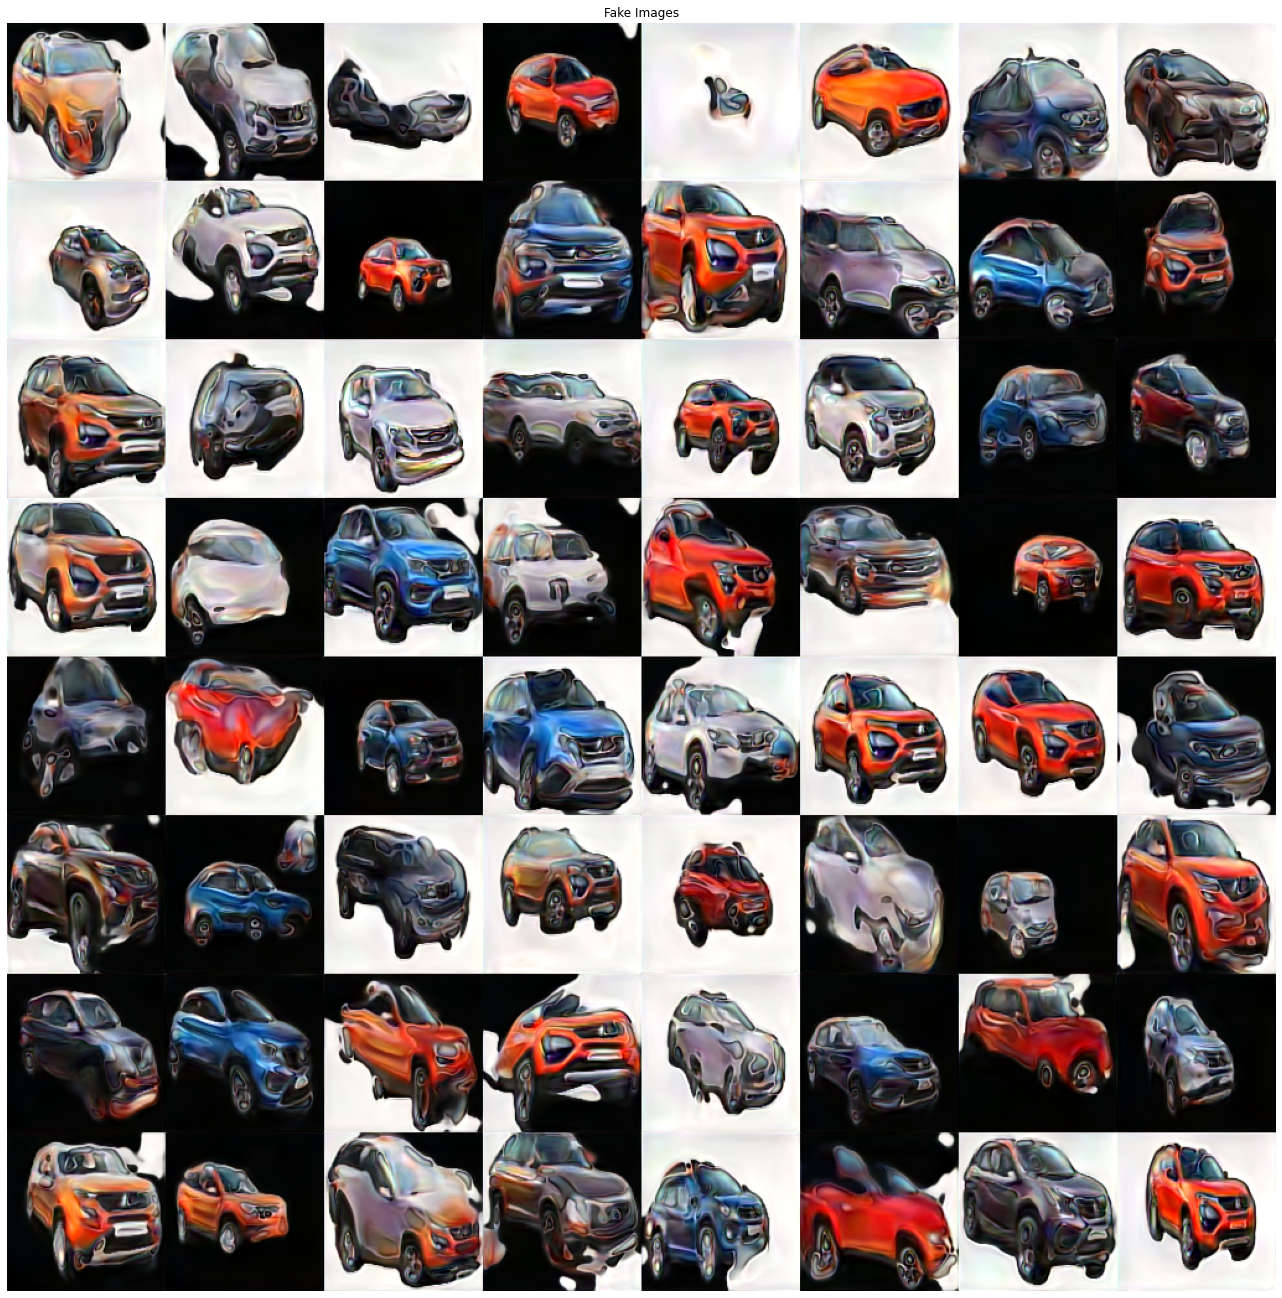

In [48]:
%autoreload 2
from RekogNizer import ganutils

#ganutils.create_graphs_and_samples(G_losses, D_losses, img_list, data_loader,device)
rand_z = ganutils.generate_image_sample(r1gan.G, device, size_tuple=(50,50))

In [ ]:
!tar -czvf samples_12k_multibg.tar.gz samples/*


In [52]:
r1gan.df_loss.to_csv("losses_multibg_12k.csv")

In [ ]:
%autoreload 2
from RekogNizer import ganutils

#ganutils.create_graphs_and_samples(G_losses, D_losses, img_list, data_loader,device)
rand_z = ganutils.generate_image_sample(r1gan.G, device, size_tuple=(50,50))

In [ ]:
with torch.no_grad():
    my_op=nn.Conv2d(1024, 512, 3)(torch.rand([64, 1024,8,8]))
    my_op_1x1=nn.Conv2d(512, 1024, kernel_size=1)(torch.rand([64, 512,8,8]))

In [ ]:
myResBlock = ganmodelsnew.R1GANResidualBlock(64,64)

In [ ]:
with torch.no_grad():
    my_op = myResBlock(torch.rand([64, 64,8,8]))
my_op.shape

torch.Size([64, 64, 8, 8])

In [ ]:
my_op.shape

In [ ]:
!cp $(ls -1 /content/ckpt/*|tail -2) /content/drive/My\ Drive/EVA4/S2GAN/64_r1gan

In [72]:
!cp /content/ckpt/r1gan_adamrelu128_wbg008550.pth.tar /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan

In [ ]:
!cp /content/ckpt/r1gan_adamrelu128_wbg008400.pth.tar /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan

In [45]:
#!cp /content/ckpt/r1gan_adamrelu128_wbg005200.pth.tar /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan

!cp /content/ckpt/r1gan_adamrelu128_wbg012400.pth.tar /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan


In [16]:
#!cp /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan/r1gan_adamrelu128_wbg005200.pth.tar /content/ckpt/
!cp /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan/r1gan_adamrelu128_wbg008550.pth.tar /content/ckpt/

In [13]:
!ls -lrt /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan/*


-rw------- 1 root root 559114818 Sep 20 11:07 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128001600.pth.tar'
-rw------- 1 root root 559114818 Sep 20 11:07 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128001400.pth.tar'
-rw------- 1 root root 559114818 Sep 20 12:08 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128002000.pth.tar'
-rw------- 1 root root 559114818 Sep 20 12:45 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128002600.pth.tar'
-rw------- 1 root root    427743 Sep 23 20:37 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adamrelu128_wbg005400.pth.tar'
-rw------- 1 root root 559114946 Sep 23 20:44 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adamrelu128_wbg005200.pth.tar'
-rw------- 1 root root 559114944 Sep 23 21:14 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128_wbg2004600.pth.tar'
-rw------- 1 root root 559114944 Sep 23 21:28 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128_wbg2004400.pth.tar'
-rw---

In [ ]:
!tar -czvf samples.tar.gz samples/*

In [ ]:
#!cp  /content/drive/My\ Drive/EVA4/S2GAN/64_r1gan/r1gan_adam64006000.pth.tar /content/ckpt
#!cp  /content/drive/My\ Drive/EVA4/S2GAN/64_r1gan/r1gan_adam64005800.pth.tar /content/ckpt
!cp  /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128002600.pth.tar /content/ckpt

In [ ]:
!cp $(ls -1rt /content/ckpt/* |tail -1) /content/drive/My\ Drive/EVA4/S2GAN/

In [ ]:
! ls -rlt /content/drive/My\ Drive/EVA4/S2GAN/128_r1gan/*

-rw------- 1 root root 559114818 Sep 20 11:07 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128001600.pth.tar'
-rw------- 1 root root 559114818 Sep 20 11:07 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128001400.pth.tar'
-rw------- 1 root root 559114818 Sep 20 12:08 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128002000.pth.tar'
-rw------- 1 root root 559114818 Sep 20 12:45 '/content/drive/My Drive/EVA4/S2GAN/128_r1gan/r1gan_adam128002600.pth.tar'


In [ ]:
len(img_list[-100:])

100

In [ ]:
img_list = img_list[-100:]

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list[100:]]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)
ani.save("halucinogan2.mp4")
HTML(ani.to_jshtml())



In [ ]:
del ani

In [ ]:
def tensor2img(tensor):
    img = (np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.
    return img
def get_sample_image(G, n_noise=100, n_samples=64):
    """
        save sample 100 images
    """
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(DEVICE) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return result,z

torch.Size([1, 256])

In [ ]:
step_local=step
save_checkpoint({'global_step': step_local,
        'D':D.state_dict(),
        'G':G.state_dict(),
        'd_optim': D_opt.state_dict(),
        'g_optim' : G_opt.state_dict()},
    'ckpt/Newr1gan{:06d}.pth.tar'.format(step_local))

In [ ]:
!cp /content/ckpt/Newr1gan000102.pth.tar /content/drive/My\ Drive/EVA4/S2GAN/

In [ ]:
!cp /content/ckpt/r1gan008800.pth.tar /content/drive/My\ Drive/EVA4/S2GAN/r1gan008800.pth.tar_R1GAN3

In [ ]:
!cp /content/drive/My\ Drive/EVA4/S2GAN/r1gan008800.pth.tar_R1GAN3 /content/ckpt/r1gan008800.pth.tar 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


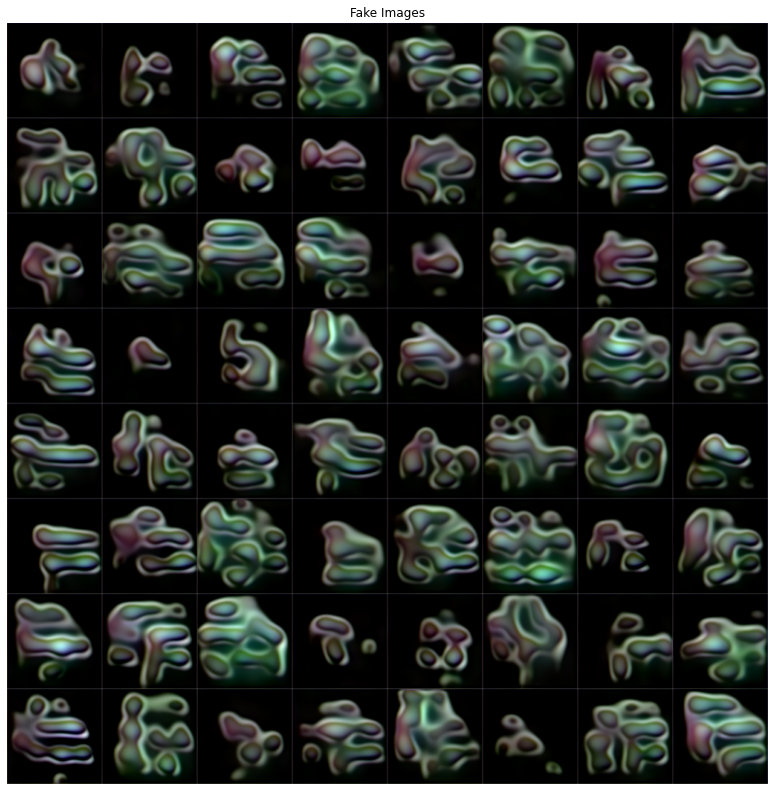

In [ ]:
rand_z = ganutils.generate_image_sample(r1gan.G, device, size_tuple=(30,30))

In [ ]:
rand_z_local = rand_z.clone()


In [ ]:
#output_z.shape
n_rows=4
my_op = torch.cat([torch.cat([output_z[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)

In [ ]:
my_op.shape
plt.imshow(tensor2img(my_op))

In [ ]:
rand_z_local =rand_z.clone()
offset = 1
#rand_z_local[offset][2] = 20
# rand_z[offset][100] = 1
#output_z = G(rand_z_local[offset].reshape((1,256)).to(DEVICE))
#fig, axs = plt.subplots(1,10, figsize=(20, 20))

lambda_range=np.linspace(-20,20,16)


img_op_list = []

for feature in range(0, 255):
    rand_z_arr = []
    for ind,l in enumerate(lambda_range):
        rand_z_local[offset][feature] = l
        rand_z_arr.append(rand_z_local[offset].clone())
        #rand_z_range = torch.stack(rand_z_arr)
    G.eval()
    output_z = G(torch.stack(rand_z_arr))
    #fig = plt.figure(figsize=(64,64))
    #img_op_list.append((np.transpose(vutils.make_grid(output_z.detach().cpu(), padding=5, normalize=False,nrow=10),(1,2,0))))
    img_op_list.append(tensor2img(output_z[-1]))
# for feature in range(0, 255):
#     lambda_range=np.linspace(6,20,10)
#     #feature = 254



#     fig.subplots_adjust(hspace = .5, wspace=.001)
#     axs = axs.ravel()

#     for ind,l in enumerate(lambda_range):
#         #inter_image=interpolation(float(l), generator, latent_1, latent_2)
#         rand_z_local[offset][feature] = l
#         #rand_z_local[offset][12] = l
#         output_z = G(rand_z_local[offset].reshape((1,256)).to(DEVICE))
#         #inter_image = to_img(inter_image)
        
#         image = tensor2img(output_z[-1])
    
#         axs[ind].imshow(image)
        
#         axs[ind].set_title('lambda_val='+str(round(l,1)))
#     plt.show() 

'''
Dim(2) == Black to White SUV+Background removal (2,20)
Dim(4) == Height (1, 20)--> SUV shaper
Dim(5) == car length+ head lights(1,20)
Dim(7) == Red Gloss active on the negative range (-20, 0)
Dim(38) ==  SUV + Background (10, 20)
Dim(25) == Ground clearance+Redness (-10,10)
Dim(239) == White to Blue SUV  (-20, -5)
Dim(244) == red Padmini  (-20, -9)
Dim(245) == red sports car to hatchback  (-20, 0)



Dim(255) == SUV  (6, 20)


'''

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


'\nDim(2) == Black to White SUV+Background removal (2,20)\nDim(4) == Height (1, 20)--> SUV shaper\nDim(5) == car length+ head lights(1,20)\nDim(7) == Red Gloss active on the negative range (-20, 0)\nDim(38) ==  SUV + Background (10, 20)\nDim(25) == Ground clearance+Redness (-10,10)\nDim(239) == White to Blue SUV  (-20, -5)\nDim(244) == red Padmini  (-20, -9)\nDim(245) == red sports car to hatchback  (-20, 0)\n\n\n\nDim(255) == SUV  (6, 20)\n\n\n'

In [ ]:
plt.imshow(img_op_list[1])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..2

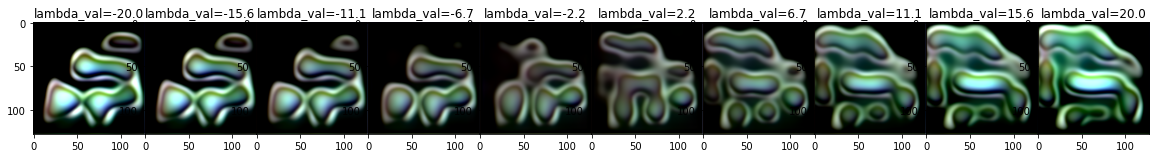

In [ ]:
rand_z_local =rand_z.clone()
offset = 1
#rand_z_local[offset][2] = 20
# rand_z[offset][100] = 1
output_z = r1gan.G(rand_z_local[offset].reshape((1,256)).to(DEVICE))
fig, axs = plt.subplots(1,10, figsize=(20, 20))



lambda_range=np.linspace(-20,20,10)
feature = 200

fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

#for feature in [254,200]:
for ind,l in enumerate(lambda_range):
    #inter_image=interpolation(float(l), generator, latent_1, latent_2)
    rand_z_local[offset][feature] = l
    #rand_z_local[offset][12] = l
    output_z = r1gan.G(rand_z_local[offset].reshape((1,256)).to(DEVICE))
    #inter_image = to_img(inter_image)
    
    image = ganutils.tensor2img(output_z[-1])

    axs[ind].imshow(image)
    
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

In [ ]:

offset = 45
#randz_local[offset][10] = 0.1728
#randz_local[offset][2] = -10
#rand_z[offset][100] = 1
#output_z = G(randz_local[offset].reshape((1,256)).to(DEVICE))
output_z = G(randz_local[offset].reshape((1,256)).to(DEVICE))

plt.imshow(tensor2img(output_z[-1]))

In [ ]:
save_checkpoint({'global_step': step,
        'D':D.state_dict(),
        'G':G.state_dict(),
        'd_optim': D_opt.state_dict(),
        'g_optim' : G_opt.state_dict()},
    'ckpt/r1gan3{:06d}.pth.tar'.format(step))


#!cp $(ls -1rt /content/ckpt/*|tail -2)  /content/drive/My\ Drive/EVA4/S2GAN

In [ ]:
!cp $(ls -1rt /content/ckpt/*|tail -2) /content/

In [ ]:
!ls -lrt /content/drive/My\ Drive/EVA4/S2GAN/*R1GAN3

-rw------- 1 root root 271295493 Sep 15 20:18 '/content/drive/My Drive/EVA4/S2GAN/r1gan006600.pth.tar_R1GAN3'
-rw------- 1 root root 271295495 Sep 16 20:20 '/content/drive/My Drive/EVA4/S2GAN/r1gan009600.pth.tar_R1GAN3'
-rw------- 1 root root 271295495 Sep 16 20:24 '/content/drive/My Drive/EVA4/S2GAN/r1gan008800.pth.tar_R1GAN3'


In [ ]:
next(iter(data_loader)).shape

torch.Size([128, 3, 64, 64])

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
max_epoch = 100
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [ ]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [ ]:
torch.rand(1,100).view(20,5).size()

torch.Size([20, 5])

## Sample

In [ ]:
import torchvision.utils as vutils

def create_graphs_and_samples(img_list, data_loader,size_tuple=(30,30)):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


    real_batch = next(iter(data_loader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    # plt.subplot(1,2,2)
    # plt.axis("off")
    # plt.title("Fake Images")
    # plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    # plt.show()

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.array(img_list[-1]))#np.transpose(np.array(img_list[-1]),(1,2,0)))
    plt.show()

    return generate_image_sample(size_tuple)

def generate_image_sample(size_tuple=(30,30)):
    output_images,rand_z = get_sample_image(G, n_noise=n_noise, n_samples=64)
    #output_images_list = vutils.make_grid(output_images, padding=2, normalize=True)

    # img_data_np = output_images#.eval()
    # min_val = np.min(img_data_np)
    # max_val = np.max(img_data_np)
    # img_data_clamped = (img_data_np - min_val) / (max_val - min_val)
    plt.figure(figsize=size_tuple)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    #plt.imshow(np.transpose(output_images_list,(1,2,0)))
    plt.imshow(np.array(output_images))
    plt.show()
    return rand_z

In [ ]:
"""
    Model and Training boilerplate code for Generative and VAE Models
"""
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import grad
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from RekogNizer.ganutils import tensor2img, get_sample_image, save_checkpoint, generate_image_sample, create_graphs_and_samples


import os
import sys
import glob
from tqdm import tqdm_notebook as tqdm
import datetime
import numpy as np



################# Used Exclusively for GANs ##################
class R1GANResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None, groups=1):
        super(R1GANResidualBlock, self).__init__()
        p = kernel_size//2
        self.conv1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size, stride=stride, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.proj = nn.Conv2d(inplanes, planes, 1) if inplanes != planes else None
    
    def forward(self, x):
        identity = x
        
        y = self.conv1(x)
        y = self.conv2(y)
        
        identity = identity if self.proj is None else self.proj(identity)
        y = y + identity
        return y


class R1GANDiscriminator(nn.Module):
    """
        Convolutional Discriminator
    """
    def __init__(self, in_channel=1,img_size=64):
        super(R1GANDiscriminator, self).__init__()
        self.dim_size = img_size//(2**4)
        self.D = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1), # (N, 64, 64, 64)
            R1GANResidualBlock(64, 128),
            nn.AvgPool2d(3, 2, padding=1), # (N, 128, 32, 32)
            R1GANResidualBlock(128, 256),
            nn.AvgPool2d(3, 2, padding=1), # (N, 256, 16, 16)
            R1GANResidualBlock(256, 512),
            nn.AvgPool2d(3, 2, padding=1), # (N, 512, 8, 8)
            R1GANResidualBlock(512, 1024),
            nn.AvgPool2d(3, 2, padding=1) # (N, 1024, 4, 4)
        )
        self.fc = nn.Linear(1024*self.dim_size*self.dim_size, 1) # (N, 1)
        
    def forward(self, x):
        B = x.size(0)
        h = self.D(x)
        h = h.view(B, -1)
        y = self.fc(h)
        return y

class R1GANGenerator(nn.Module):
    """
        Convolutional Generator
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=512,ngpu=1,img_size=64):
        super(R1GANGenerator, self).__init__()
        self.ngpu = ngpu
        self.dim_size = img_size//(2**4)
        self.fc = nn.Linear(n_noise, 1024*self.dim_size*self.dim_size)
        self.G = nn.Sequential(
            R1GANResidualBlock(1024, 512),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 512, 8, 8)
            R1GANResidualBlock(512, 256),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 256, 16, 16)
            R1GANResidualBlock(256, 128),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 128, 32, 32)
            R1GANResidualBlock(128, 64),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 64, 64, 64)
            R1GANResidualBlock(64, 64),
            nn.Conv2d(64, out_channel, 3, padding=1) # (N, 3, 64, 64)
        )
        
    def forward(self, z):
        B = z.size(0)
        h = self.fc(z)
        h = h.view(B, 1024, self.dim_size, self.dim_size)
        x = self.G(h)
        return x

class R1GAN():
    ##### Basic weights initializer #############
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    #### Loss function specific to R1 GANs ####
    def r1loss(self,inputs, label=None):
        # non-saturating loss with R1 regularization
        l = -1 if label else 1
        return F.softplus(l*inputs).mean()

    def train(self, 
              data_loader, 
              device,
              log_term = 10,
              save_term = 200,
              max_epochs=200,
              r1_gamma=10):
        
        
        self.log_term = log_term
        self.save_term = save_term
        self.max_epochs = max_epochs
        self.r1_gamma = r1_gamma
        G_losses = []
        D_losses = []
        img_list = []
        step = 0
        self.D.to(device)
        self.G.to(device)

        for epoch in range(self.max_epochs):
            for idx, images in enumerate(tqdm(data_loader, total=len(data_loader)),0):
                self.G.zero_grad()
                # Training Discriminator
                
                x = images.to(device)
                b_size = x.size(0)
                labels = torch.full((b_size,), 1., dtype=torch.float, device=device)

                x.requires_grad = True
                x_outputs = self.D(x)
                d_real_loss = self.r1loss(x_outputs, True)
                # Reference >> https://github.com/rosinality/style-based-gan-pytorch/blob/a3d000e707b70d1a5fc277912dc9d7432d6e6069/train.py
                # little different with original DiracGAN
                grad_real = grad(outputs=x_outputs.sum(), inputs=x, create_graph=True)[0]
                grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
                grad_penalty = 0.5*self.r1_gamma*grad_penalty
                D_x_loss = d_real_loss + grad_penalty

                z = (torch.rand(size=[b_size, self.n_noise])*2-1).to(device)
                x_fake = self.G(z)
                z_outputs = self.D(x_fake.detach())
                D_z_loss = self.r1loss(z_outputs, False)
                D_loss = D_x_loss + D_z_loss
                
                self.D.zero_grad()
                D_loss.backward()
                self.D_opt.step()

                # Training Generator
                z = (torch.rand(size=[batch_size, self.n_noise])*2-1).to(device)
                x_fake = self.G(z)
                z_outputs = self.D(x_fake)
                G_loss = self.r1loss(z_outputs, True)
                
                self.G.zero_grad()
                G_loss.backward()
                self.G_opt.step()
                
                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())

                if step % self.save_term == 0:
                    save_checkpoint({'global_step': step,
                        'D':self.D.state_dict(),
                        'G':self.G.state_dict(),
                        'd_optim': self.D_opt.state_dict(),
                        'g_optim' : self.G_opt.state_dict()},
                        'ckpt/r1gan_adam{:06d}.pth.tar'.format(step))
                
                if step % self.log_term == 0:
                    dt = datetime.datetime.now().strftime('%H:%M:%S')
                    print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, \
                    G Loss: {:.4f}, gp: {:.4f}, Time:{}'.format(epoch, 
                                                            self.max_epochs, 
                                                            step, 
                                                            D_loss.item(), 
                                                            G_loss.item(), 
                                                            grad_penalty.item(), 
                                                            dt))
                                                            
                    # with torch.no_grad():
                    #     fake = G(n_noise).detach().cpu()
                    # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                    self.G.eval()
                    img,rand_z_none = get_sample_image(self.G, device, self.n_noise, n_samples=64, )
                    img_data_np = img#.eval()
                    min_val = np.min(img_data_np)
                    max_val = np.max(img_data_np)
                    img_data_clamped = (img_data_np - min_val) / (max_val - min_val)
                    #img_list.append(vutils.make_grid(img, padding=2, normalize=True))
                    img_list.append(img_data_clamped)
                    #imsave('samples/{}_step{:06d}.jpg'.format(MODEL_NAME, step), img_data_clamped)
                    self.G.train()
                
                step += 1
        
        #### Save the last state as well 
        save_checkpoint({'global_step': step,
            'D':self.D.state_dict(),
            'G':self.G.state_dict(),
            'd_optim': self.D_opt.state_dict(),
            'g_optim' : self.G_opt.state_dict()},
            'ckpt/r1gan_adam{:06d}.pth.tar'.format(step))
        

    def __init__(self,
                 img_size=64,
                 d_in_channel=1,
                 g_out_channel=1, 
                 g_n_filters=128, 
                 g_n_noise=512,
                 g_opt=None, 
                 d_opt=None,
                 init_weights=True,
                 log_term = 10,
                 save_term = 200,
                 max_epochs=200,
                 r1_gamma=10):
        self.G = R1GANGenerator(out_channel=g_out_channel, 
                                n_filters=g_n_filters, 
                                n_noise=g_n_noise,img_size=img_size)
        self.D = R1GANDiscriminator(in_channel=d_in_channel,img_size=img_size)
        if(init_weights == True ):
            self.G.apply(self.weights_init)
            self.D.apply(self.weights_init)
        
        self.D_opt = torch.optim.Adam(self.D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.G_opt = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))
        #### Setting to user-provided optimizers if not NULL
        if(g_opt is not None):
            self.G_opt = g_opt
        if(d_opt is not None ):
            self.D_opt = d_opt
        
        #### Training essentials #####
        self.log_term = log_term
        self.save_term = save_term
        self.max_epochs = max_epochs
        self.r1_gamma = r1_gamma
        self.n_noise = g_n_noise